This notebook addresses the question, "Can we represent a molecule as a graph via a 1D column vector or a 2D matrix of fixed length, with maximum number of atoms n_rows?" Then, can we use this representation to learn neural fingerprints? E.g., can we make an aromatic ring detector? 

Scheme:
feature_matrix = X
for each ligand:
    choose a central atom. this can be the atom (node) that minimizes distance to furthest heavy atom in graph.
    set first row of X to be this central atom
    set next four rows to be the atoms bonded to that centrl atom
        set zeros for rows where row ind > n_bonds of atom
    for each of those atoms:
        repeat. find their neighbors. add to matrix.

algorithm: breadth-first search:
1. create networkx graph based on molecule
2. find "central" atom (different strategies)
3. define atom matrix of size (1+4+4*3^(L-1)) x (n_features_per_atom)
4. start atom queue q
5. central_atom.layer = 0; central_atom.row_idx = 0;
6. q.enqueue(central_atom)
7. define adjacency matrix of size (1+4+4*3^(L-1)) x 4

def get_row_idx(curr_layer, prev_row_idx, curr_neighbor_idx):
    if curr_layer == 0:
        return(0)
    if curr_layer == 1:
        row_idx = 1 + curr_neighbor_idx
    if layer == 2:
        last_max = 5
        row_idx = last_max + (3*(prev_row_idx-last_max)) + curr_neighbor_idx
    if layer > 2:
        last_max = 5 + 4*3^(curr_layer-2) 
        row_idx = last_max + 3*(prev_row_idx-last_max) + curr_neighbor_idx
    return(row_idx)
    

while q.is_not_empty():
    a = q.dequeue()
    a.visited = True
    for n_idx, n in enumerate(a.neighbors()):
        if not n.visited:
            row_idx = c
            n.layer = a.layer + 1
            row_idx = get_row_idx(n.layer, a.row_idx, n_idx)
            n.row_idx = row_idx
            adj_matrix[a.row_idx][n_idx] = n.row_idx
            atom_matrix[row_idx][elem_to_idx[n.elem]] = 1

input_matrix = tf.concat([atom_matrix, atom_matrix[adj_matrix[:,0]], atom_matrix[adj_matrix[:,1]], atom_matrix[adj_matrix[:,2]], atom_matrix[adj_matrix[:,3]]

neural net:
h1 = relu([tf.zeros([n_features_per_atom, 4]) * input_matrix + bias))
h1_conc = tf.concat([h1, h1[adj_matrix[:,0], ..., h1[adj_matrix[:,3])

repeat h1 to get h2


dihedral predictor pseudocode:

get bonds for molecule
create networkx graph out of molecule (use atom indices)

for each edge:
   for neighbor_i in atom_i.neighbors():
       if neighbor_i == atom_j: continue
       for neighbor_j in atom_j.neighbors():
           if neighbor_j == atom_i: continue
           dihedrals.append((neighbor_i, atom_i, neighbor_j, atom_j))
           check to make sure (atom_j, neighbor_j, atom_i, neighbor_i)) not already in list

for dihedral in dihedrals:
    angle =  rdMolTransforms.GetDihedralDeg(c, 0,1,2,3)


In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random

In [3]:
def get_torsions_angles(mol, n_bonds=100, n_atoms=200):
    c = mol.GetConformer(0)

    torsions = []
    torsion_tuples = []
    
    torsion_matrix = np.zeros((n_bonds,6))
    torsion_indices = np.zeros((n_bonds,n_atoms,24)).astype(np.uint8)
    
    bond_adjacency = np.zeros((n_bonds,n_bonds)).astype(np.uint8)
    for idx, bond in enumerate(mol.GetBonds()):
        if bond.IsInRing(): 
            continue

        def calc_torsions(atom_i, atom_j, bond_idx, start=0):        
            exist_dihed = False
            for neighbor_j in atom_j.GetNeighbors():
                if neighbor_j.GetIdx() == atom_i.GetIdx():
                    continue

                dihed_idx = 0
                for neighbor_i in atom_i.GetNeighbors():
                    if neighbor_i.GetIdx() == atom_j.GetIdx():
                        continue

                    exist_dihed=True
                    torsion_tuple = (neighbor_i.GetIdx(), atom_i.GetIdx(), atom_j.GetIdx(), neighbor_j.GetIdx())

                    torsion_matrix[bond_idx][3*start+dihed_idx] = np.cos(rdMolTransforms.GetDihedralRad(c, *torsion_tuple))
                    torsion_indices[bond_idx][torsion_tuple[0]][12*start+dihed_idx*4] = 1
                    torsion_indices[bond_idx][torsion_tuple[1]][12*start+dihed_idx*4+1] = 1
                    torsion_indices[bond_idx][torsion_tuple[2]][12*start+dihed_idx*4+2] = 1
                    torsion_indices[bond_idx][torsion_tuple[3]][12*start+dihed_idx*4+3] = 1
                    dihed_idx += 1
                #torsion_matrix[bond_idx][3] = 3.14159 - np.abs(np.abs(torsion_matrix[bond_idx][2]-torsion_matrix[bond_idx][1])-3.14159)
                #torsion_matrix[bond_idx][4] = 3.14159 - np.abs(np.abs(torsion_matrix[bond_idx][2]-torsion_matrix[bond_idx][0])-3.14159)
                #torsion_matrix[bond_idx][5] = 3.14159 - np.abs(np.abs(torsion_matrix[bond_idx][1]-torsion_matrix[bond_idx][0])-3.14159)
                break
        
        calc_torsions(bond.GetBeginAtom(), bond.GetEndAtom(), idx, 0)
        calc_torsions(bond.GetEndAtom(), bond.GetBeginAtom(), idx, 1)
    
        atom_i_bonds = bond.GetBeginAtom().GetBonds()
        atom_j_bonds = bond.GetEndAtom().GetBonds()

        for bond_i in atom_i_bonds:
            if bond_i.GetIdx() != bond.GetIdx():
                bond_adjacency[bond.GetIdx()][bond_i.GetIdx()] = 1.
                bond_adjacency[bond_i.GetIdx()][bond.GetIdx()] = 1.
        for bond_j in atom_j_bonds:
            if bond_j.GetIdx() != bond.GetIdx():
                bond_adjacency[bond.GetIdx()][bond_j.GetIdx()] = 1.
                bond_adjacency[bond_j.GetIdx()][bond.GetIdx()] = 1.
        if(torsion_matrix[idx][0] != 0.):
            pass
    
    
    return((torsion_indices, csr_matrix(torsion_matrix), csr_matrix(bond_adjacency)))
                

In [4]:
def featurize_mols(mol_files):
    featurizer = AdjacencyFingerprint(max_n_atoms=200)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 100 == 0:
            print(idx)
        try:
        #if 1==1:
            mol = Chem.MolFromMol2File(mol_file)
            if mol is None:
                features.append(None)
                continue
            torsions = get_torsions_angles(mol)
            graph_feat = featurizer.featurize([mol])[0]
            features.append((mol_file, torsions, graph_feat))
        #else:
        except:
            features.append(None)
    return(features)

In [5]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [6]:
import pickle
feature_file = "./dihedral_features_pdbbind.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = [f for f in find_files(pdbbind_dir, "*ligand.mol2")][1:2]
    features = featurize_mols(ligand_files)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

0


In [7]:
features = [f for f in features if f is not None]

In [8]:
features[0][1][1].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.9370852 , -0.2220445 ,  0.        ,  0.9370852 , -0.93765054,
         0.        ],
       [-0.99656916,  0.47917077,  0.        , -0.99656916,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.99942952,  0.99937226,  0.        , -0.99942952,  0.        ,
         0.        ],
       [ 0.46265918,  0.        ,  0.        ,  0.46265918,  0.        ,
         0.        ],
       [-0.20159458,  0.        ,  0.        , -0.20159458,  0.20038065,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.25325857,  0.        ,  0.        ,  0.25325857, -0.95676343,
         0.        ],
       [ 0.72490805,  0.21741071,  0.        ,  0.

In [9]:
len(features)

1

In [10]:
import tensorflow as tf
alpha = 0.01
n_layers = 0

S = 32

B = 200
p = 75

L_list = [p, 50, 50, 50, 50]

n_bonds = 100   
dihed_per_bond = 6
valence = 4

x = tf.placeholder(tf.float32, shape=[S, B, p])

non_zero_inds = tf.placeholder(tf.int32, shape=[None, S*n_bonds])

adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B])
dihed_indices = tf.placeholder(tf.float32, shape=[S, n_bonds, B, dihed_per_bond*valence])

label_placeholder = tf.placeholder(
    dtype='float32', shape=[None,dihed_per_bond], name="label_placeholder")

phase = tf.placeholder(dtype='bool', name='phase')

z = tf.placeholder(tf.float32,
                          [None, L_list[n_layers]*valence*dihed_per_bond], name='z')


In [11]:
A_W_list = [None for i in range(n_layers)]
A_b_list = [None for i in range(n_layers)]
h_list = [None for i in range(n_layers+1)]

for layer_idx in range(n_layers):
    L_in = L_list[layer_idx]
    L_out = L_list[layer_idx+1]

    A_W_list[layer_idx] = tf.Variable(tf.truncated_normal([L_in, L_out], seed=2017), name="A_W_list%d" %layer_idx)
    A_b_list[layer_idx] = tf.Variable(tf.zeros([1, L_out]))

    
D_W0 = tf.Variable(tf.truncated_normal([L_list[n_layers]*(dihed_per_bond*valence)+6, 100]))
D_b0 = tf.Variable(tf.zeros([1, 100]))

D_W1 = tf.Variable(tf.truncated_normal([100, dihed_per_bond]))
D_b1 = tf.Variable(tf.zeros([1, dihed_per_bond]))

D_W2 = tf.Variable(tf.truncated_normal([dihed_per_bond, 10]))
D_b2 = tf.Variable(tf.zeros([1, 10]))

D_W3 = tf.Variable(tf.truncated_normal([10, 1]))
D_b3 = tf.Variable(tf.zeros([1, 1]))


G_W0 = tf.Variable(tf.truncated_normal([L_list[n_layers]*dihed_per_bond*valence, 100]))
G_b0 = tf.Variable(tf.zeros([1, 100]))

G_W1 = tf.Variable(tf.truncated_normal([100, 25]))
G_b1 = tf.Variable(tf.zeros([1, 25]))

G_W2 = tf.Variable(tf.truncated_normal([25, dihed_per_bond]))
G_b2 = tf.Variable(tf.zeros([1, dihed_per_bond]))


def adjacency_conv_layer(atom_matrix, W, b, L_in, L_out, layer_idx, is_training=True):
    print("layer_idx: %d" %(layer_idx))
    h = tf.matmul(adj_matrix, atom_matrix)
    h = tf.reshape(h, shape=(S*B, L_in))

    h = tf.matmul(h, W) + b
    h = tf.maximum(alpha*h, h)
    
    h = tf.reshape(h, (S, B, L_out))
    #h = tf.contrib.layers.batch_norm(h, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)

    return(h)

def get_atom_types(is_training):
    h_list[0] = x
    for layer_idx in range(n_layers):
        L_in = L_list[layer_idx]
        L_out = L_list[layer_idx+1]
        
        atom_matrix = h_list[layer_idx]
        
        h_list[layer_idx+1] = adjacency_conv_layer(atom_matrix, A_W_list[layer_idx],
                                                     A_b_list[layer_idx], L_in, L_out,
                                                     layer_idx, is_training)
    L_final = L_list[n_layers]

    
    h_final = tf.reshape(h_list[n_layers], (S, B, L_final))

    def mult(idx):
        return(tf.matmul(dihed_indices[:,:,:,tf.cast(idx, tf.int32)], h_final))
    
    elems = np.arange(24).astype(np.float32)
    d0 = tf.concat(tf.map_fn(mult, elems), axis=2)
    d0 = tf.reshape(d0, (S*n_bonds, L_final*24))
    output = tf.matmul(tf.cast(non_zero_inds, tf.float32), d0)
    print("atom_types")
    print(output)
    return(output)



In [12]:
def discriminator(angles, is_training=True):
    d0 = get_atom_types(is_training)
    d0 = tf.concat([d0, angles], axis=1)
    
    print("d0")
    print(d0)

    d1 = tf.matmul(d0, D_W0, name="disc2") + D_b0
    d1 = tf.maximum(d1, alpha*d1)

    #d1 = tf.contrib.layers.batch_norm(d1, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
    
    d2 = tf.matmul(d1, D_W1, name="disc3") + D_b1
    d2 = tf.maximum(d2, alpha*d2)
    
    #d3 = tf.nn.tanh(d3)

    #d3 = tf.contrib.layers.batch_norm(d3, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
    
                                                                                                                                                               
    d3 = tf.matmul(d2, D_W2, name="disc3") + D_b2
    
    #
    #output = tf.matmul(d4, D_W5, name="disc4") + D_b5
    
    #D_prob = tf.nn.sigmoid(D_logit)
    output = d3
    
    return(output)

In [13]:
def atan2(y, x, epsilon=1.0e-12):
  # Add a small number to all zeros, to avoid division by zero:
  x = tf.where(tf.equal(x, 0.0), x+epsilon, x)
  y = tf.where(tf.equal(y, 0.0), y+epsilon, y)

  angle = tf.where(tf.greater(x,0.0), tf.atan(y/x), tf.zeros_like(x))
  angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.greater_equal(y,0.0)), tf.atan(y/x) + np.pi, angle)
  angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.less(y,0.0)), tf.atan(y/x) - np.pi, angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.greater(y,0.0)), 0.5*np.pi * tf.ones_like(x), angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.less(y,0.0)), -0.5*np.pi * tf.ones_like(x), angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.equal(y,0.0)), tf.zeros_like(x), angle)
  return angle


def generator(z, is_training=True):

    g_d0 = get_atom_types(is_training) + z
    
    g_d1 = tf.matmul(g_d0, G_W0, name='gen1') + G_b0
    g_d1 = tf.tanh(g_d1)
    #g_d2 = tf.maximum(alpha*g_d2, g_d2)

    
    #g_d2 = tf.contrib.layers.batch_norm(g_d2, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
    
    g_d2 = tf.matmul(g_d1, G_W1) + G_b1
    g_d2 = tf.nn.tanh(g_d2)

    #g_d3 = tf.contrib.layers.batch_norm(g_d3, 
    #                                    center=True, scale=False, 
    #                                    is_training=is_training)
                                                                                                                                                               
    g_d3 = tf.matmul(g_d2, G_W2) + G_b2
    
    #d3_cos = tf.cos(g_d4)
    #d3_sin = tf.sin(g_d4)
    #output = atan2(d3_sin, d3_cos)
    
    #output = tf.concat([output,
    #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,2]-output[:,1])-3.14159), (-1,1)),
    #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,2]-output[:,0])-3.14159), (-1,1)),
    #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,1]-output[:,0])-3.14159), (-1,1))],
    #                   axis=1)
    
    
    output = g_d3

    return(output)



In [14]:
theta_D = A_W_list[:n_layers] + A_b_list[:n_layers] + [D_W0, D_b0, D_W1, D_b1, D_W2, D_b2]
#theta_D = [D_W_list[0], D_W2, D_W3, D_W4, D_W5, D_b_list[0], D_b2, D_b3, D_b4, D_b5]

theta_G =  A_W_list[:n_layers] + A_b_list[:n_layers] + [G_W0, G_b0, G_W1, G_b1, G_W2, G_b2]

In [15]:
def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob=1.0, train=False,
                       shuffle_inds=True):
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    atom_adj_batch = [X[idx][2][0].toarray().astype(np.float32) for idx in inds]
    A_batch = [X[idx][2][1].toarray() for idx in inds]
    D_batch = [X[idx][1][0] for idx in inds]
    y_batch = [X[idx][1][1].toarray() for idx in inds]
    bond_adj_batch = [X[idx][1][2].toarray() for idx in inds]

    
    y_batch = np.concatenate(y_batch, axis=0)
    n_non_zeros = len(np.where(y_batch[:,0] != 0.)[0])
    non_zero_batch = np.where(y_batch[:,0] != 0.)[0]
    y_batch = y_batch[non_zero_batch]

    y_batch = y_batch + np.random.normal(0, 0.03, size=y_batch.shape)

    onehotter = OneHotEncoder(n_values = S*X[0][1][1].shape[0])
    non_zero_onehot = onehotter.fit_transform(non_zero_batch).toarray().reshape((len(non_zero_batch),S*X[0][1][1].shape[0]))
    
    z_batch = np.random.uniform(-0.1, 0.1, size=(n_non_zeros, L_list[n_layers]*dihed_per_bond*valence))
    
    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 phase: train,
                 label_placeholder: y_batch,
                 non_zero_inds: non_zero_onehot,
                 dihed_indices: D_batch,
                 z:z_batch,
                }
    return(feed_dict)



atom_types
Tensor("MatMul_8:0", shape=(?, 1800), dtype=float32)
atom_types
Tensor("MatMul_11:0", shape=(?, 1800), dtype=float32)
atom_types
Tensor("MatMul_14:0", shape=(?, 1800), dtype=float32)
d0
Tensor("concat_9:0", shape=(?, 1806), dtype=float32)
atom_types
Tensor("MatMul_15:0", shape=(?, 1800), dtype=float32)
d0
Tensor("concat_11:0", shape=(?, 1806), dtype=float32)
Training epoch 0
Iter: 0
D loss: 2.866e-06
G_loss: 1.658e-05
()


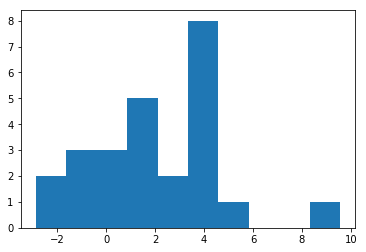

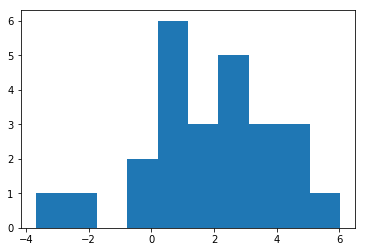

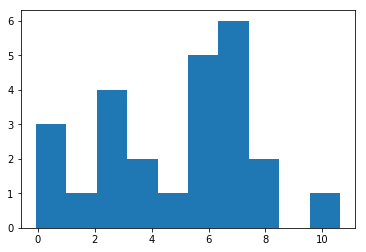

[ 2.02965804  1.84177752  4.94373297  1.90233899 -0.64202212 -2.26019768]
Training epoch 100
Iter: 100
D loss: 0.002375
G_loss: 0.004204
()
Training epoch 200
Iter: 200
D loss: 0.002136
G_loss: 0.003837
()


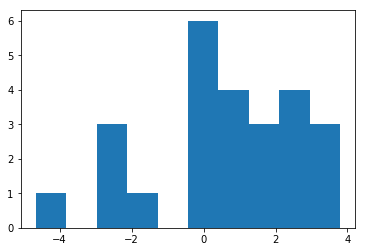

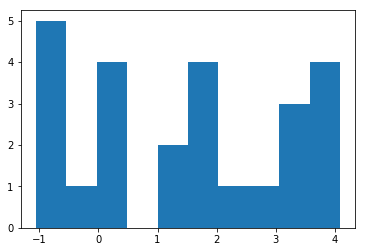

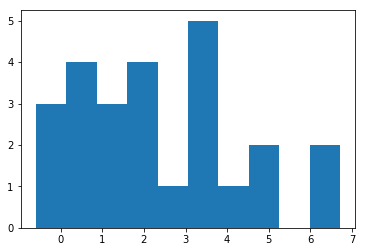

[ 0.50374439  1.46984583  2.37327743  0.40901457 -0.63370215 -2.40621915]
Training epoch 300
Iter: 300
D loss: 0.001742
G_loss: 0.003733
()
Training epoch 400
Iter: 400
D loss: 0.001585
G_loss: 0.003262
()
Training epoch 500
Iter: 500
D loss: 0.001436
G_loss: 0.003032
()


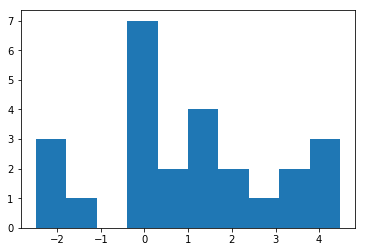

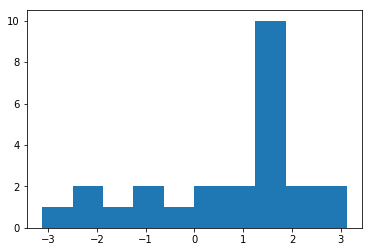

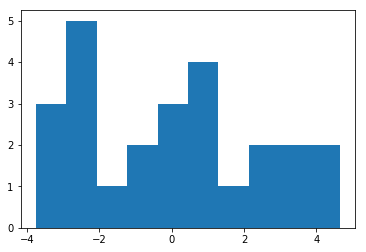

[ 0.97690086  0.74535278 -0.03821228  0.35582101  0.40800684 -0.81868292]
Training epoch 600
Iter: 600
D loss: 0.001321
G_loss: 0.003362
()
Training epoch 700
Iter: 700
D loss: 0.001224
G_loss: 0.002792
()


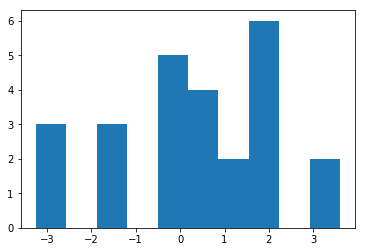

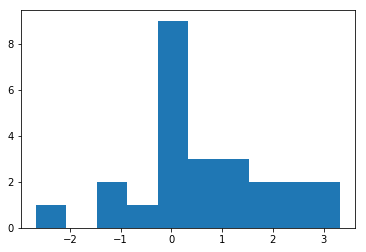

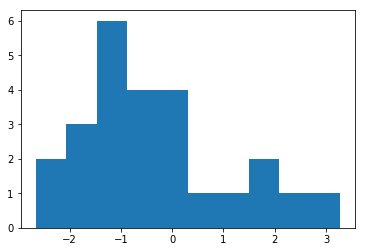

[ 0.32566826  0.60846113 -0.41089908  0.22424686  0.19168964  0.28028495]
Training epoch 800
Iter: 800
D loss: 0.001153
G_loss: 0.002754
()
Training epoch 900
Iter: 900
D loss: 0.001072
G_loss: 0.002674
()
Training epoch 1000
Iter: 1000
D loss: 0.001007
G_loss: 0.002604
()


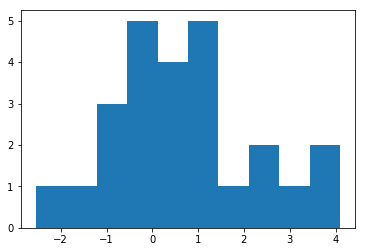

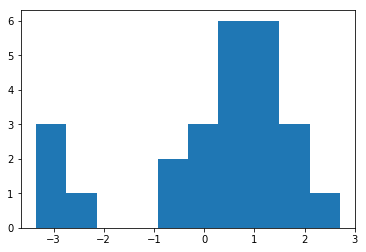

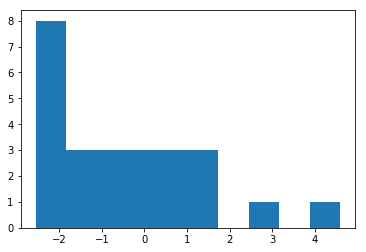

[ 0.66194117  0.24791424 -0.44548136 -1.21305082  0.24110082 -0.63373192]
Training epoch 1100
Iter: 1100
D loss: 0.0009125
G_loss: 0.002448
()
Training epoch 1200
Iter: 1200
D loss: 0.0008421
G_loss: 0.002514
()


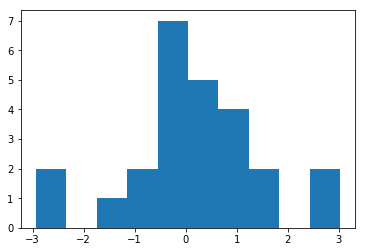

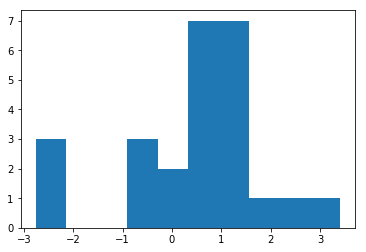

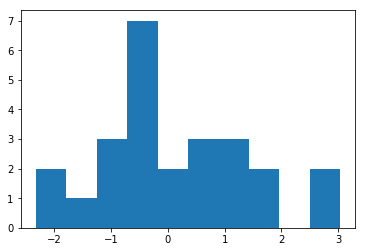

[ 0.1719849   0.46353679  0.10548874 -0.36090911 -0.12152362 -0.35227334]
Training epoch 1300
Iter: 1300
D loss: 0.0007996
G_loss: 0.002422
()
Training epoch 1400
Iter: 1400
D loss: 0.0007498
G_loss: 0.002323
()
Training epoch 1500
Iter: 1500
D loss: 0.0006943
G_loss: 0.00229
()


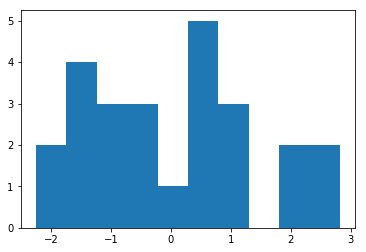

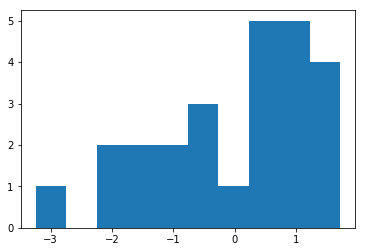

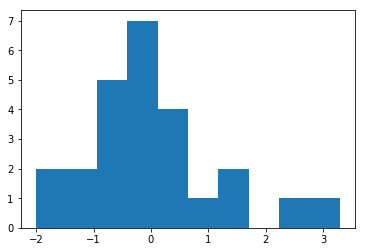

[ 0.01755443  0.00819115  0.02696799 -0.28807307 -0.15488456  0.56766374]
Training epoch 1600
Iter: 1600
D loss: 0.0006358
G_loss: 0.002233
()
Training epoch 1700
Iter: 1700
D loss: 0.0005914
G_loss: 0.002186
()


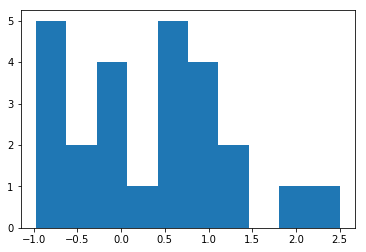

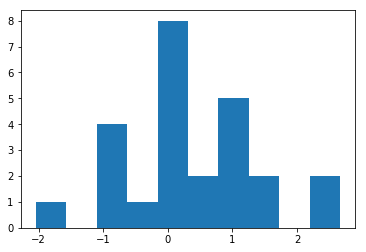

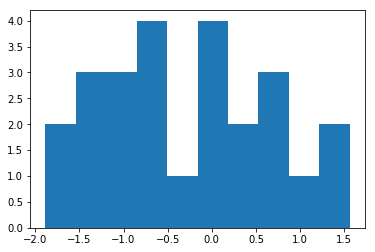

[ 0.33013765  0.34231978 -0.29681926 -0.71637405  0.10694006 -0.53179841]
Training epoch 1800
Iter: 1800
D loss: 0.0005509
G_loss: 0.002121
()
Training epoch 1900
Iter: 1900
D loss: 0.0004898
G_loss: 0.002145
()
Training epoch 2000
Iter: 2000
D loss: 0.0004495
G_loss: 0.00211
()


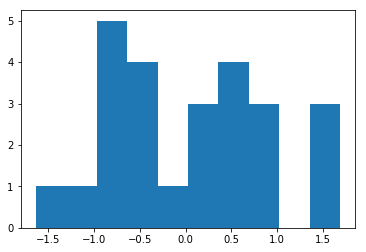

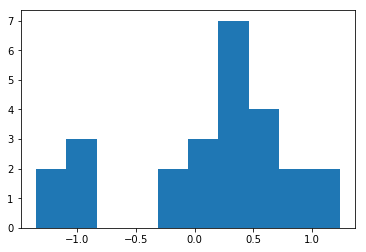

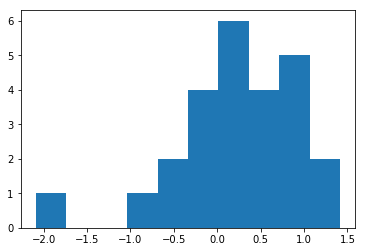

[ 0.03797516  0.11547848  0.2212473  -0.44025259 -0.42015911 -0.04892565]
Training epoch 2100
Iter: 2100
D loss: 0.0004073
G_loss: 0.002064
()
Training epoch 2200
Iter: 2200
D loss: 0.0003728
G_loss: 0.002034
()


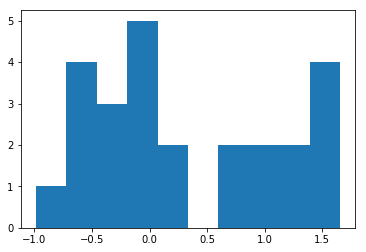

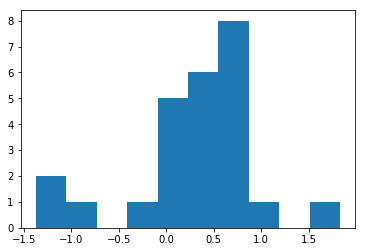

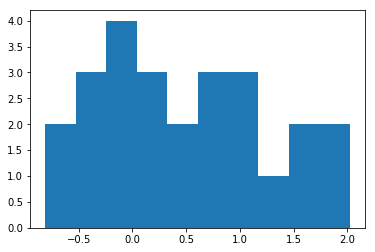

[ 0.3443476   0.29749784  0.48398244 -0.19892639 -0.68835528  0.15115212]
Training epoch 2300
Iter: 2300
D loss: 0.0003303
G_loss: 0.002044
()
Training epoch 2400
Iter: 2400
D loss: 0.0003042
G_loss: 0.002012
()
Training epoch 2500
Iter: 2500
D loss: 0.000278
G_loss: 0.002023
()


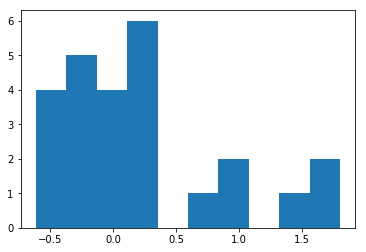

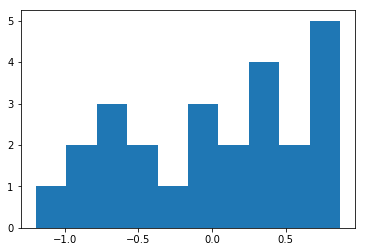

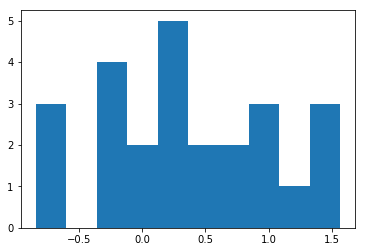

[ 0.22084659  0.02430977  0.36211188 -0.26166268 -0.42208949  0.05686089]
Training epoch 2600
Iter: 2600
D loss: 0.0002559
G_loss: 0.001994
()
Training epoch 2700
Iter: 2700
D loss: 0.0002266
G_loss: 0.001994
()


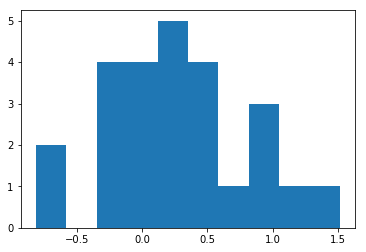

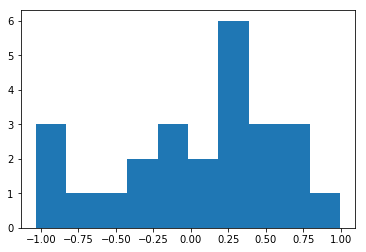

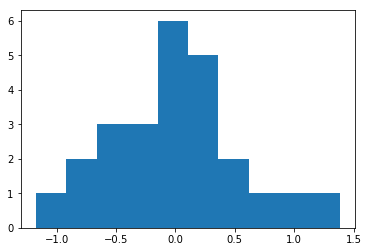

[ 0.24921368  0.0370458  -0.01167681 -0.01143589 -0.45844945  0.22457447]
Training epoch 2800
Iter: 2800
D loss: 0.0002026
G_loss: 0.002069
()
Training epoch 2900
Iter: 2900
D loss: 0.0001815
G_loss: 0.002248
()
Training epoch 3000
Iter: 3000
D loss: 0.0001603
G_loss: 0.001964
()


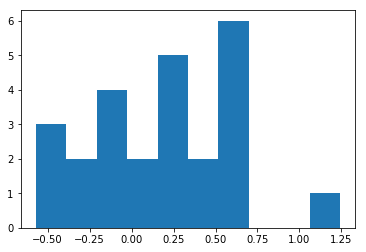

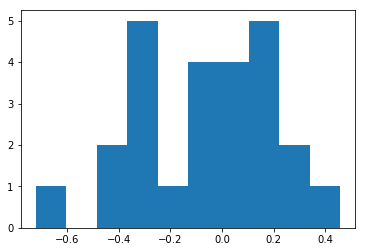

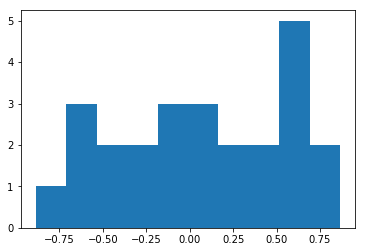

[ 0.20100868 -0.06481661  0.07001519  0.04783863 -0.44800414  0.13787122]
Training epoch 3100
Iter: 3100
D loss: 0.0001485
G_loss: 0.002056
()
Training epoch 3200
Iter: 3200
D loss: 0.0001292
G_loss: 0.002002
()


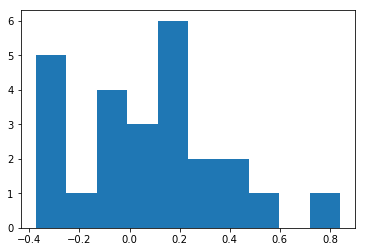

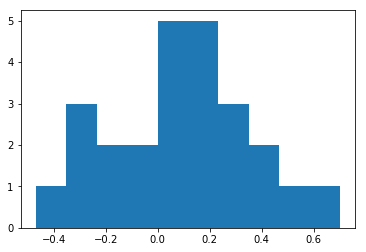

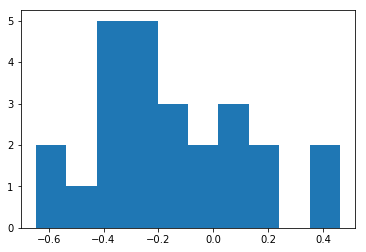

[ 0.06273696  0.08910687 -0.15874202 -0.03058642 -0.32459177  0.00130104]
Training epoch 3300
Iter: 3300
D loss: 0.0001154
G_loss: 0.001998
()
Training epoch 3400
Iter: 3400
D loss: 0.0001019
G_loss: 0.001962
()
Training epoch 3500
Iter: 3500
D loss: 9.316e-05
G_loss: 0.002012
()


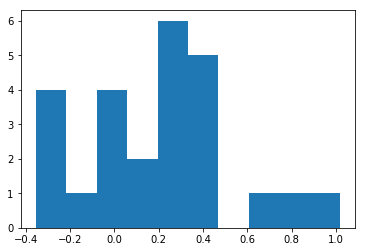

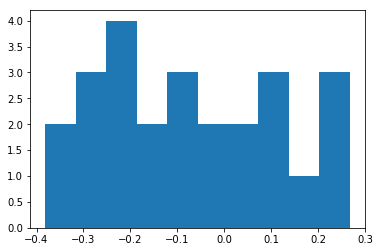

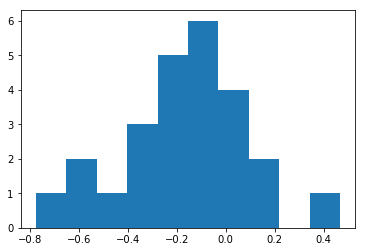

[ 0.19821597 -0.07127575 -0.16747215  0.26343271 -0.31080765 -0.02627989]
Training epoch 3600
Iter: 3600
D loss: 8.325e-05
G_loss: 0.001933
()
Training epoch 3700
Iter: 3700
D loss: 7.893e-05
G_loss: 0.00196
()


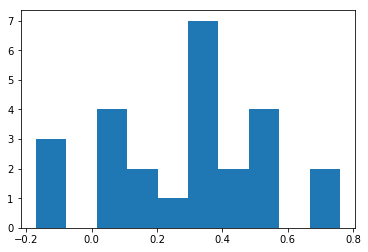

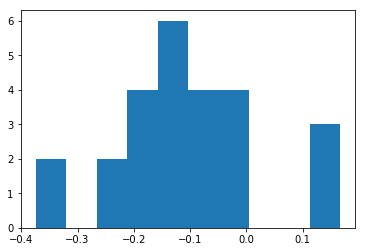

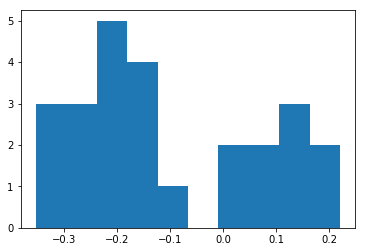

[ 0.28468861 -0.10637567 -0.101933    0.27993487 -0.41784797 -0.03766773]
Training epoch 3800
Iter: 3800
D loss: 7.253e-05
G_loss: 0.001969
()
Training epoch 3900
Iter: 3900
D loss: 7e-05
G_loss: 0.001971
()
Training epoch 4000
Iter: 4000
D loss: 6.967e-05
G_loss: 0.001997
()


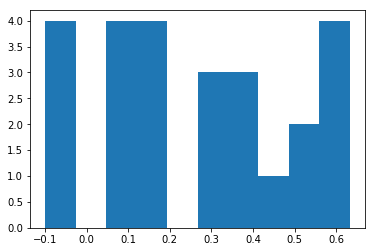

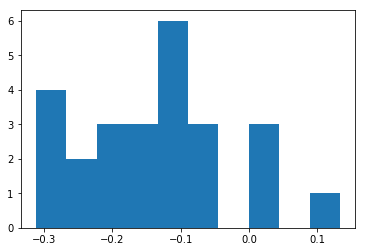

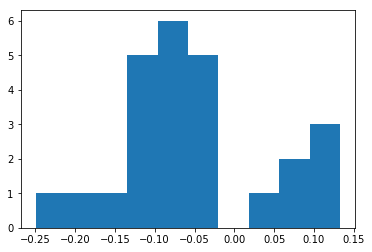

[ 0.26492298 -0.13434226 -0.05392142  0.23350424 -0.37431904 -0.02701962]
Training epoch 4100
Iter: 4100
D loss: 6.744e-05
G_loss: 0.001992
()
Training epoch 4200
Iter: 4200
D loss: 6.642e-05
G_loss: 0.002009
()


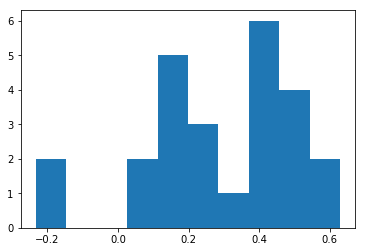

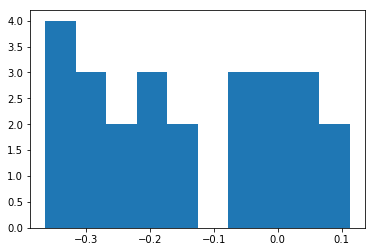

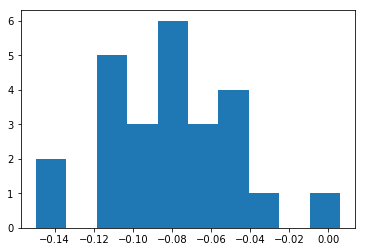

[ 0.29202106 -0.14056174 -0.08139467  0.33679112 -0.33305322  0.00563216]
Training epoch 4300
Iter: 4300
D loss: 6.237e-05
G_loss: 0.001987
()
Training epoch 4400
Iter: 4400
D loss: 6.233e-05
G_loss: 0.002001
()
Training epoch 4500
Iter: 4500
D loss: 5.955e-05
G_loss: 0.001964
()


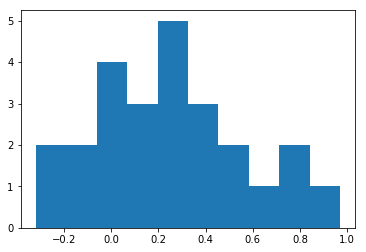

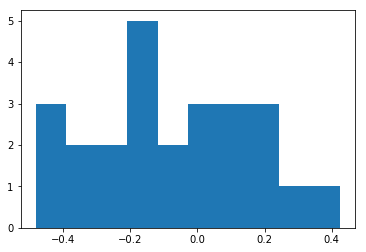

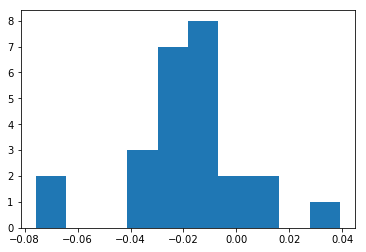

[ 0.24508346 -0.0716595  -0.01859467  0.25754987 -0.30948092 -0.0014952 ]
Training epoch 4600
Iter: 4600
D loss: 6.06e-05
G_loss: 0.001969
()
Training epoch 4700
Iter: 4700
D loss: 5.702e-05
G_loss: 0.00196
()


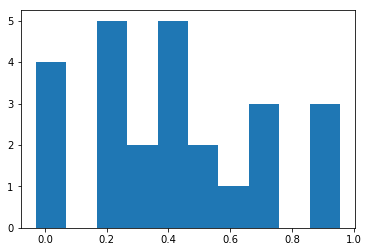

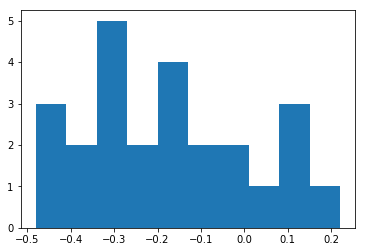

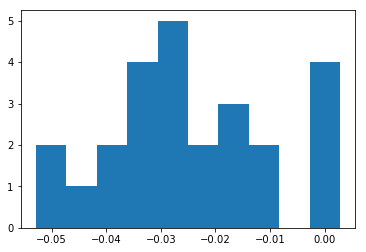

[ 0.4149332  -0.17575215 -0.02426835  0.42274114 -0.39075621 -0.00132439]
Training epoch 4800
Iter: 4800
D loss: 5.733e-05
G_loss: 0.001962
()
Training epoch 4900
Iter: 4900
D loss: 5.999e-05
G_loss: 0.001969
()
Training epoch 5000
Iter: 5000
D loss: 5.643e-05
G_loss: 0.001966
()


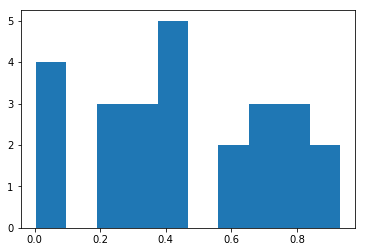

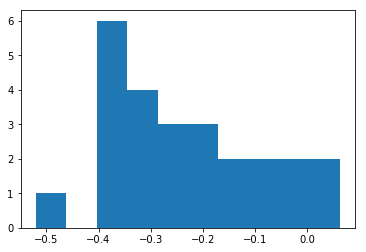

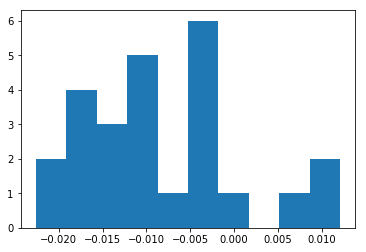

[  4.56754926e-01  -2.29392964e-01  -8.34168444e-03   4.61782601e-01
  -4.18205273e-01  -1.85422016e-04]
Training epoch 5100
Iter: 5100
D loss: 5.619e-05
G_loss: 0.001944
()
Training epoch 5200
Iter: 5200
D loss: 5.702e-05
G_loss: 0.00199
()


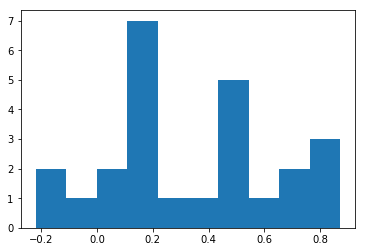

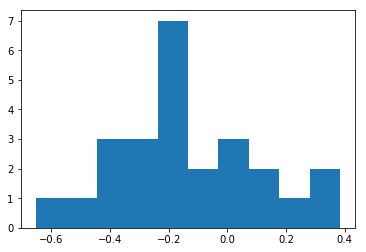

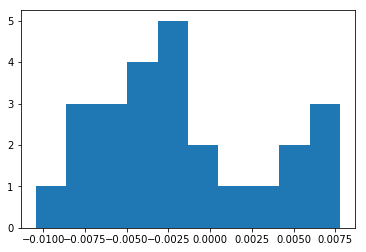

[ 0.33126692 -0.12410548 -0.00174574  0.35715007 -0.34221191 -0.00206947]
Training epoch 5300
Iter: 5300
D loss: 5.619e-05
G_loss: 0.001984
()
Training epoch 5400
Iter: 5400
D loss: 5.502e-05
G_loss: 0.001991
()
Training epoch 5500
Iter: 5500
D loss: 5.346e-05
G_loss: 0.00198
()


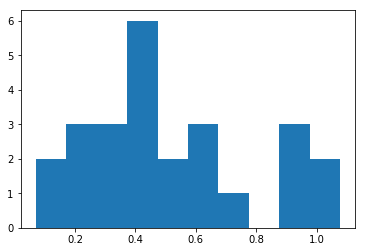

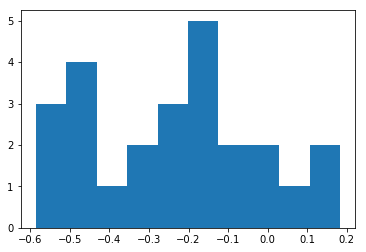

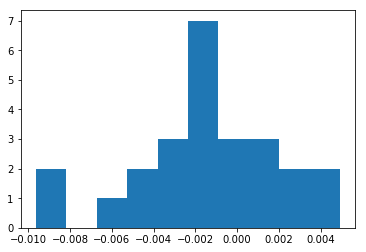

[ 0.52295627 -0.2357863  -0.00138458  0.53891497 -0.46172273  0.00061695]
Training epoch 5600
Iter: 5600
D loss: 5.449e-05
G_loss: 0.00198
()
Training epoch 5700
Iter: 5700
D loss: 5.28e-05
G_loss: 0.001981
()


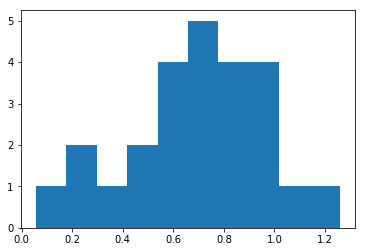

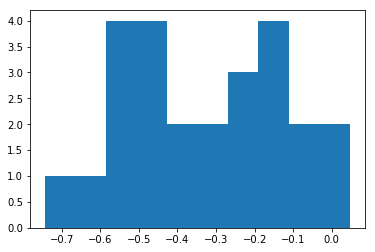

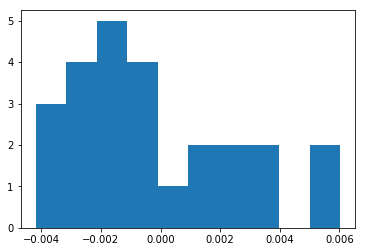

[  7.00641509e-01  -3.30161730e-01  -2.24950716e-04   7.18918182e-01
  -5.64122780e-01   1.41678537e-03]
Training epoch 5800
Iter: 5800
D loss: 5.487e-05
G_loss: 0.001945
()
Training epoch 5900
Iter: 5900
D loss: 5.021e-05
G_loss: 0.001901
()
Training epoch 6000
Iter: 6000
D loss: 4.961e-05
G_loss: 0.001983
()


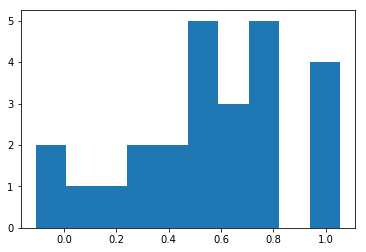

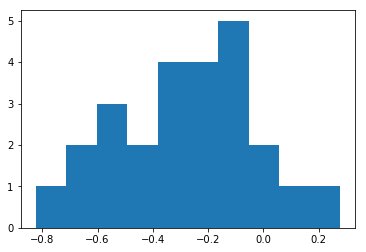

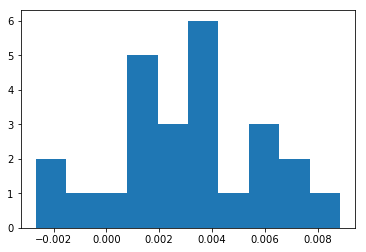

[ 0.56527687 -0.26786018  0.00303587  0.57630532 -0.51683234  0.00306951]
Training epoch 6100
Iter: 6100
D loss: 5.211e-05
G_loss: 0.001912
()
Training epoch 6200
Iter: 6200
D loss: 4.955e-05
G_loss: 0.001947
()


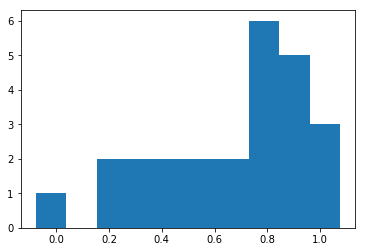

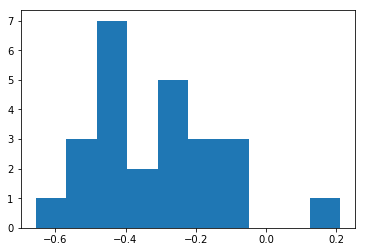

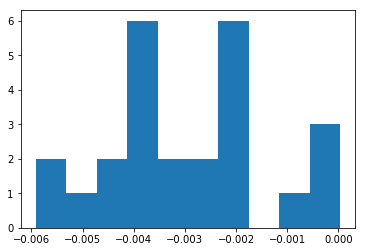

[ 0.66803172 -0.32188054 -0.00295359  0.67133882 -0.56880457  0.00108353]
Training epoch 6300
Iter: 6300
D loss: 4.983e-05
G_loss: 0.001978
()
Training epoch 6400
Iter: 6400
D loss: 5.175e-05
G_loss: 0.001962
()
Training epoch 6500
Iter: 6500
D loss: 5.232e-05
G_loss: 0.00197
()


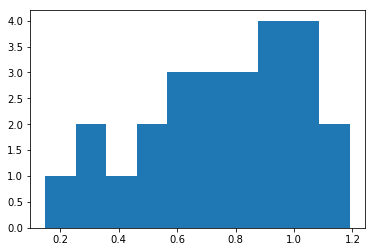

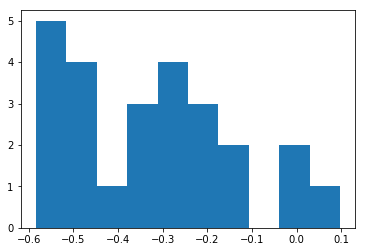

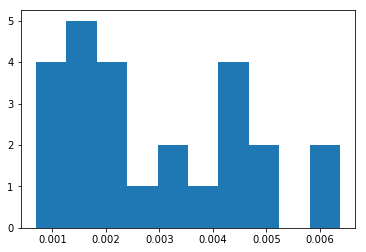

[ 0.74413863 -0.32062936  0.00288291  0.7534988  -0.57127667  0.00179596]
Training epoch 6600
Iter: 6600
D loss: 4.99e-05
G_loss: 0.001975
()
Training epoch 6700
Iter: 6700
D loss: 4.902e-05
G_loss: 0.001897
()


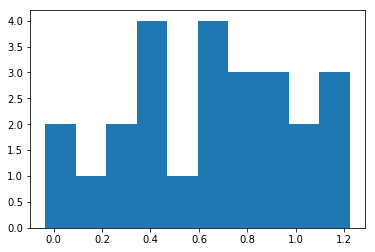

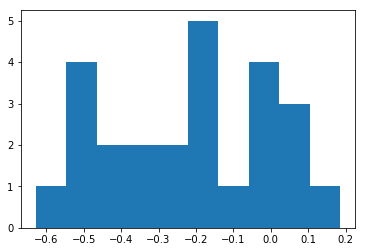

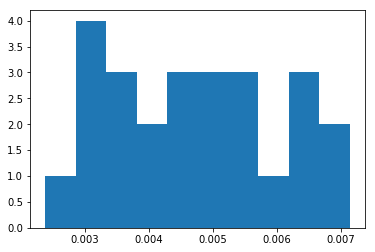

[ 0.65279754 -0.21698909  0.00473387  0.66032113 -0.53546125  0.00242769]
Training epoch 6800
Iter: 6800
D loss: 4.906e-05
G_loss: 0.001896
()
Training epoch 6900
Iter: 6900
D loss: 4.615e-05
G_loss: 0.001801
()
Training epoch 7000
Iter: 7000
D loss: 4.924e-05
G_loss: 0.001894
()


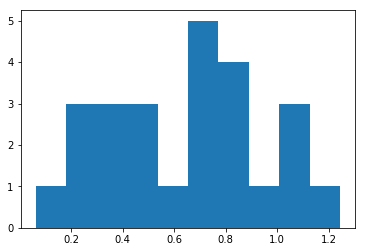

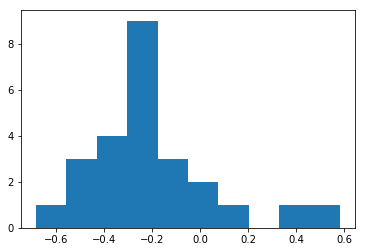

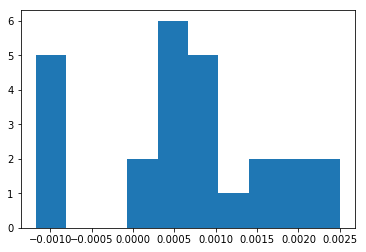

[  6.49833743e-01  -2.11850110e-01   5.94860940e-04   6.50223750e-01
  -5.95167276e-01   2.82340440e-03]
Training epoch 7100
Iter: 7100
D loss: 4.423e-05
G_loss: 0.001839
()
Training epoch 7200
Iter: 7200
D loss: 4.734e-05
G_loss: 0.001826
()


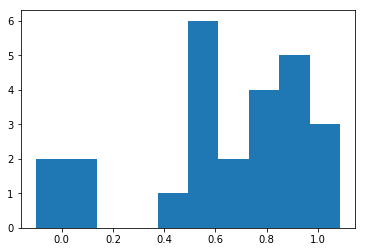

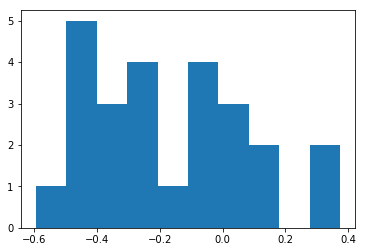

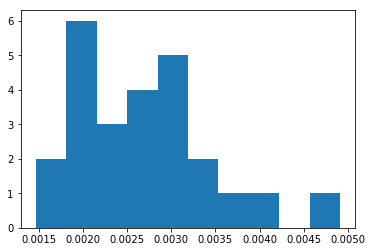

[ 0.64271872 -0.17246251  0.00270319  0.64409447 -0.56952219  0.00369157]
Training epoch 7300
Iter: 7300
D loss: 4.88e-05
G_loss: 0.001815
()
Training epoch 7400
Iter: 7400
D loss: 4.446e-05
G_loss: 0.001848
()
Training epoch 7500
Iter: 7500
D loss: 4.47e-05
G_loss: 0.001912
()


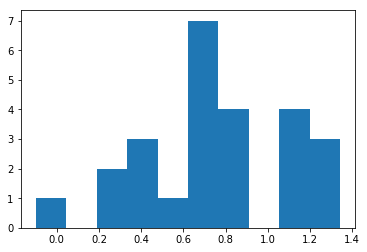

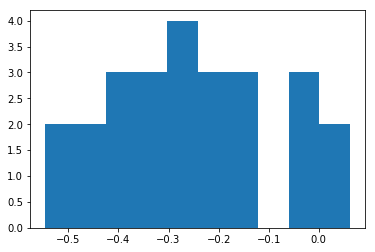

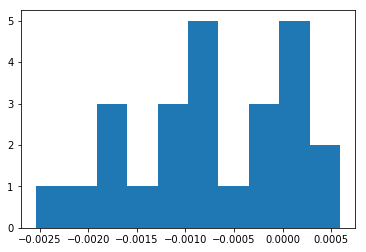

[  7.42726467e-01  -2.54807624e-01  -7.29112647e-04   7.50192626e-01
  -6.56243411e-01  -4.36462883e-03]
Training epoch 7600
Iter: 7600
D loss: 4.272e-05
G_loss: 0.001908
()
Training epoch 7700
Iter: 7700
D loss: 4.469e-05
G_loss: 0.001848
()


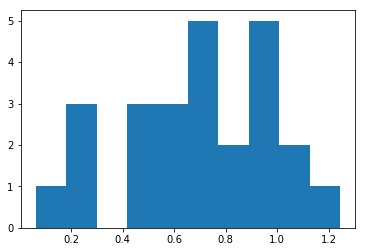

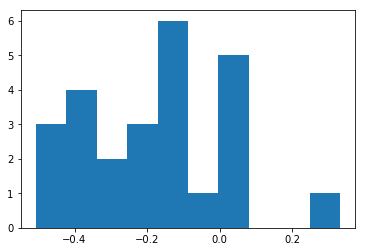

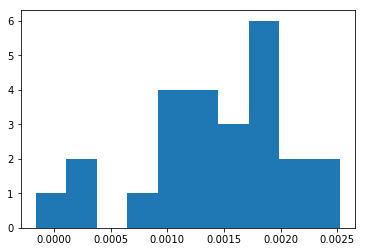

[ 0.69031912 -0.17999618  0.00143775  0.69878917 -0.62729197  0.00322886]
Training epoch 7800
Iter: 7800
D loss: 4.397e-05
G_loss: 0.001936
()
Training epoch 7900
Iter: 7900
D loss: 4.405e-05
G_loss: 0.00186
()
Training epoch 8000
Iter: 8000
D loss: 4.303e-05
G_loss: 0.001826
()


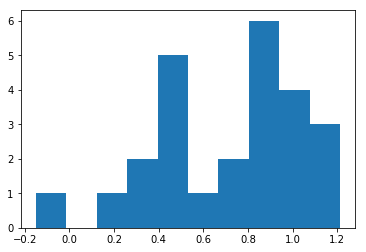

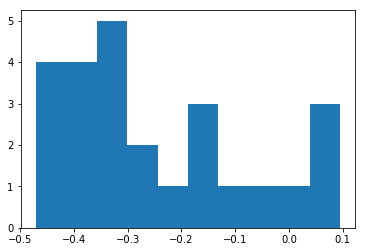

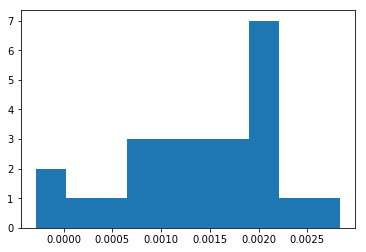

[ 0.71996165 -0.24056366  0.00138922  0.72399397 -0.60387034 -0.00326339]
Training epoch 8100
Iter: 8100
D loss: 4.28e-05
G_loss: 0.001884
()
Training epoch 8200
Iter: 8200
D loss: 4.268e-05
G_loss: 0.001887
()


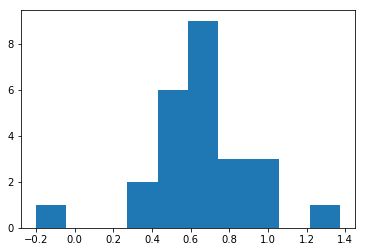

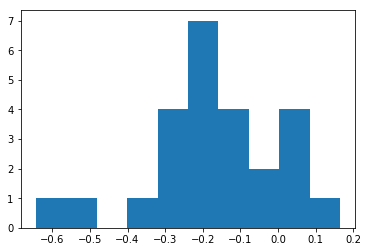

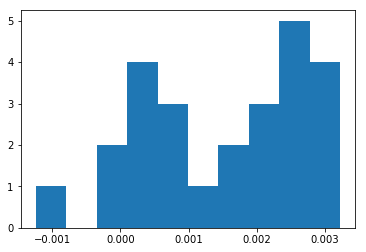

[ 0.63999896 -0.1683489   0.00153941  0.64800985 -0.59919399  0.00437451]
Training epoch 8300
Iter: 8300
D loss: 4.563e-05
G_loss: 0.001856
()
Training epoch 8400
Iter: 8400
D loss: 4.165e-05
G_loss: 0.00184
()
Training epoch 8500
Iter: 8500
D loss: 4.448e-05
G_loss: 0.001949
()


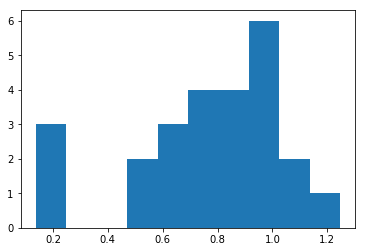

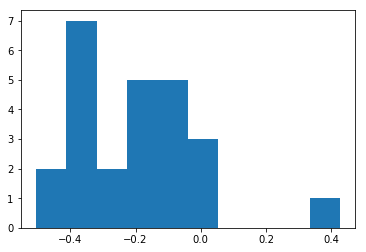

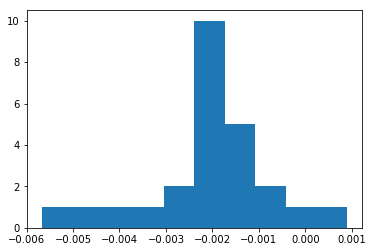

[ 0.76161291 -0.19287041 -0.00204158  0.77029781 -0.64277045  0.00301388]
Training epoch 8600
Iter: 8600
D loss: 4.01e-05
G_loss: 0.001893
()
Training epoch 8700
Iter: 8700
D loss: 4.298e-05
G_loss: 0.001942
()


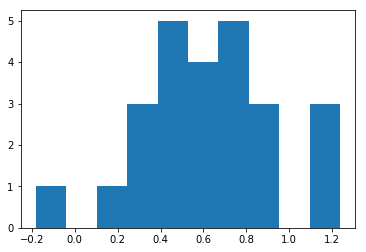

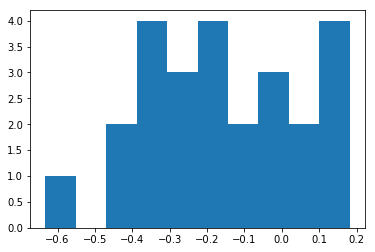

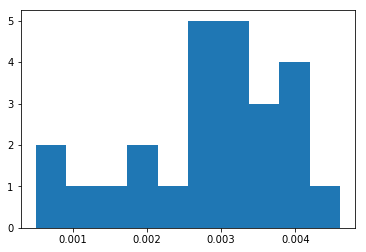

[  6.20299205e-01  -1.64347362e-01   2.81163059e-03   6.31140757e-01
  -5.57044538e-01   2.22706016e-04]
Training epoch 8800
Iter: 8800
D loss: 4.009e-05
G_loss: 0.001957
()
Training epoch 8900
Iter: 8900
D loss: 4.002e-05
G_loss: 0.001985
()
Training epoch 9000
Iter: 9000
D loss: 4.151e-05
G_loss: 0.001963
()


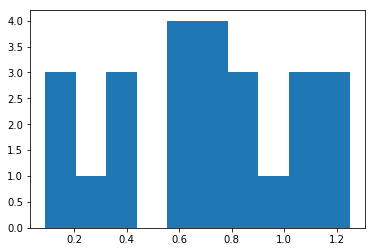

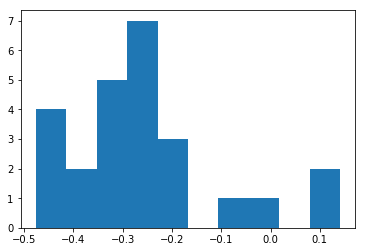

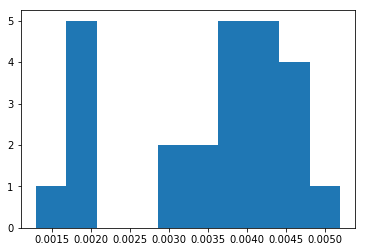

[  7.00266577e-01  -2.56715243e-01   3.50246450e-03   7.10199511e-01
  -5.61134336e-01  -2.59761361e-05]
Training epoch 9100
Iter: 9100
D loss: 3.995e-05
G_loss: 0.001981
()
Training epoch 9200
Iter: 9200
D loss: 3.945e-05
G_loss: 0.00207
()


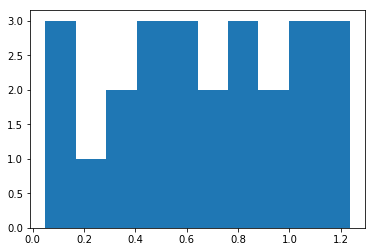

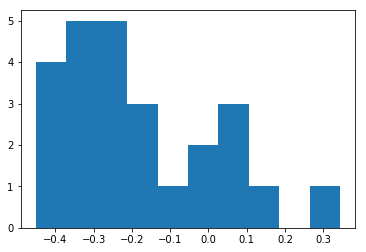

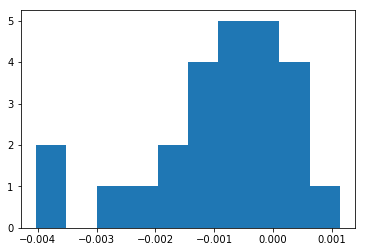

[ 0.67725375 -0.1827135  -0.00092297  0.6874923  -0.56952721  0.00130984]
Training epoch 9300
Iter: 9300
D loss: 4.165e-05
G_loss: 0.001996
()
Training epoch 9400
Iter: 9400
D loss: 3.556e-05
G_loss: 0.001986
()
Training epoch 9500
Iter: 9500
D loss: 3.562e-05
G_loss: 0.001978
()


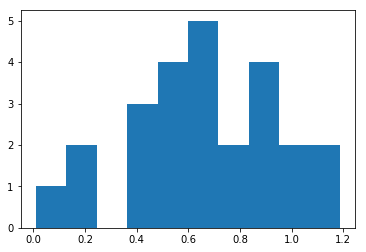

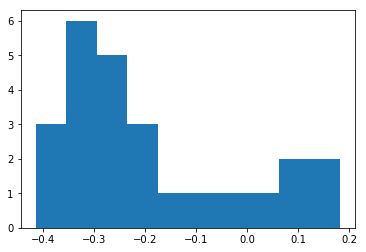

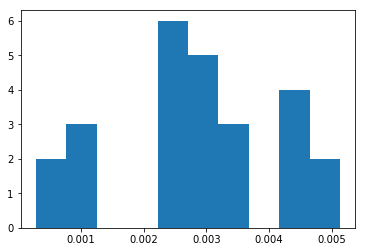

[ 0.67221233 -0.19065361  0.00279857  0.6833674  -0.58384203  0.00215137]
Training epoch 9600
Iter: 9600
D loss: 4.007e-05
G_loss: 0.001966
()
Training epoch 9700
Iter: 9700
D loss: 3.91e-05
G_loss: 0.001964
()


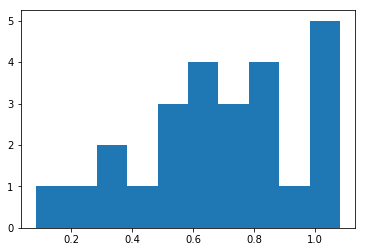

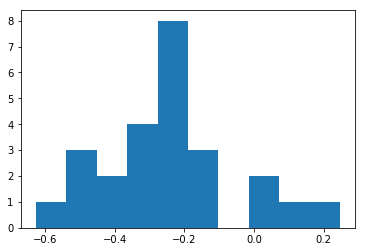

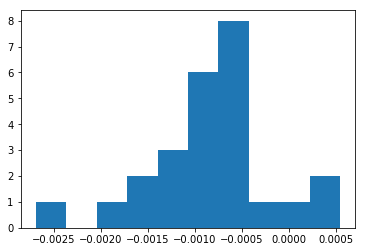

[ 0.68923109 -0.25218568 -0.00081978  0.69635346 -0.59099048  0.00162533]
Training epoch 9800
Iter: 9800
D loss: 4.185e-05
G_loss: 0.00198
()
Training epoch 9900
Iter: 9900
D loss: 3.713e-05
G_loss: 0.002006
()
Training epoch 10000
Iter: 10000
D loss: 3.982e-05
G_loss: 0.001974
()


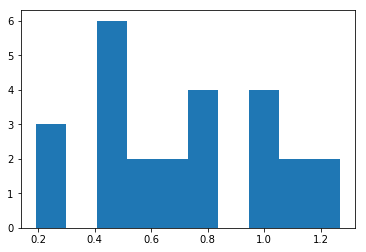

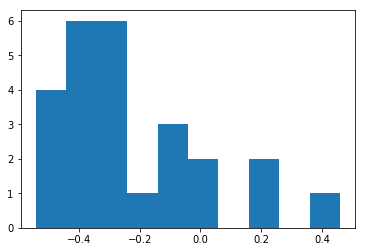

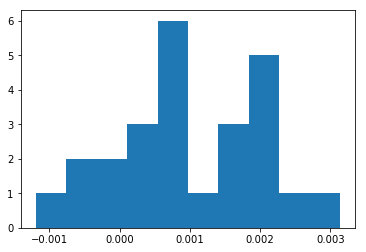

[ 0.7130561  -0.22841887  0.00102353  0.72261295 -0.61260041 -0.00223948]
Training epoch 10100
Iter: 10100
D loss: 3.786e-05
G_loss: 0.001991
()
Training epoch 10200
Iter: 10200
D loss: 3.731e-05
G_loss: 0.001921
()


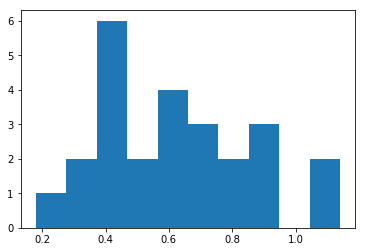

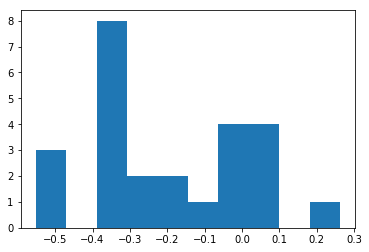

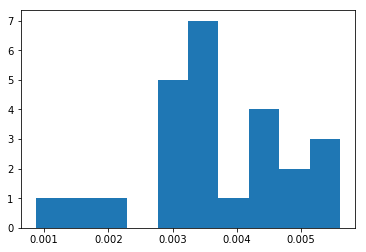

[  6.28115476e-01  -1.99431357e-01   3.64134713e-03   6.33457012e-01
  -5.55234177e-01   5.39618873e-04]
Training epoch 10300
Iter: 10300
D loss: 3.765e-05
G_loss: 0.00196
()
Training epoch 10400
Iter: 10400
D loss: 3.69e-05
G_loss: 0.001966
()
Training epoch 10500
Iter: 10500
D loss: 3.572e-05
G_loss: 0.001955
()


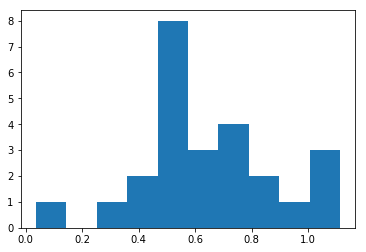

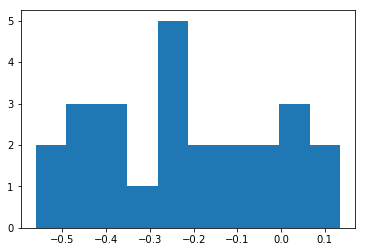

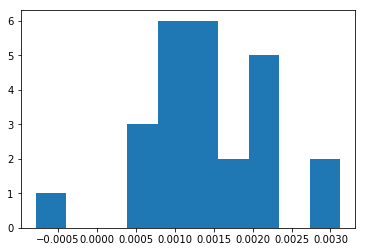

[ 0.64726445 -0.21422696  0.00144995  0.65382033 -0.57810966 -0.00142793]
Training epoch 10600
Iter: 10600
D loss: 3.694e-05
G_loss: 0.001948
()
Training epoch 10700
Iter: 10700
D loss: 3.558e-05
G_loss: 0.001989
()


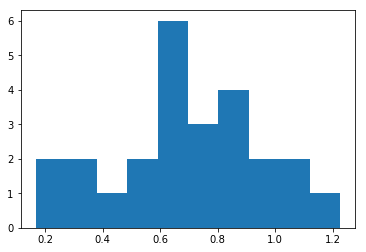

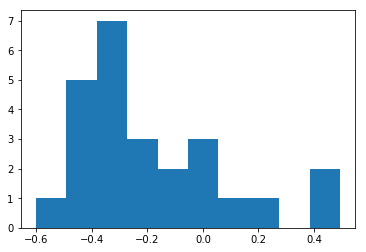

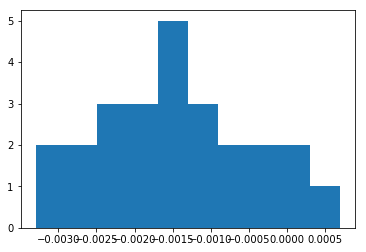

[  7.01902583e-01  -1.88946679e-01  -1.46915806e-03   7.04071431e-01
  -5.88982382e-01  -3.49193569e-04]
Training epoch 10800
Iter: 10800
D loss: 3.5e-05
G_loss: 0.001984
()
Training epoch 10900
Iter: 10900
D loss: 3.607e-05
G_loss: 0.001963
()
Training epoch 11000
Iter: 11000
D loss: 3.435e-05
G_loss: 0.001941
()


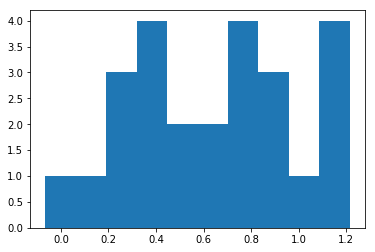

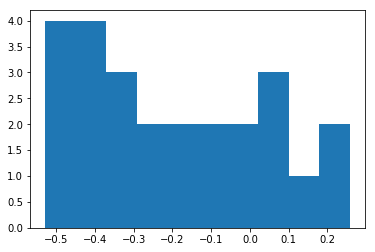

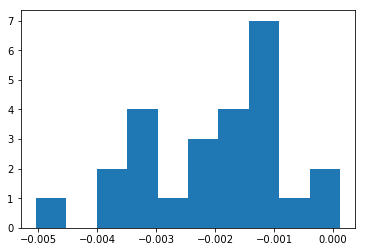

[  6.51881380e-01  -1.98653313e-01  -1.98877073e-03   6.55669186e-01
  -5.74367244e-01  -2.14667427e-04]
Training epoch 11100
Iter: 11100
D loss: 3.62e-05
G_loss: 0.001952
()
Training epoch 11200
Iter: 11200
D loss: 3.578e-05
G_loss: 0.001907
()


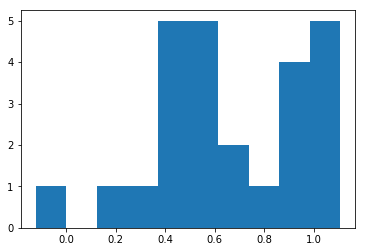

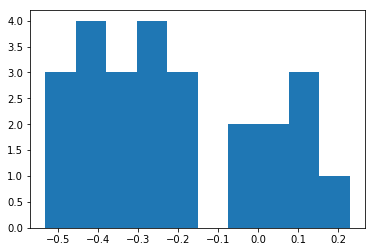

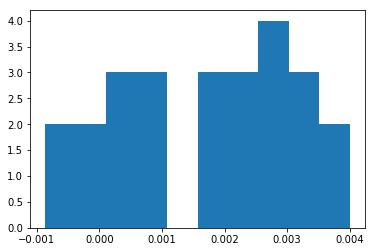

[ 0.65848271 -0.21088065  0.00168999  0.66028414 -0.56665413  0.00215443]
Training epoch 11300
Iter: 11300
D loss: 3.581e-05
G_loss: 0.001956
()
Training epoch 11400
Iter: 11400
D loss: 3.603e-05
G_loss: 0.002001
()
Training epoch 11500
Iter: 11500
D loss: 3.72e-05
G_loss: 0.001969
()


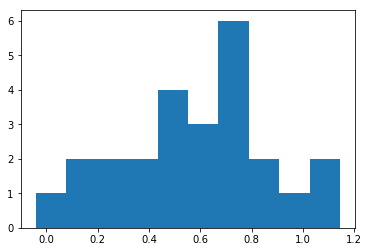

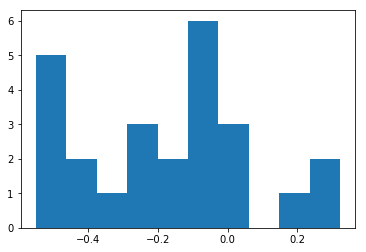

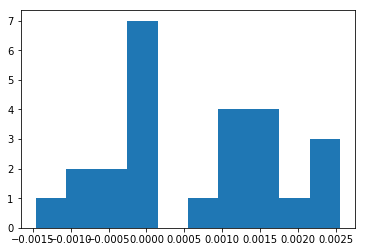

[ 0.59656443 -0.17739797  0.00063028  0.59580167 -0.53255016 -0.00142338]
Training epoch 11600
Iter: 11600
D loss: 3.466e-05
G_loss: 0.00195
()
Training epoch 11700
Iter: 11700
D loss: 3.716e-05
G_loss: 0.001986
()


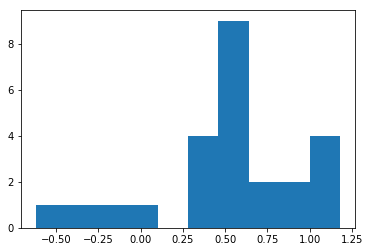

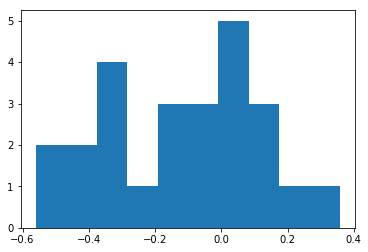

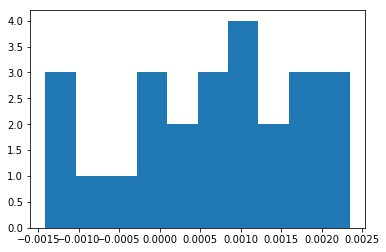

[  5.12587488e-01  -1.12961938e-01   6.28758032e-04   5.13670257e-01
  -5.29892017e-01  -4.72825381e-04]
Training epoch 11800
Iter: 11800
D loss: 3.527e-05
G_loss: 0.001981
()
Training epoch 11900
Iter: 11900
D loss: 3.758e-05
G_loss: 0.00198
()
Training epoch 12000
Iter: 12000
D loss: 3.418e-05
G_loss: 0.00195
()


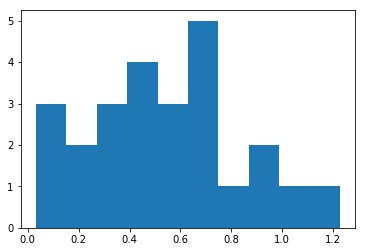

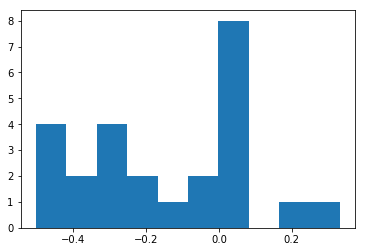

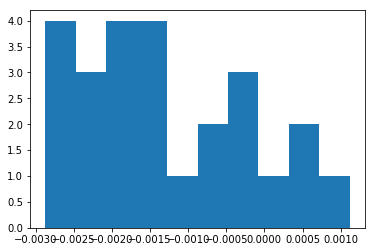

[ 0.54471205 -0.14615051 -0.00128432  0.54322227 -0.53568896 -0.00085998]
Training epoch 12100
Iter: 12100
D loss: 3.365e-05
G_loss: 0.001929
()
Training epoch 12200
Iter: 12200
D loss: 3.56e-05
G_loss: 0.001953
()


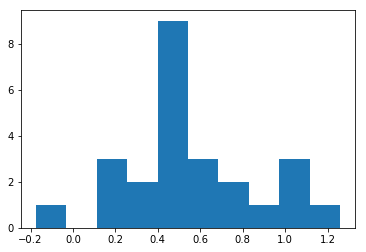

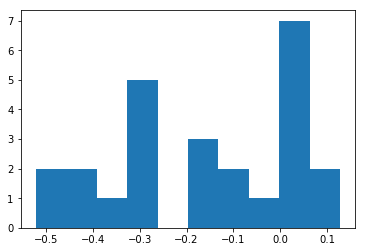

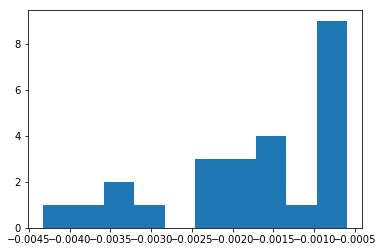

[ 0.56399198 -0.16477099 -0.00174388  0.56195369 -0.53592614  0.00107865]
Training epoch 12300
Iter: 12300
D loss: 3.501e-05
G_loss: 0.001967
()
Training epoch 12400
Iter: 12400
D loss: 3.623e-05
G_loss: 0.001969
()
Training epoch 12500
Iter: 12500
D loss: 3.484e-05
G_loss: 0.001908
()


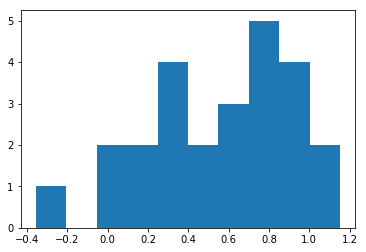

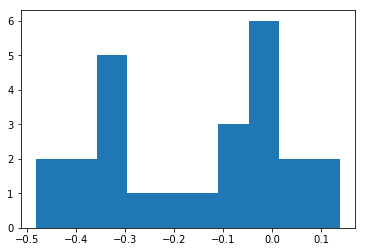

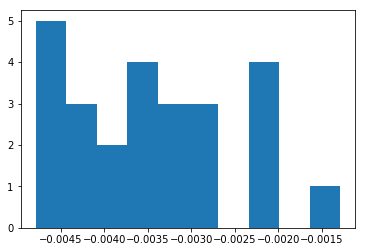

[ 0.54437518 -0.15842241 -0.00341832  0.54259862 -0.50730525  0.00201404]
Training epoch 12600
Iter: 12600
D loss: 3.559e-05
G_loss: 0.001977
()
Training epoch 12700
Iter: 12700
D loss: 3.34e-05
G_loss: 0.001926
()


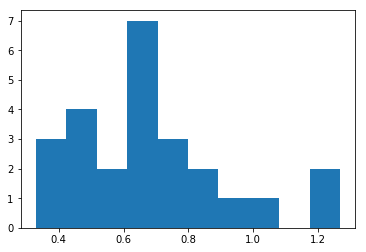

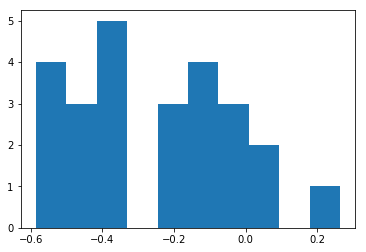

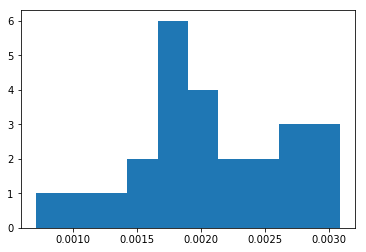

[ 0.68111297 -0.24821621  0.00205353  0.67985758 -0.59055301 -0.00377379]
Training epoch 12800
Iter: 12800
D loss: 3.19e-05
G_loss: 0.001951
()
Training epoch 12900
Iter: 12900
D loss: 3.58e-05
G_loss: 0.001979
()
Training epoch 13000
Iter: 13000
D loss: 3.198e-05
G_loss: 0.001951
()


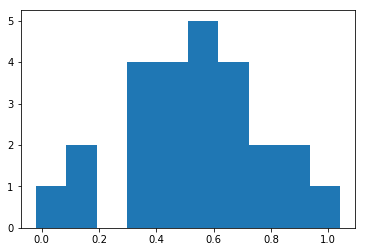

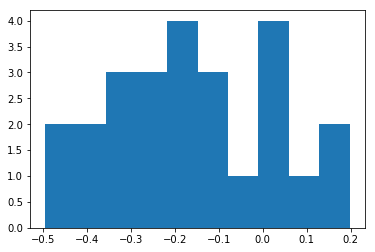

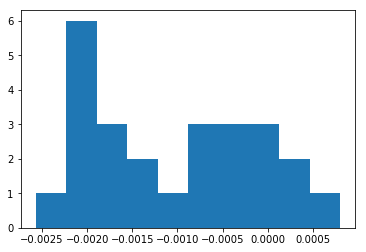

[ 0.53161164 -0.16292207 -0.00102755  0.52926005 -0.53835236  0.00110026]
Training epoch 13100
Iter: 13100
D loss: 3.517e-05
G_loss: 0.001921
()
Training epoch 13200
Iter: 13200
D loss: 3.367e-05
G_loss: 0.001887
()


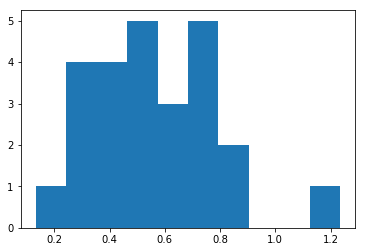

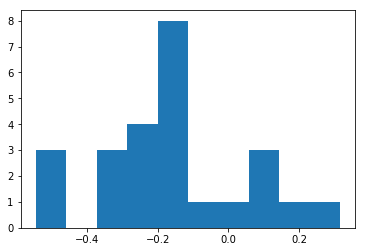

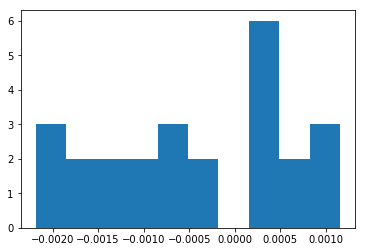

[  5.54116049e-01  -1.67571029e-01  -4.47278480e-04   5.52705746e-01
  -5.32126899e-01   1.89306942e-03]
Training epoch 13300
Iter: 13300
D loss: 3.346e-05
G_loss: 0.001955
()
Training epoch 13400
Iter: 13400
D loss: 3.368e-05
G_loss: 0.001932
()
Training epoch 13500
Iter: 13500
D loss: 3.331e-05
G_loss: 0.001901
()


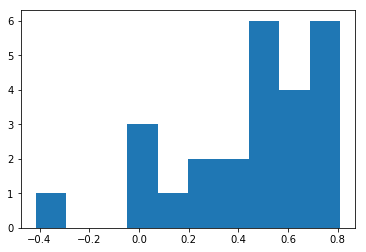

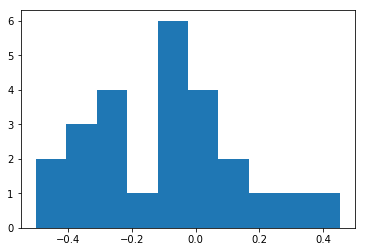

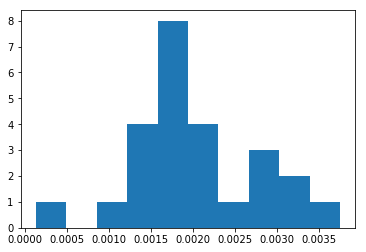

[ 0.44821588 -0.09400273  0.00206713  0.44382555 -0.50136675 -0.00168863]
Training epoch 13600
Iter: 13600
D loss: 3.404e-05
G_loss: 0.001879
()
Training epoch 13700
Iter: 13700
D loss: 3.287e-05
G_loss: 0.001934
()


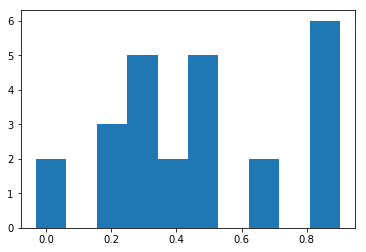

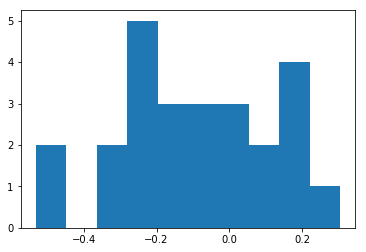

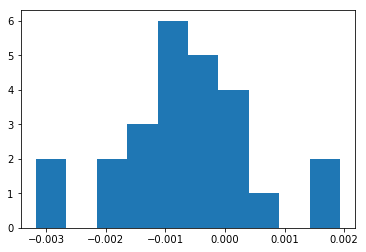

[ 0.47084506 -0.09543784 -0.00067424  0.468627   -0.55222705  0.0006137 ]
Training epoch 13800
Iter: 13800
D loss: 3.513e-05
G_loss: 0.001972
()
Training epoch 13900
Iter: 13900
D loss: 3.414e-05
G_loss: 0.001912
()
Training epoch 14000
Iter: 14000
D loss: 3.342e-05
G_loss: 0.00193
()


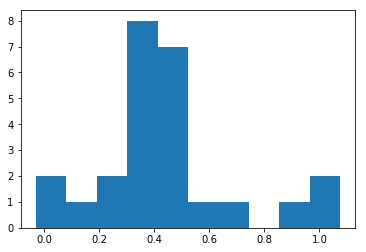

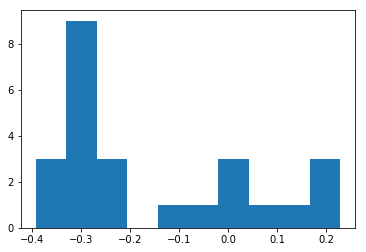

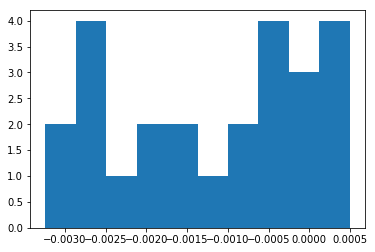

[ 0.4402624  -0.15289471 -0.00119279  0.43846952 -0.50360697 -0.00128696]
Training epoch 14100
Iter: 14100
D loss: 3.294e-05
G_loss: 0.001939
()
Training epoch 14200
Iter: 14200
D loss: 3.145e-05
G_loss: 0.00193
()


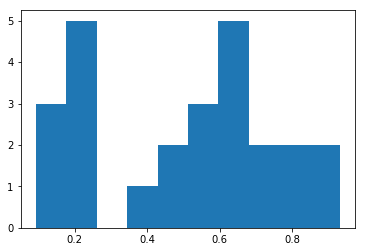

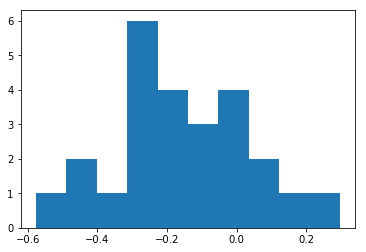

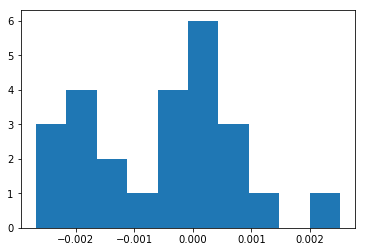

[  5.00739638e-01  -1.60750823e-01  -5.25645273e-04   4.97765493e-01
  -5.42811970e-01   2.90609631e-03]
Training epoch 14300
Iter: 14300
D loss: 3.348e-05
G_loss: 0.001904
()
Training epoch 14400
Iter: 14400
D loss: 3.249e-05
G_loss: 0.001908
()
Training epoch 14500
Iter: 14500
D loss: 3.287e-05
G_loss: 0.001955
()


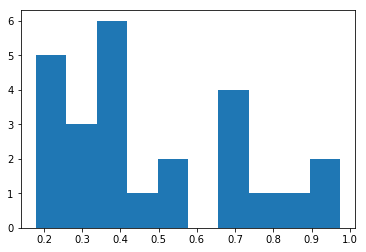

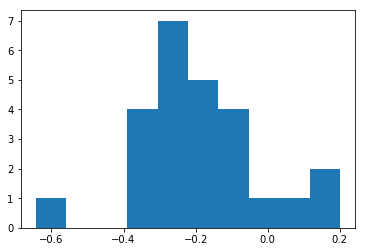

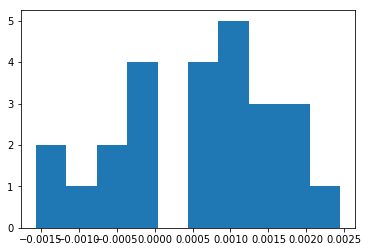

[ 0.48784546 -0.18720517  0.0005913   0.48526888 -0.53038346  0.00239072]
Training epoch 14600
Iter: 14600
D loss: 3.262e-05
G_loss: 0.001962
()
Training epoch 14700
Iter: 14700
D loss: 3.359e-05
G_loss: 0.00191
()


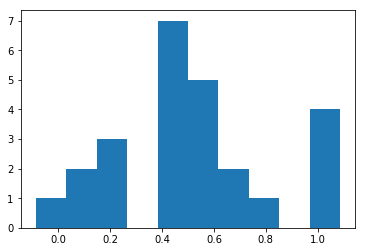

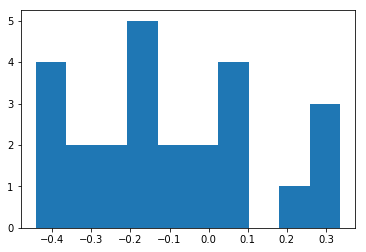

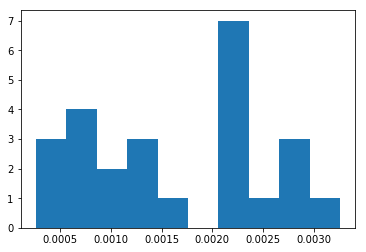

[  5.05384734e-01  -1.05816200e-01   1.65576014e-03   5.06577503e-01
  -5.49384197e-01  -2.76365447e-04]
Training epoch 14800
Iter: 14800
D loss: 2.94e-05
G_loss: 0.001855
()
Training epoch 14900
Iter: 14900
D loss: 3.348e-05
G_loss: 0.001877
()
Training epoch 15000
Iter: 15000
D loss: 3.164e-05
G_loss: 0.001945
()


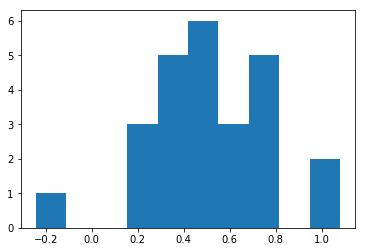

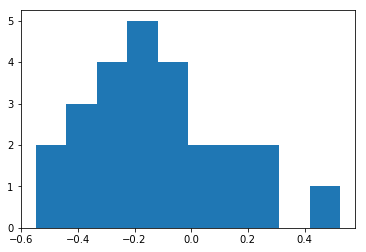

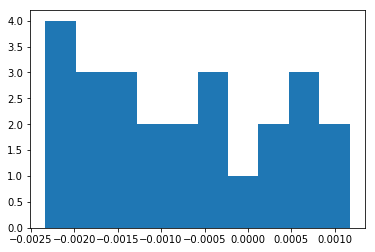

[ 0.51374343 -0.12598313 -0.00074583  0.51333578 -0.53980069 -0.00400856]
Training epoch 15100
Iter: 15100
D loss: 3.11e-05
G_loss: 0.001902
()
Training epoch 15200
Iter: 15200
D loss: 3.319e-05
G_loss: 0.001909
()


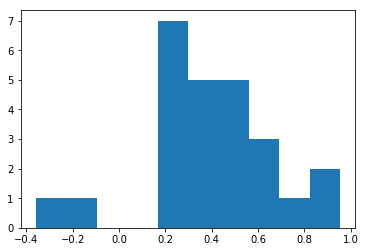

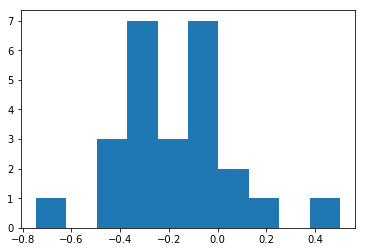

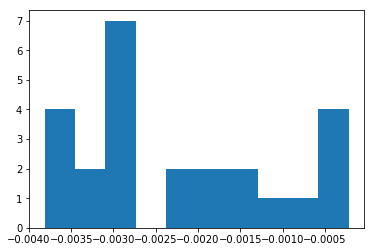

[ 0.39348972 -0.17892305 -0.00223778  0.39276398 -0.45486984 -0.00106689]
Training epoch 15300
Iter: 15300
D loss: 3.097e-05
G_loss: 0.001851
()
Training epoch 15400
Iter: 15400
D loss: 3.247e-05
G_loss: 0.001916
()
Training epoch 15500
Iter: 15500
D loss: 3.184e-05
G_loss: 0.001947
()


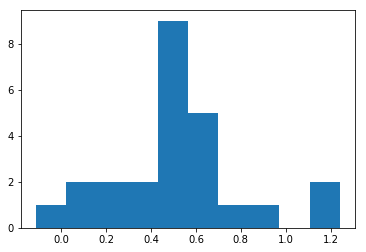

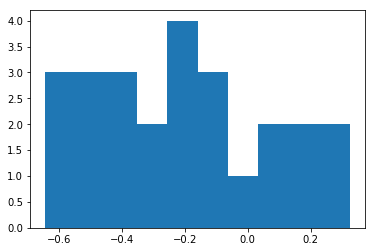

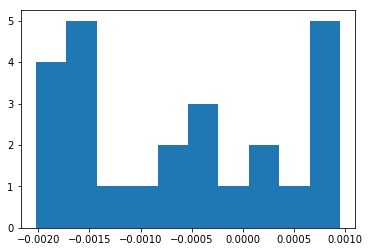

[  5.09305906e-01  -2.02461611e-01  -6.19719411e-04   5.09533921e-01
  -5.33809274e-01   1.82765857e-04]
Training epoch 15600
Iter: 15600
D loss: 3.242e-05
G_loss: 0.001925
()
Training epoch 15700
Iter: 15700
D loss: 3.123e-05
G_loss: 0.001978
()


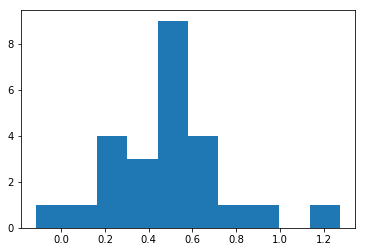

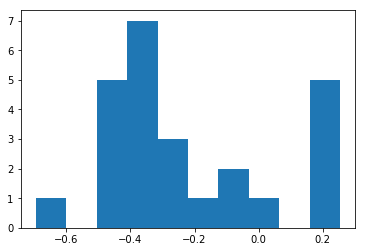

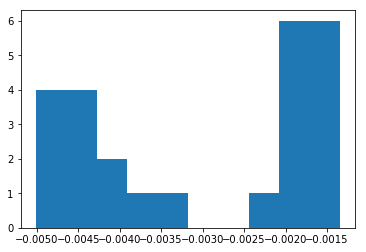

[ 0.49968552 -0.22414074 -0.00302621  0.4991192  -0.55654578 -0.00323926]
Training epoch 15800
Iter: 15800
D loss: 2.96e-05
G_loss: 0.001887
()
Training epoch 15900
Iter: 15900
D loss: 3.007e-05
G_loss: 0.001924
()
Training epoch 16000
Iter: 16000
D loss: 2.933e-05
G_loss: 0.001871
()


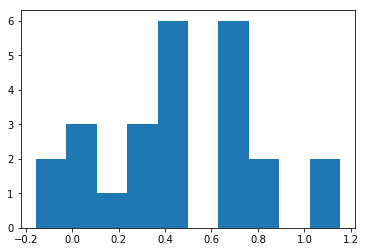

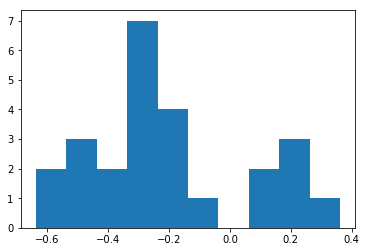

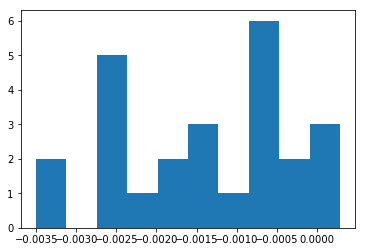

[ 0.45458495 -0.19489252 -0.00137978  0.45480366 -0.55215448  0.000871  ]
Training epoch 16100
Iter: 16100
D loss: 2.9e-05
G_loss: 0.001913
()
Training epoch 16200
Iter: 16200
D loss: 3.191e-05
G_loss: 0.001912
()


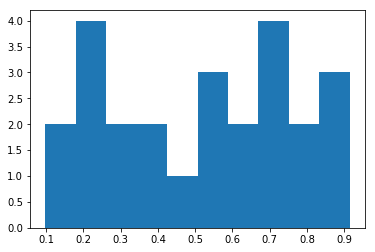

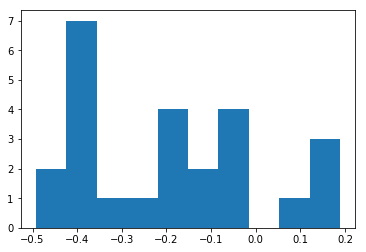

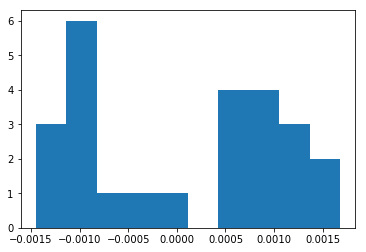

[  5.15853846e-01  -1.96755009e-01   9.99356975e-05   5.14790639e-01
  -5.39505534e-01   3.23147272e-03]
Training epoch 16300
Iter: 16300
D loss: 3.192e-05
G_loss: 0.001921
()
Training epoch 16400
Iter: 16400
D loss: 3.06e-05
G_loss: 0.001941
()
Training epoch 16500
Iter: 16500
D loss: 3.004e-05
G_loss: 0.001923
()


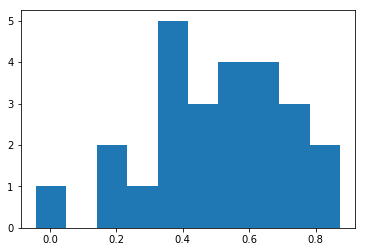

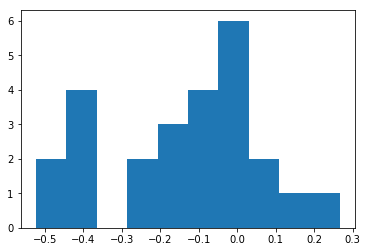

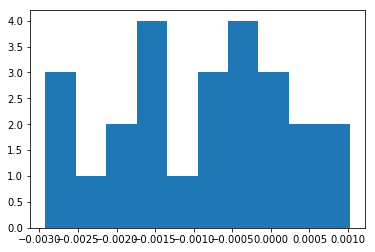

[ 0.50682923 -0.13714412 -0.00092817  0.50561631 -0.56179748 -0.00352779]
Training epoch 16600
Iter: 16600
D loss: 2.898e-05
G_loss: 0.001922
()
Training epoch 16700
Iter: 16700
D loss: 2.974e-05
G_loss: 0.001902
()


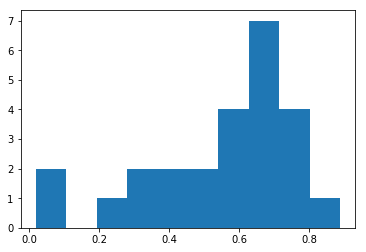

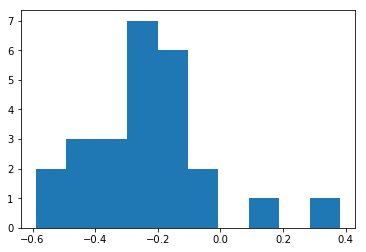

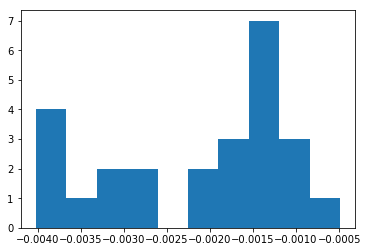

[  5.55242894e-01  -2.26483517e-01  -2.11585109e-03   5.54523334e-01
  -6.19904960e-01  -2.62688382e-04]
Training epoch 16800
Iter: 16800
D loss: 3e-05
G_loss: 0.001893
()
Training epoch 16900
Iter: 16900
D loss: 3.043e-05
G_loss: 0.001912
()
Training epoch 17000
Iter: 17000
D loss: 3.06e-05
G_loss: 0.001911
()


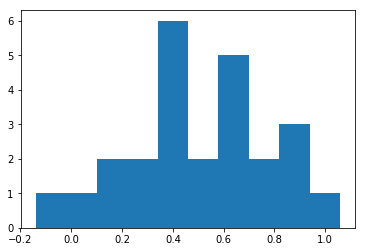

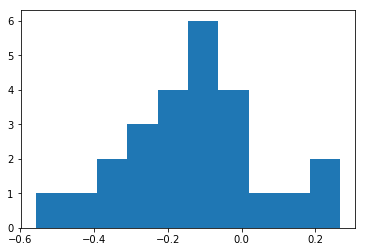

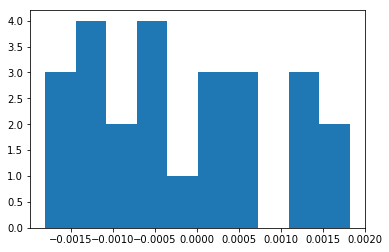

[  5.06086309e-01  -1.32709910e-01  -1.86604596e-04   5.05397673e-01
  -5.63323718e-01   1.52784377e-03]
Training epoch 17100
Iter: 17100
D loss: 3.055e-05
G_loss: 0.001933
()
Training epoch 17200
Iter: 17200
D loss: 2.906e-05
G_loss: 0.001988
()


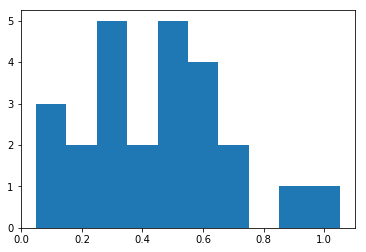

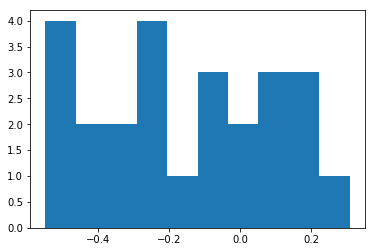

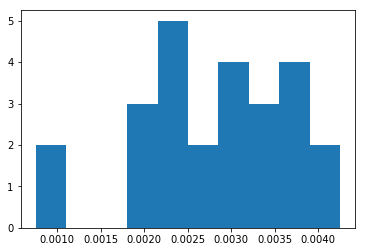

[ 0.44052646 -0.1543782   0.00278506  0.43984732 -0.51640166 -0.00151363]
Training epoch 17300
Iter: 17300
D loss: 3.063e-05
G_loss: 0.001962
()
Training epoch 17400
Iter: 17400
D loss: 2.983e-05
G_loss: 0.001909
()
Training epoch 17500
Iter: 17500
D loss: 2.795e-05
G_loss: 0.001814
()


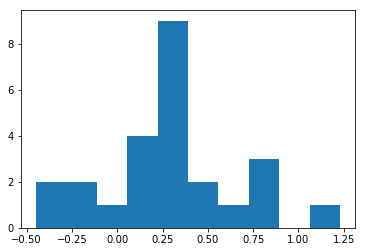

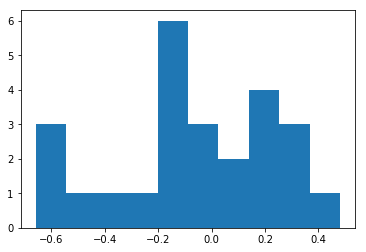

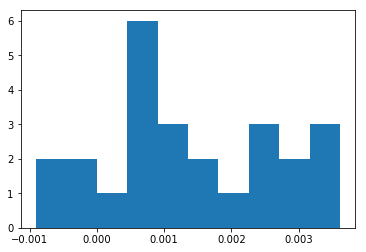

[  2.96256608e-01  -6.52096179e-02   1.38766303e-03   2.95712558e-01
  -4.37201442e-01   2.04794630e-04]
Training epoch 17600
Iter: 17600
D loss: 3.259e-05
G_loss: 0.001922
()
Training epoch 17700
Iter: 17700
D loss: 3.222e-05
G_loss: 0.001969
()


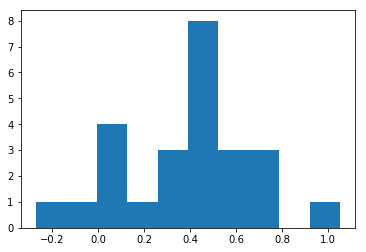

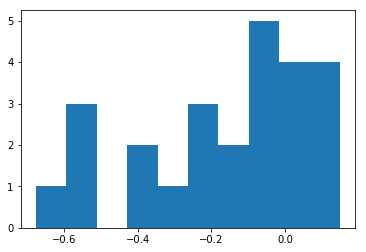

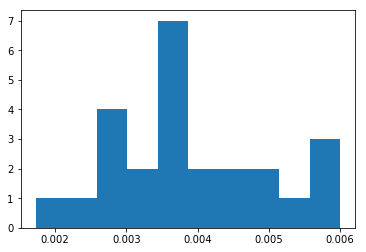

[ 0.40349791 -0.16587977  0.00385143  0.40255863 -0.48848704  0.00358924]
Training epoch 17800
Iter: 17800
D loss: 2.969e-05
G_loss: 0.001919
()
Training epoch 17900
Iter: 17900
D loss: 2.717e-05
G_loss: 0.001856
()
Training epoch 18000
Iter: 18000
D loss: 2.759e-05
G_loss: 0.001905
()


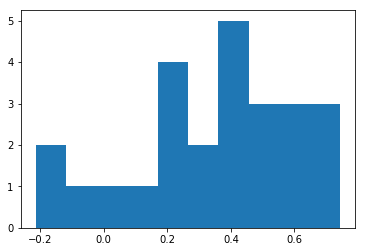

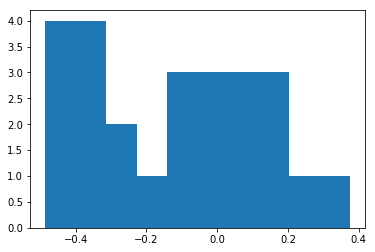

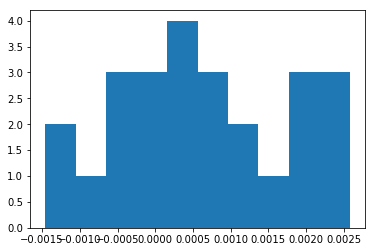

[ 0.34342047 -0.12831629  0.0006261   0.34388667 -0.4457056   0.00244316]
Training epoch 18100
Iter: 18100
D loss: 3.117e-05
G_loss: 0.001885
()
Training epoch 18200
Iter: 18200
D loss: 2.863e-05
G_loss: 0.001956
()


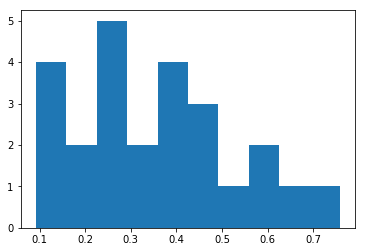

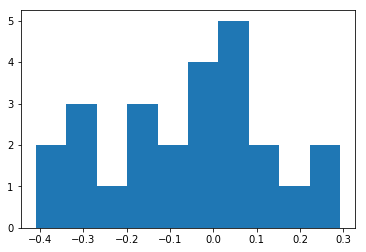

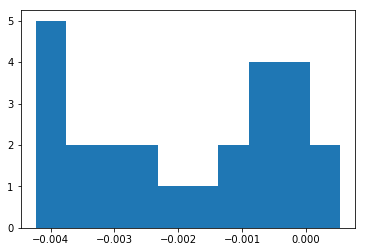

[ 0.3548733  -0.05430765 -0.00179262  0.35471315 -0.49066645  0.00390513]
Training epoch 18300
Iter: 18300
D loss: 2.968e-05
G_loss: 0.001918
()
Training epoch 18400
Iter: 18400
D loss: 2.91e-05
G_loss: 0.001921
()
Training epoch 18500
Iter: 18500
D loss: 2.966e-05
G_loss: 0.001939
()


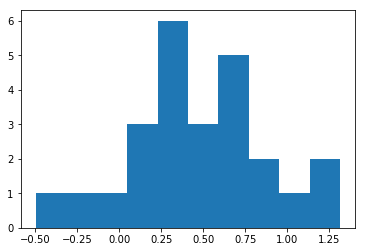

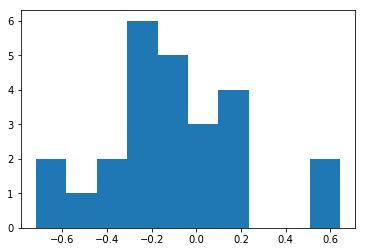

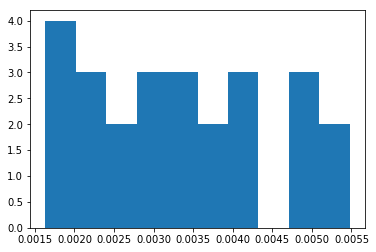

[ 0.46608295 -0.1013757   0.00332302  0.46521106 -0.52999559 -0.00403076]
Training epoch 18600
Iter: 18600
D loss: 2.998e-05
G_loss: 0.001988
()
Training epoch 18700
Iter: 18700
D loss: 2.928e-05
G_loss: 0.001908
()


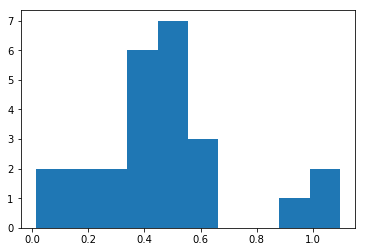

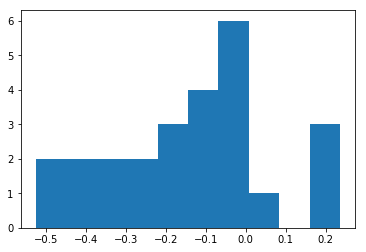

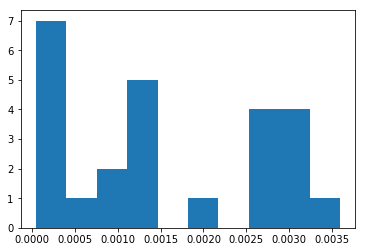

[ 0.47680027 -0.13753254  0.00157877  0.47667316 -0.52976961  0.00203627]
Training epoch 18800
Iter: 18800
D loss: 2.924e-05
G_loss: 0.001941
()
Training epoch 18900
Iter: 18900
D loss: 2.844e-05
G_loss: 0.001851
()
Training epoch 19000
Iter: 19000
D loss: 2.88e-05
G_loss: 0.001845
()


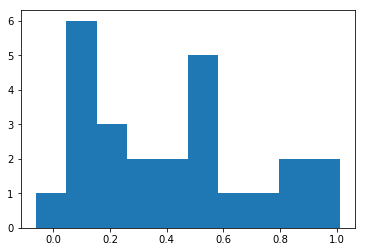

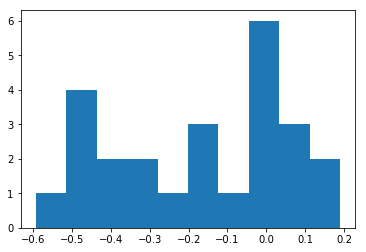

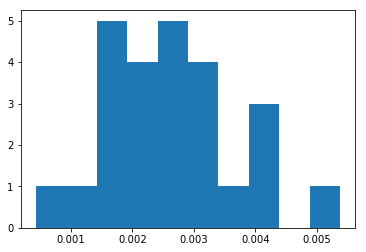

[ 0.41072478 -0.16176396  0.00261829  0.41028284 -0.45285622 -0.00060014]
Training epoch 19100
Iter: 19100
D loss: 2.895e-05
G_loss: 0.001919
()
Training epoch 19200
Iter: 19200
D loss: 3.015e-05
G_loss: 0.001857
()


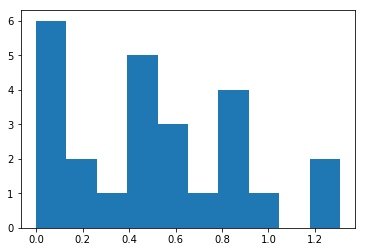

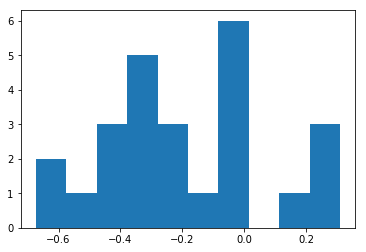

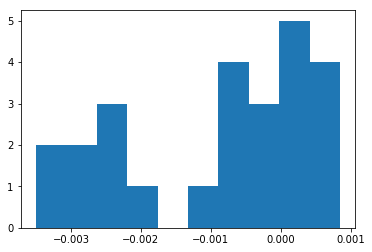

[ 0.50521749 -0.19746833 -0.00091047  0.50438055 -0.52415295 -0.00151629]
Training epoch 19300
Iter: 19300
D loss: 2.586e-05
G_loss: 0.001851
()
Training epoch 19400
Iter: 19400
D loss: 2.984e-05
G_loss: 0.001901
()
Training epoch 19500
Iter: 19500
D loss: 3.104e-05
G_loss: 0.001979
()


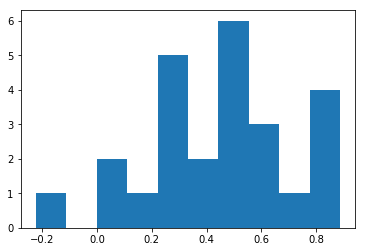

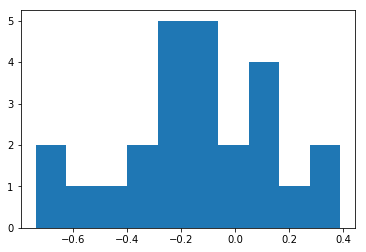

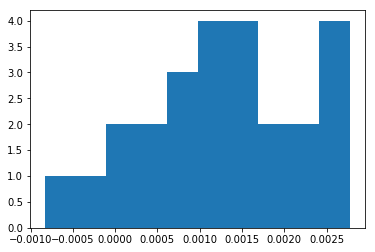

[ 0.44985412 -0.12852432  0.00127546  0.44937464 -0.47751708  0.00076361]
Training epoch 19600
Iter: 19600
D loss: 2.715e-05
G_loss: 0.001907
()
Training epoch 19700
Iter: 19700
D loss: 2.763e-05
G_loss: 0.001864
()


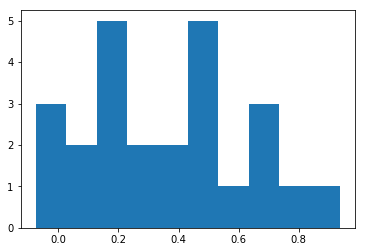

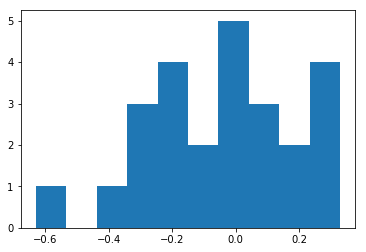

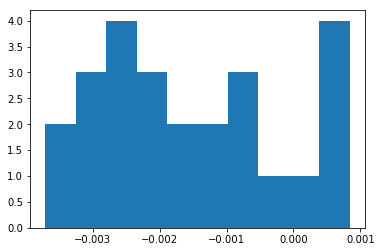

[ 0.36376314 -0.04657572 -0.00153045  0.36257218 -0.44791622 -0.00147353]
Training epoch 19800
Iter: 19800
D loss: 2.873e-05
G_loss: 0.00188
()
Training epoch 19900
Iter: 19900
D loss: 2.902e-05
G_loss: 0.001939
()
Training epoch 20000
Iter: 20000
D loss: 2.957e-05
G_loss: 0.001875
()


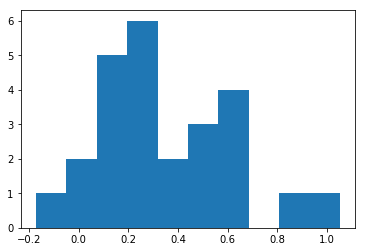

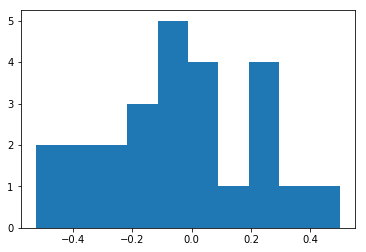

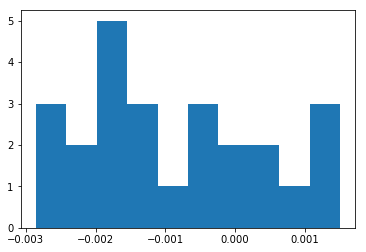

[ 0.34482646 -0.03847869 -0.00088156  0.34290465 -0.41011971  0.00121296]
Training epoch 20100
Iter: 20100
D loss: 2.957e-05
G_loss: 0.001911
()
Training epoch 20200
Iter: 20200
D loss: 2.706e-05
G_loss: 0.001938
()


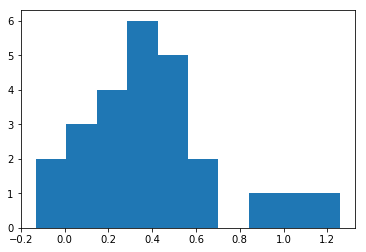

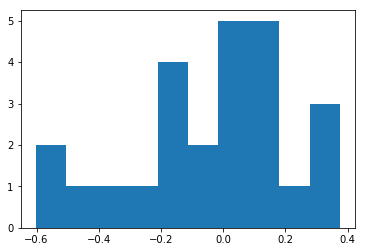

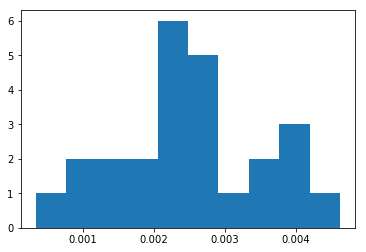

[ 0.4106683  -0.03552514  0.00250303  0.41094403 -0.46700818 -0.00052919]
Training epoch 20300
Iter: 20300
D loss: 2.855e-05
G_loss: 0.001907
()
Training epoch 20400
Iter: 20400
D loss: 2.756e-05
G_loss: 0.001855
()
Training epoch 20500
Iter: 20500
D loss: 2.815e-05
G_loss: 0.001892
()


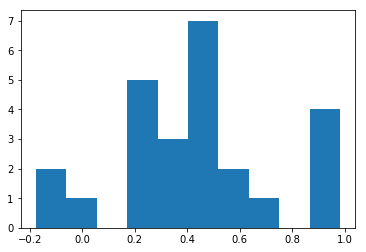

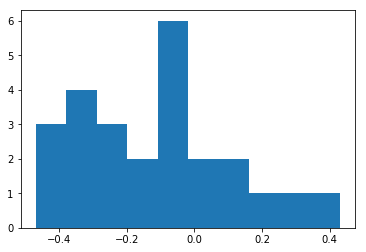

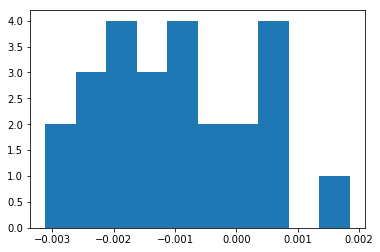

[ 0.42665556 -0.1172556  -0.00098514  0.42496444 -0.43075139 -0.00240629]
Training epoch 20600
Iter: 20600
D loss: 2.813e-05
G_loss: 0.001872
()
Training epoch 20700
Iter: 20700
D loss: 2.88e-05
G_loss: 0.001932
()


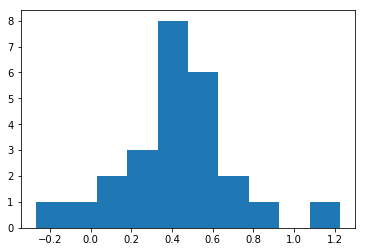

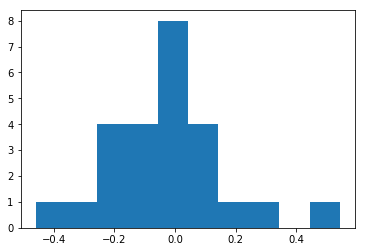

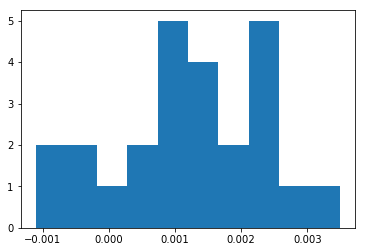

[ 0.43184986 -0.02787323  0.00121539  0.43224695 -0.46914739  0.00406037]
Training epoch 20800
Iter: 20800
D loss: 2.651e-05
G_loss: 0.00193
()
Training epoch 20900
Iter: 20900
D loss: 2.824e-05
G_loss: 0.001922
()
Training epoch 21000
Iter: 21000
D loss: 2.853e-05
G_loss: 0.001839
()


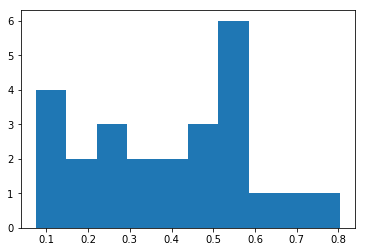

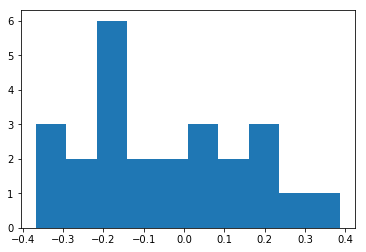

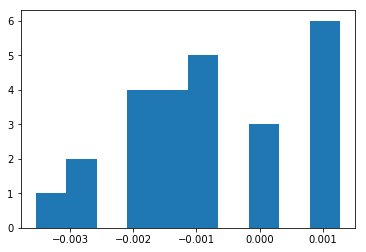

[ 0.39937685 -0.05005417 -0.00081028  0.39874574 -0.44297701 -0.00317111]
Training epoch 21100
Iter: 21100
D loss: 2.797e-05
G_loss: 0.001841
()
Training epoch 21200
Iter: 21200
D loss: 2.776e-05
G_loss: 0.001871
()


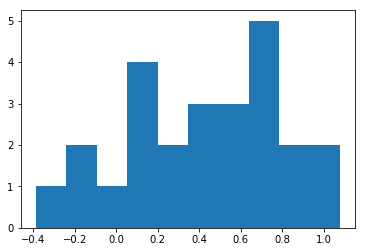

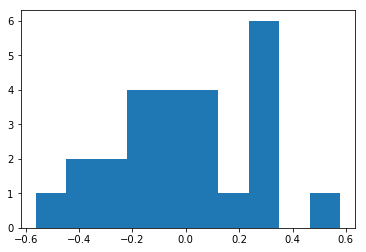

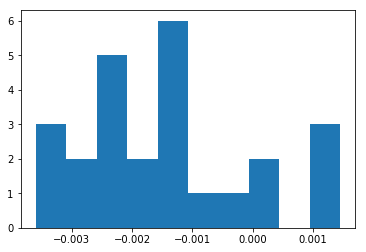

[ 0.41168407  0.00809634 -0.00151104  0.41341346 -0.44748703 -0.00339622]
Training epoch 21300
Iter: 21300
D loss: 2.837e-05
G_loss: 0.001847
()
Training epoch 21400
Iter: 21400
D loss: 2.98e-05
G_loss: 0.001879
()
Training epoch 21500
Iter: 21500
D loss: 2.898e-05
G_loss: 0.001877
()


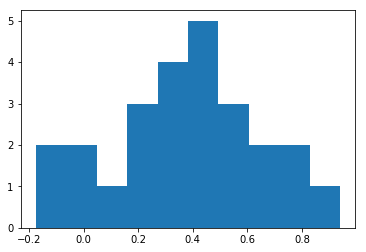

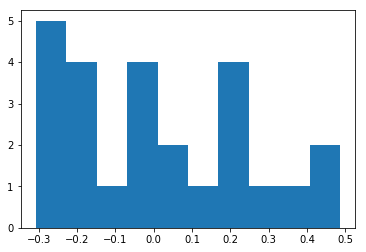

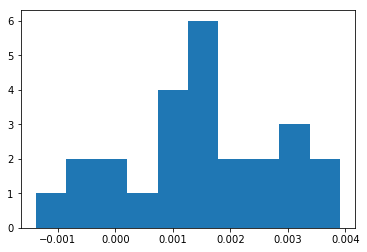

[  3.82726194e-01   1.25885150e-02   1.50864506e-03   3.84164008e-01
  -4.40595348e-01  -1.21425375e-04]
Training epoch 21600
Iter: 21600
D loss: 2.753e-05
G_loss: 0.001925
()
Training epoch 21700
Iter: 21700
D loss: 2.86e-05
G_loss: 0.001848
()


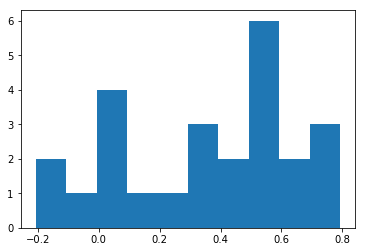

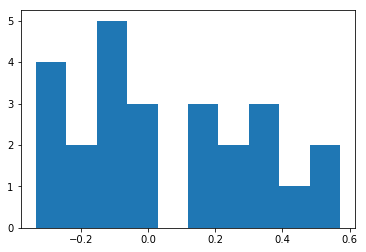

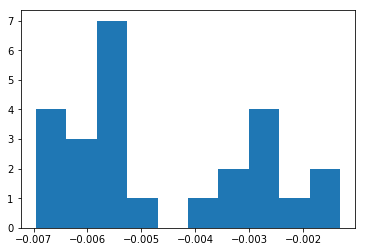

[  3.60670120e-01   5.61438704e-02  -4.60348730e-03   3.60499058e-01
  -4.26469809e-01   1.35291610e-04]
Training epoch 21800
Iter: 21800
D loss: 2.911e-05
G_loss: 0.001892
()
Training epoch 21900
Iter: 21900
D loss: 2.856e-05
G_loss: 0.001951
()
Training epoch 22000
Iter: 22000
D loss: 2.528e-05
G_loss: 0.001881
()


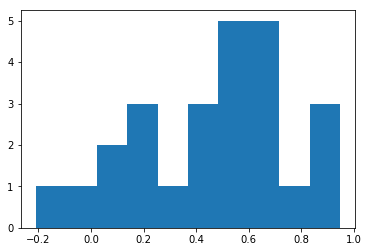

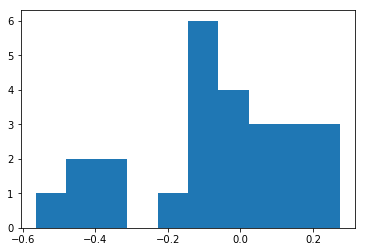

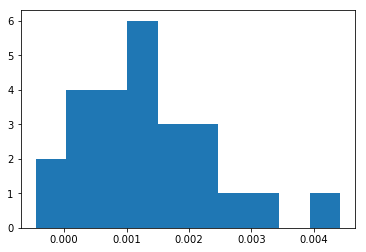

[ 0.46141187 -0.06075264  0.0013528   0.4605563  -0.45427024 -0.00171929]
Training epoch 22100
Iter: 22100
D loss: 2.812e-05
G_loss: 0.001948
()
Training epoch 22200
Iter: 22200
D loss: 2.771e-05
G_loss: 0.001872
()


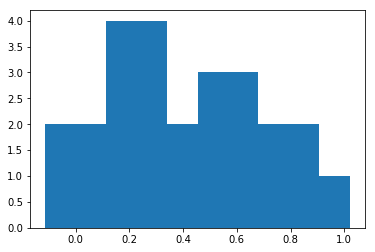

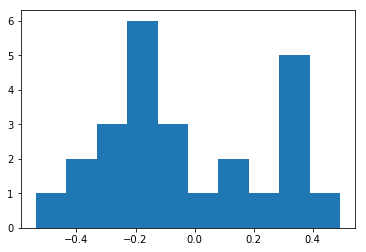

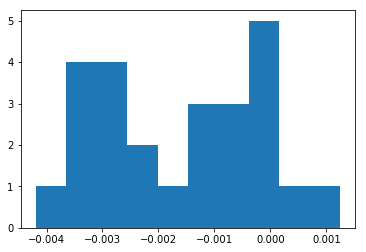

[  4.07883801e-01  -3.58184502e-02  -1.64224514e-03   4.08756963e-01
  -4.25735852e-01   3.66177165e-05]
Training epoch 22300
Iter: 22300
D loss: 2.675e-05
G_loss: 0.001854
()
Training epoch 22400
Iter: 22400
D loss: 2.662e-05
G_loss: 0.001904
()
Training epoch 22500
Iter: 22500
D loss: 2.821e-05
G_loss: 0.00188
()


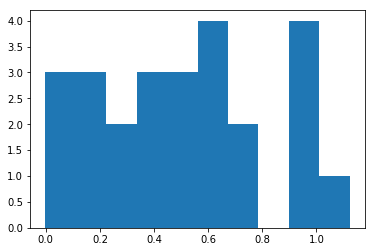

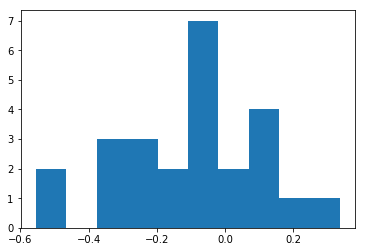

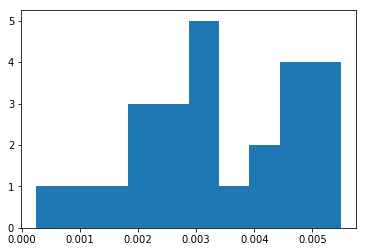

[ 0.5112672  -0.09435175  0.00337569  0.51101243 -0.46023602  0.00307244]
Training epoch 22600
Iter: 22600
D loss: 2.747e-05
G_loss: 0.001919
()
Training epoch 22700
Iter: 22700
D loss: 2.74e-05
G_loss: 0.001881
()


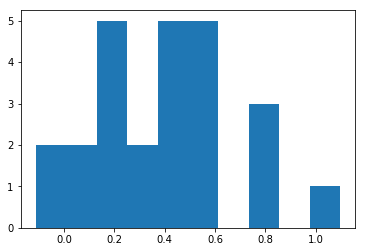

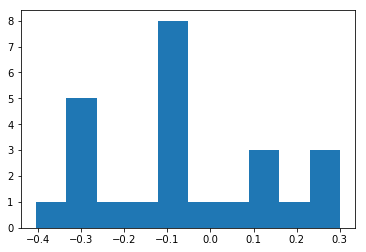

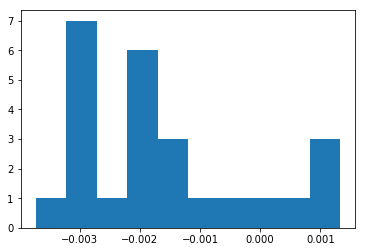

[ 0.39390725 -0.06135338 -0.00162078  0.39417715 -0.39760633  0.00144737]
Training epoch 22800
Iter: 22800
D loss: 2.689e-05
G_loss: 0.001897
()
Training epoch 22900
Iter: 22900
D loss: 2.711e-05
G_loss: 0.001897
()
Training epoch 23000
Iter: 23000
D loss: 2.629e-05
G_loss: 0.001866
()


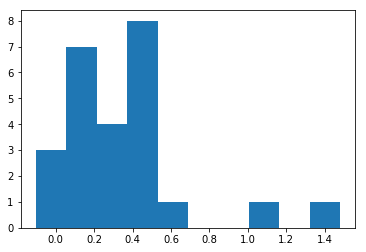

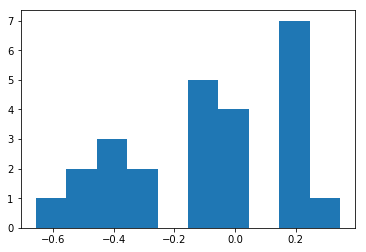

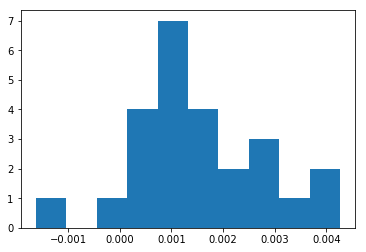

[  3.56436947e-01  -8.51331598e-02   1.52304320e-03   3.56309465e-01
  -3.84599675e-01   2.24303027e-04]
Training epoch 23100
Iter: 23100
D loss: 2.559e-05
G_loss: 0.00194
()
Training epoch 23200
Iter: 23200
D loss: 2.778e-05
G_loss: 0.001831
()


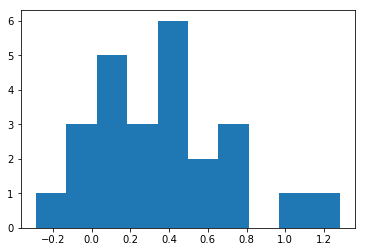

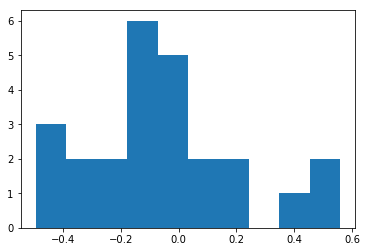

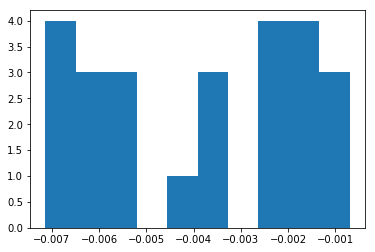

[  3.56642074e-01  -5.19793916e-02  -3.82903095e-03   3.56066759e-01
  -4.14941450e-01   3.22517055e-04]
Training epoch 23300
Iter: 23300
D loss: 2.851e-05
G_loss: 0.001851
()
Training epoch 23400
Iter: 23400
D loss: 2.851e-05
G_loss: 0.001866
()
Training epoch 23500
Iter: 23500
D loss: 2.553e-05
G_loss: 0.001867
()


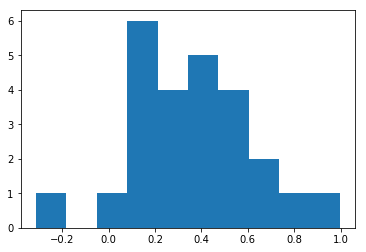

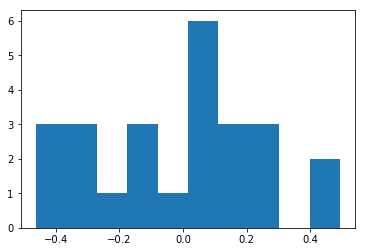

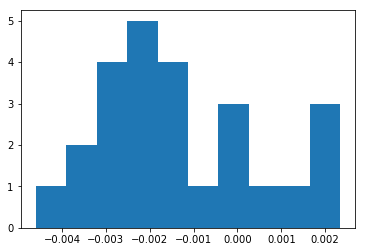

[  3.54361042e-01   2.75239825e-03  -1.33625643e-03   3.55548546e-01
  -4.03091035e-01   4.02603651e-04]
Training epoch 23600
Iter: 23600
D loss: 2.67e-05
G_loss: 0.001832
()
Training epoch 23700
Iter: 23700
D loss: 2.726e-05
G_loss: 0.001884
()


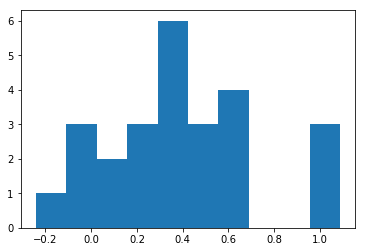

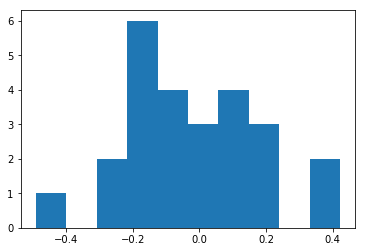

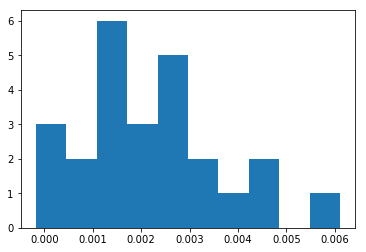

[ 0.38999352 -0.01475817  0.00218181  0.39047613 -0.42579889  0.00118773]
Training epoch 23800
Iter: 23800
D loss: 2.71e-05
G_loss: 0.001896
()
Training epoch 23900
Iter: 23900
D loss: 2.727e-05
G_loss: 0.001807
()
Training epoch 24000
Iter: 24000
D loss: 2.803e-05
G_loss: 0.001835
()


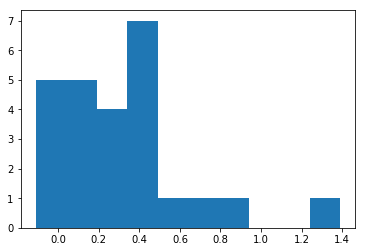

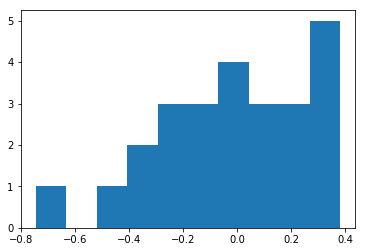

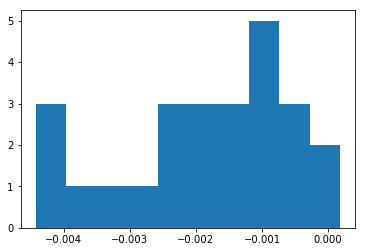

[ 0.31739731 -0.02411466 -0.00182656  0.31857259 -0.38894853  0.00305915]
Training epoch 24100
Iter: 24100
D loss: 2.776e-05
G_loss: 0.00188
()
Training epoch 24200
Iter: 24200
D loss: 2.862e-05
G_loss: 0.001874
()


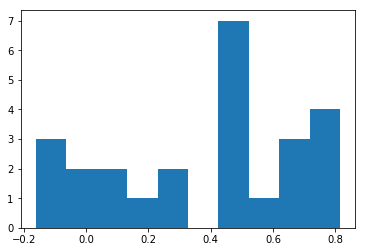

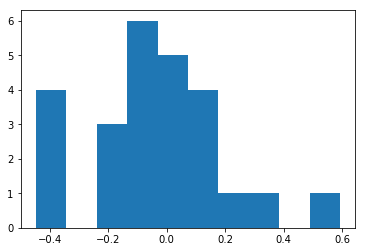

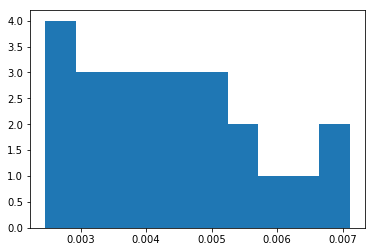

[ 0.38073961 -0.03658774  0.00441754  0.38060288 -0.418385   -0.00533451]
Training epoch 24300
Iter: 24300
D loss: 2.574e-05
G_loss: 0.001891
()
Training epoch 24400
Iter: 24400
D loss: 2.844e-05
G_loss: 0.001913
()
Training epoch 24500
Iter: 24500
D loss: 2.654e-05
G_loss: 0.001889
()


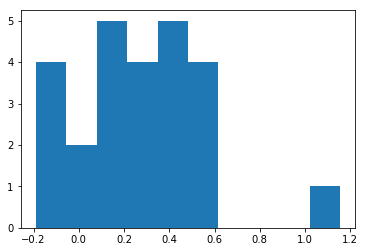

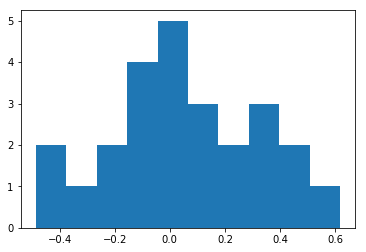

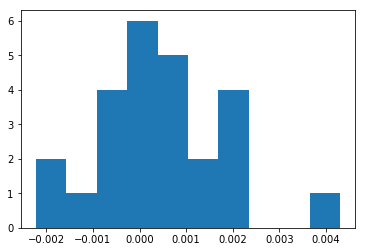

[ 0.26243258  0.05693583  0.00040984  0.26292814 -0.37240575  0.00090761]
Training epoch 24600
Iter: 24600
D loss: 2.628e-05
G_loss: 0.001909
()
Training epoch 24700
Iter: 24700
D loss: 2.736e-05
G_loss: 0.001919
()


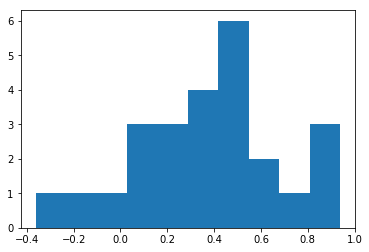

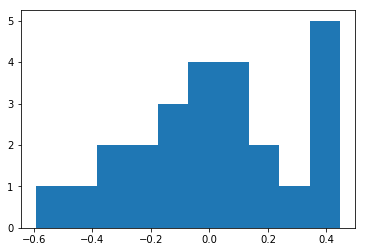

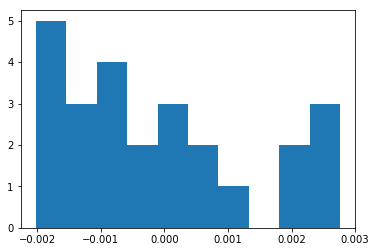

[  3.66124148e-01   6.73452467e-03  -8.41416768e-05   3.66390592e-01
  -4.39233850e-01  -8.23752519e-04]
Training epoch 24800
Iter: 24800
D loss: 2.56e-05
G_loss: 0.001914
()
Training epoch 24900
Iter: 24900
D loss: 2.637e-05
G_loss: 0.001904
()
Training epoch 25000
Iter: 25000
D loss: 2.613e-05
G_loss: 0.0018
()


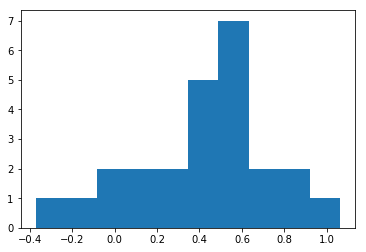

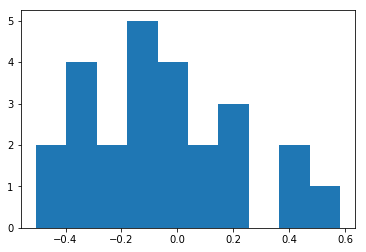

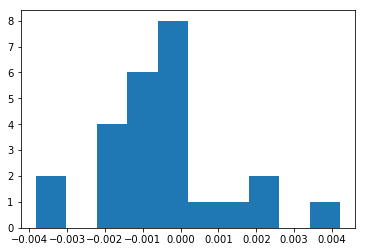

[ 0.404847   -0.06042915 -0.00050496  0.40390241 -0.40143796 -0.00125714]
Training epoch 25100
Iter: 25100
D loss: 2.543e-05
G_loss: 0.001832
()
Training epoch 25200
Iter: 25200
D loss: 2.573e-05
G_loss: 0.001905
()


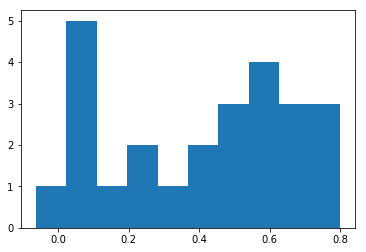

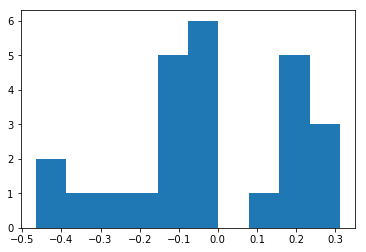

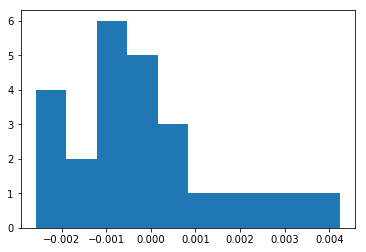

[  4.04427122e-01  -1.96857539e-02  -1.96087266e-04   4.05141175e-01
  -4.56704751e-01   3.22178780e-03]
Training epoch 25300
Iter: 25300
D loss: 2.633e-05
G_loss: 0.001952
()
Training epoch 25400
Iter: 25400
D loss: 2.538e-05
G_loss: 0.001864
()
Training epoch 25500
Iter: 25500
D loss: 2.532e-05
G_loss: 0.001857
()


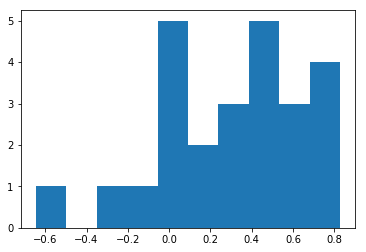

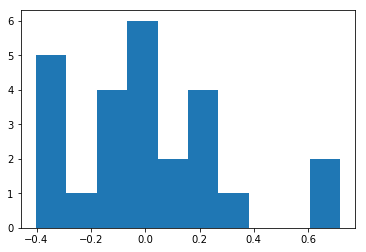

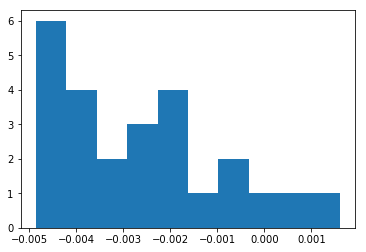

[ 0.30668323  0.00919482 -0.00259624  0.30619751 -0.41264369 -0.00059382]
Training epoch 25600
Iter: 25600
D loss: 2.722e-05
G_loss: 0.001892
()
Training epoch 25700
Iter: 25700
D loss: 2.561e-05
G_loss: 0.001865
()


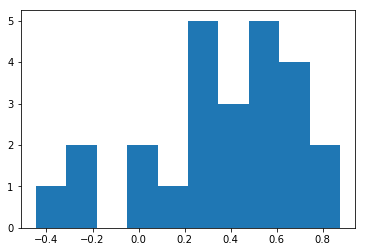

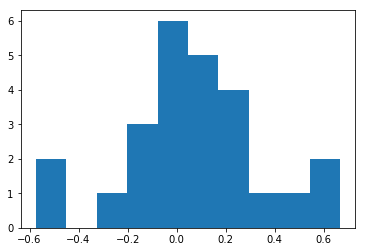

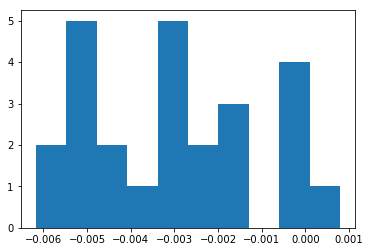

[ 0.36166514  0.06658107 -0.00304988  0.36207677 -0.43092953 -0.00282901]
Training epoch 25800
Iter: 25800
D loss: 2.481e-05
G_loss: 0.001801
()
Training epoch 25900
Iter: 25900
D loss: 2.686e-05
G_loss: 0.001878
()
Training epoch 26000
Iter: 26000
D loss: 2.715e-05
G_loss: 0.001782
()


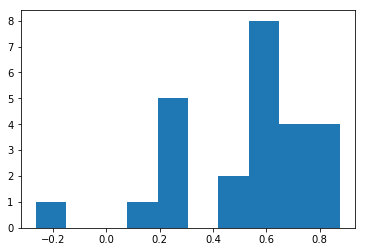

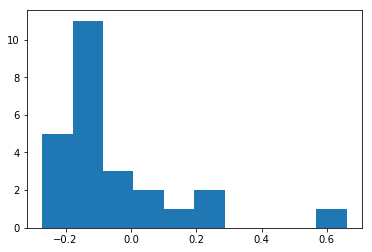

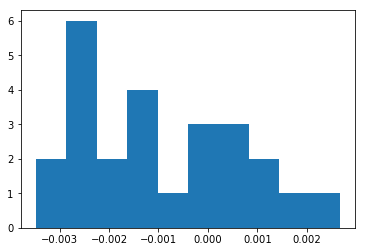

[ 0.51957863 -0.05006124 -0.00098683  0.51944243 -0.49783009 -0.0010168 ]
Training epoch 26100
Iter: 26100
D loss: 2.528e-05
G_loss: 0.001852
()
Training epoch 26200
Iter: 26200
D loss: 2.59e-05
G_loss: 0.001904
()


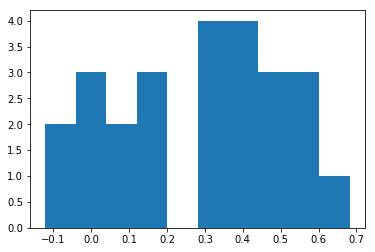

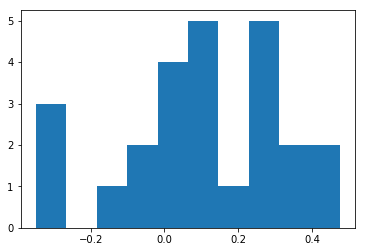

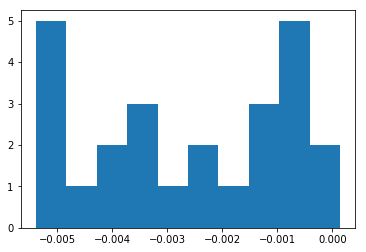

[ 0.28237398  0.1015112  -0.00259959  0.28167244 -0.39189507 -0.00308564]
Training epoch 26300
Iter: 26300
D loss: 2.594e-05
G_loss: 0.001916
()
Training epoch 26400
Iter: 26400
D loss: 2.595e-05
G_loss: 0.001903
()
Training epoch 26500
Iter: 26500
D loss: 2.47e-05
G_loss: 0.001827
()


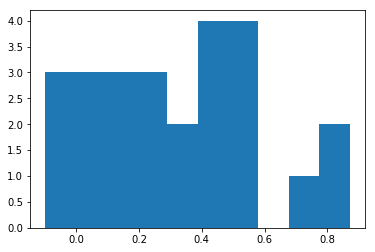

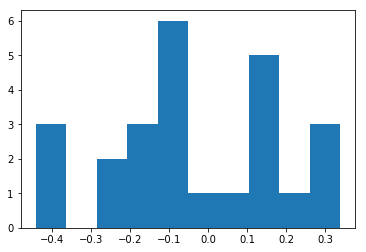

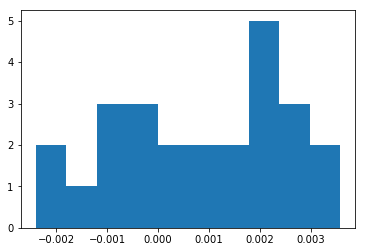

[ 0.33051794 -0.03342325  0.00082343  0.33116226 -0.35910451  0.00051952]
Training epoch 26600
Iter: 26600
D loss: 2.559e-05
G_loss: 0.001875
()
Training epoch 26700
Iter: 26700
D loss: 2.608e-05
G_loss: 0.001816
()


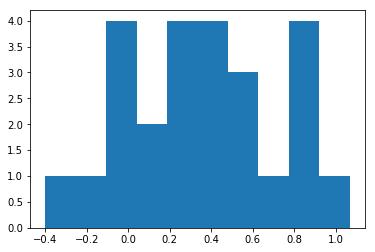

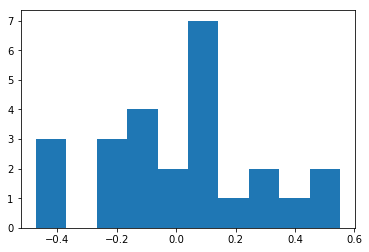

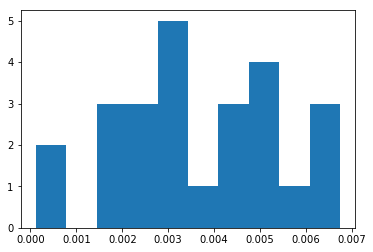

[ 0.35249616  0.02567782  0.00369516  0.35243506 -0.3763481  -0.00091563]
Training epoch 26800
Iter: 26800
D loss: 2.789e-05
G_loss: 0.001863
()
Training epoch 26900
Iter: 26900
D loss: 2.577e-05
G_loss: 0.00188
()
Training epoch 27000
Iter: 27000
D loss: 2.613e-05
G_loss: 0.001861
()


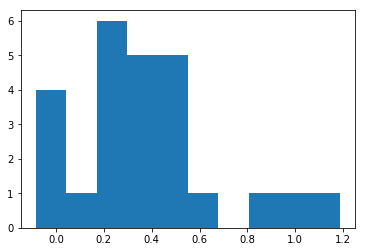

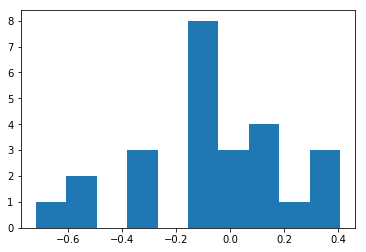

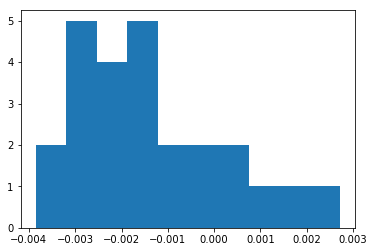

[  3.83136253e-01  -7.64352995e-02  -1.44002776e-03   3.83534293e-01
  -3.89404707e-01  -2.45739329e-04]
Training epoch 27100
Iter: 27100
D loss: 2.604e-05
G_loss: 0.00188
()
Training epoch 27200
Iter: 27200
D loss: 2.517e-05
G_loss: 0.001914
()


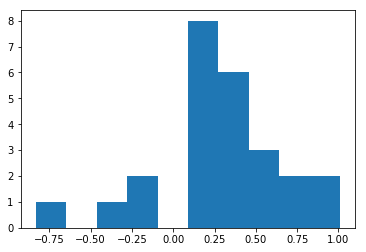

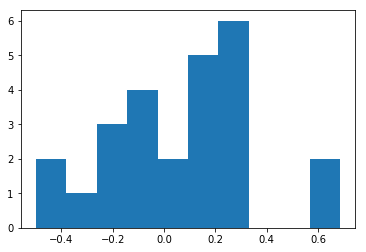

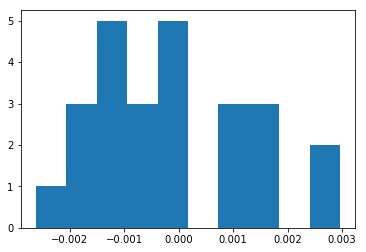

[  3.04632816e-01   5.49586815e-02  -1.68350961e-04   3.05004888e-01
  -3.90351078e-01  -2.58090864e-03]
Training epoch 27300
Iter: 27300
D loss: 2.522e-05
G_loss: 0.001847
()
Training epoch 27400
Iter: 27400
D loss: 2.417e-05
G_loss: 0.001871
()
Training epoch 27500
Iter: 27500
D loss: 2.445e-05
G_loss: 0.001926
()


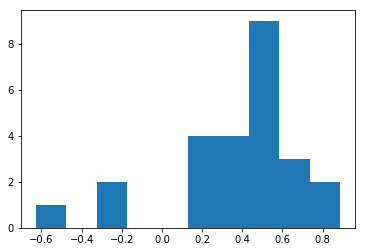

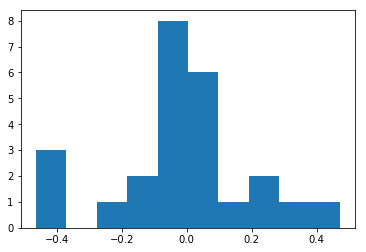

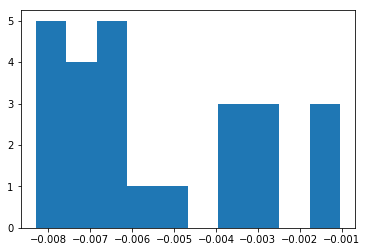

[ 0.37845317 -0.00785433 -0.00536167  0.37866098 -0.4393955   0.00079216]
Training epoch 27600
Iter: 27600
D loss: 2.554e-05
G_loss: 0.001829
()
Training epoch 27700
Iter: 27700
D loss: 2.573e-05
G_loss: 0.00191
()


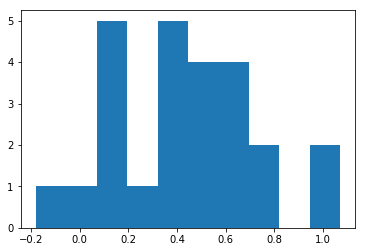

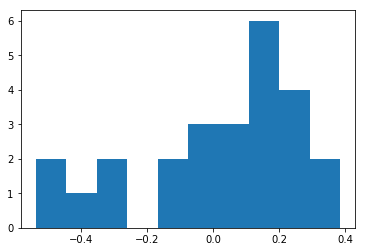

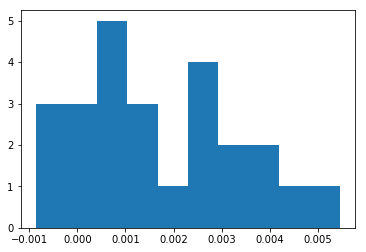

[ 0.43874578  0.01442097  0.00166953  0.43967508 -0.41144054 -0.0039107 ]
Training epoch 27800
Iter: 27800
D loss: 2.639e-05
G_loss: 0.001903
()
Training epoch 27900
Iter: 27900
D loss: 2.575e-05
G_loss: 0.001826
()
Training epoch 28000
Iter: 28000
D loss: 2.525e-05
G_loss: 0.001841
()


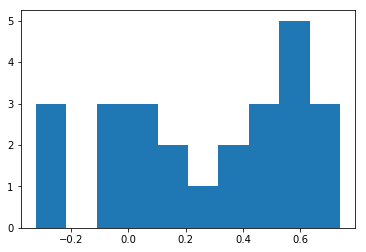

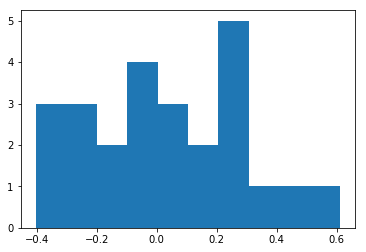

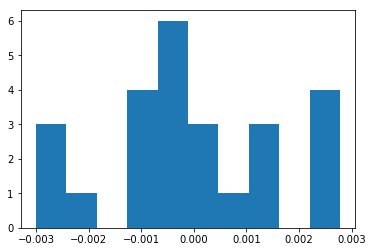

[  2.79492900e-01   3.48868465e-02  -1.30446989e-05   2.80444765e-01
  -3.72711198e-01   2.91321918e-03]
Training epoch 28100
Iter: 28100
D loss: 2.431e-05
G_loss: 0.001858
()
Training epoch 28200
Iter: 28200
D loss: 2.48e-05
G_loss: 0.001905
()


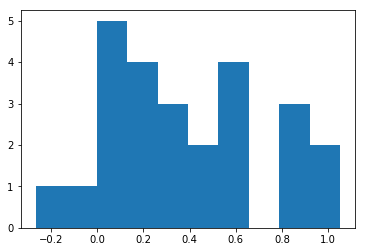

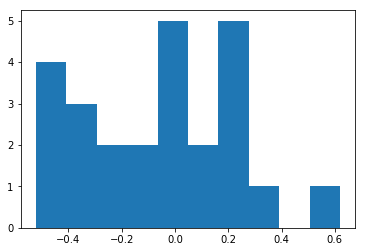

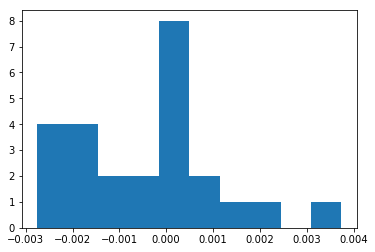

[  3.83608197e-01  -4.46999812e-02  -3.83757325e-04   3.85350860e-01
  -3.89713725e-01   3.04510812e-03]
Training epoch 28300
Iter: 28300
D loss: 2.436e-05
G_loss: 0.00194
()
Training epoch 28400
Iter: 28400
D loss: 2.526e-05
G_loss: 0.001938
()
Training epoch 28500
Iter: 28500
D loss: 2.642e-05
G_loss: 0.001922
()


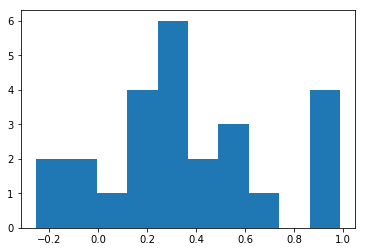

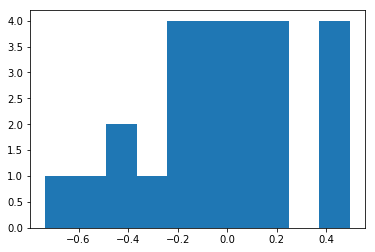

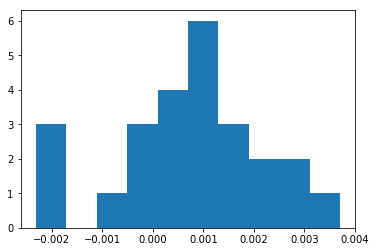

[ 0.36868034 -0.02344498  0.00076267  0.36907294 -0.41783241  0.00217624]
Training epoch 28600
Iter: 28600
D loss: 2.412e-05
G_loss: 0.001862
()
Training epoch 28700
Iter: 28700
D loss: 2.545e-05
G_loss: 0.001859
()


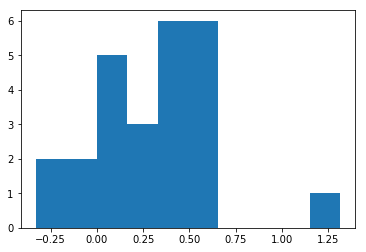

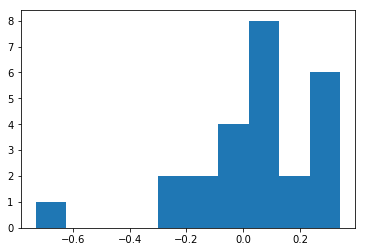

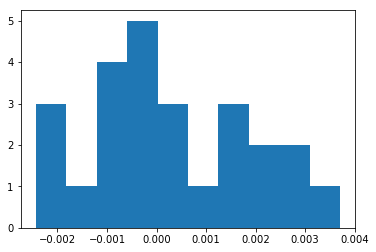

[  3.02396245e-01   4.90382928e-02   3.02349237e-04   3.02422488e-01
  -3.78110201e-01  -7.79028427e-04]
Training epoch 28800
Iter: 28800
D loss: 2.594e-05
G_loss: 0.001822
()
Training epoch 28900
Iter: 28900
D loss: 2.398e-05
G_loss: 0.001869
()
Training epoch 29000
Iter: 29000
D loss: 2.629e-05
G_loss: 0.001848
()


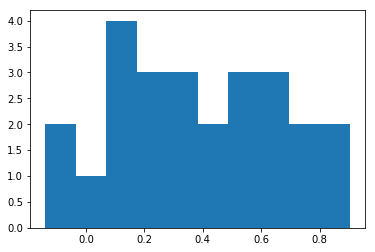

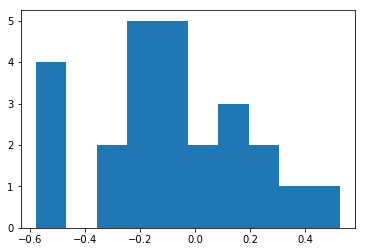

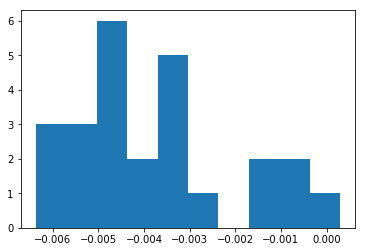

[ 0.3887466  -0.09121254 -0.00380966  0.38707928 -0.39399912 -0.00158505]
Training epoch 29100
Iter: 29100
D loss: 2.486e-05
G_loss: 0.001832
()
Training epoch 29200
Iter: 29200
D loss: 2.536e-05
G_loss: 0.001897
()


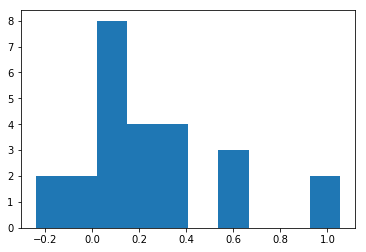

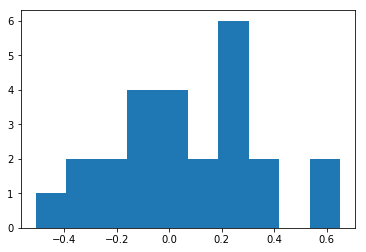

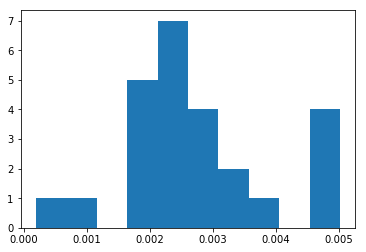

[ 0.25773941  0.07281617  0.00270774  0.25795493 -0.35381633  0.00208035]
Training epoch 29300
Iter: 29300
D loss: 2.562e-05
G_loss: 0.001865
()
Training epoch 29400
Iter: 29400
D loss: 2.468e-05
G_loss: 0.001797
()
Training epoch 29500
Iter: 29500
D loss: 2.378e-05
G_loss: 0.001927
()


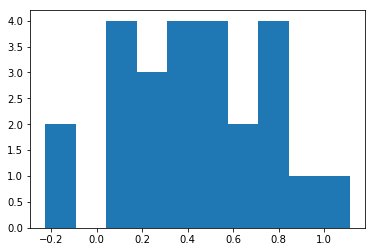

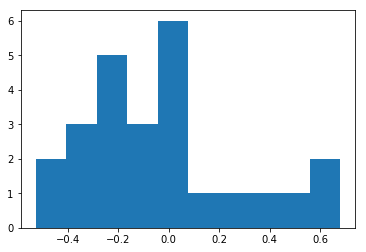

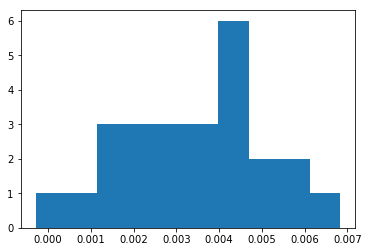

[ 0.43647405 -0.03422039  0.00348174  0.43521167 -0.43080009 -0.00049078]
Training epoch 29600
Iter: 29600
D loss: 2.581e-05
G_loss: 0.00179
()
Training epoch 29700
Iter: 29700
D loss: 2.384e-05
G_loss: 0.00183
()


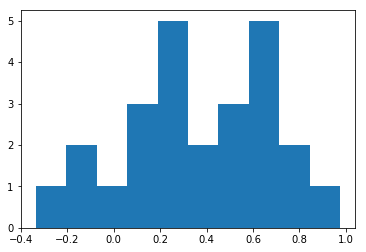

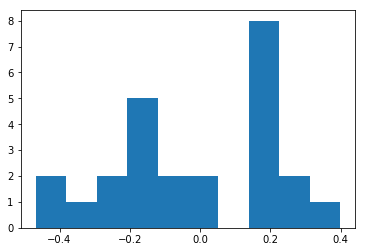

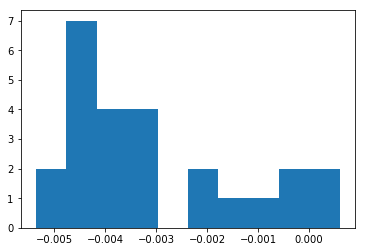

[ 0.35454928 -0.01424983 -0.00307992  0.35538416 -0.41755498 -0.00050137]
Training epoch 29800
Iter: 29800
D loss: 2.446e-05
G_loss: 0.00189
()
Training epoch 29900
Iter: 29900
D loss: 2.424e-05
G_loss: 0.001884
()
Training epoch 30000
Iter: 30000
D loss: 2.331e-05
G_loss: 0.001881
()


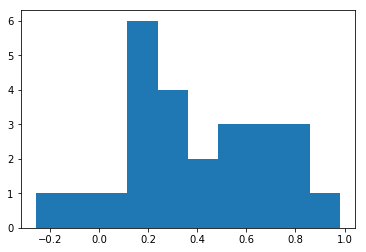

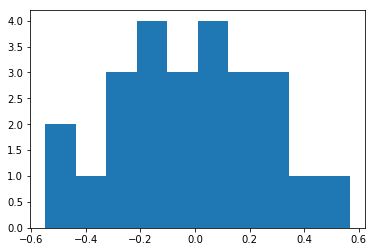

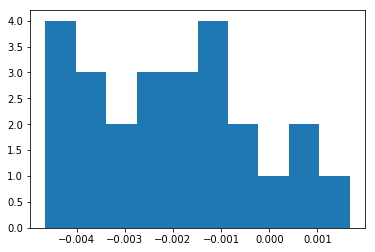

[ 0.38826491 -0.00894458 -0.00205316  0.38979096 -0.43726899  0.00359744]
Training epoch 30100
Iter: 30100
D loss: 2.474e-05
G_loss: 0.001832
()
Training epoch 30200
Iter: 30200
D loss: 2.355e-05
G_loss: 0.001881
()


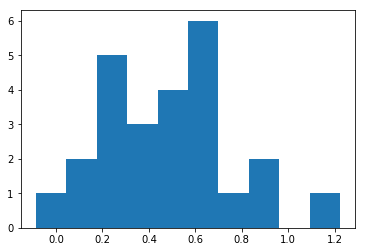

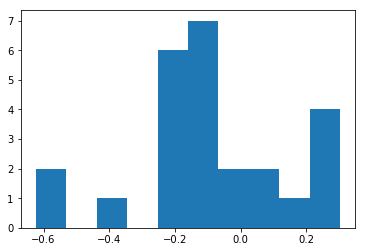

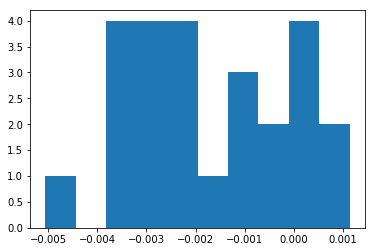

[ 0.48266127 -0.09719958 -0.00168855  0.4839782  -0.4560574  -0.00296438]
Training epoch 30300
Iter: 30300
D loss: 2.405e-05
G_loss: 0.001842
()
Training epoch 30400
Iter: 30400
D loss: 2.461e-05
G_loss: 0.001883
()
Training epoch 30500
Iter: 30500
D loss: 2.306e-05
G_loss: 0.001908
()


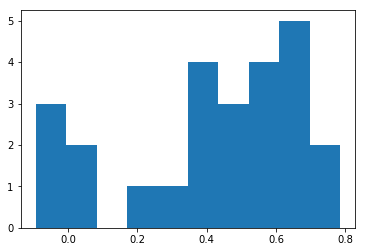

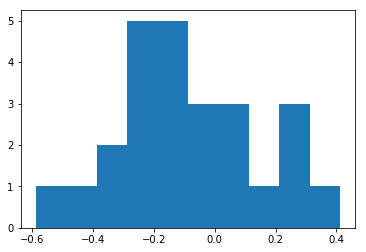

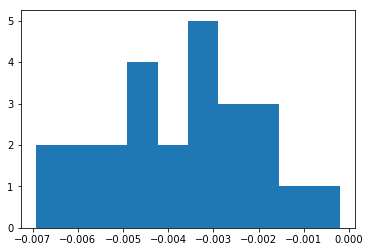

[ 0.41774479 -0.08412332 -0.00368709  0.41730632 -0.41140137  0.00162095]
Training epoch 30600
Iter: 30600
D loss: 2.391e-05
G_loss: 0.001837
()
Training epoch 30700
Iter: 30700
D loss: 2.39e-05
G_loss: 0.001852
()


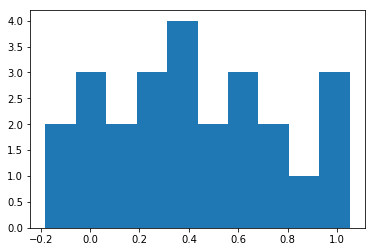

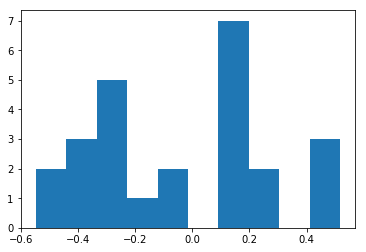

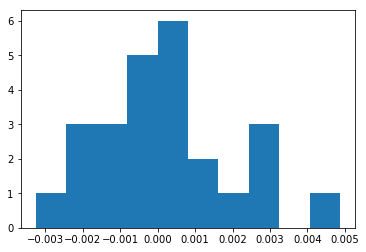

[  4.27502131e-01  -3.98494944e-02   2.24599391e-04   4.27230040e-01
  -4.50678700e-01   1.41346382e-03]
Training epoch 30800
Iter: 30800
D loss: 2.349e-05
G_loss: 0.001881
()
Training epoch 30900
Iter: 30900
D loss: 2.344e-05
G_loss: 0.001889
()
Training epoch 31000
Iter: 31000
D loss: 2.435e-05
G_loss: 0.001803
()


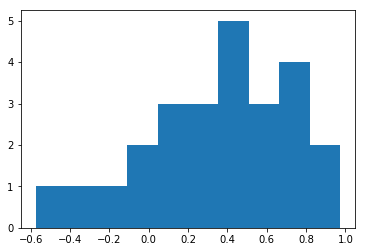

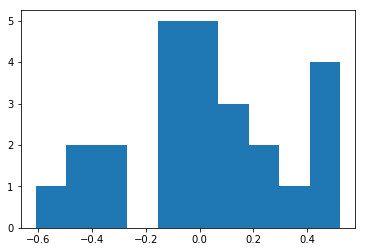

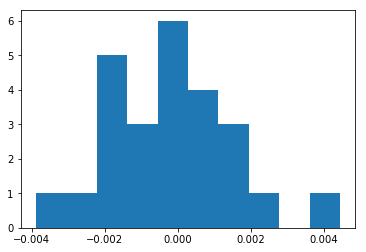

[  3.52604312e-01   1.85642669e-02  -2.40855693e-04   3.52799352e-01
  -4.21664309e-01  -9.68645685e-04]
Training epoch 31100
Iter: 31100
D loss: 2.361e-05
G_loss: 0.001737
()
Training epoch 31200
Iter: 31200
D loss: 2.49e-05
G_loss: 0.001766
()


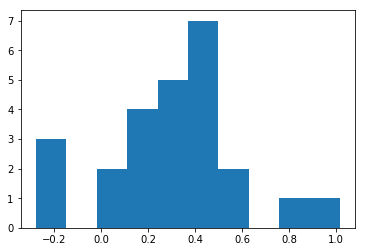

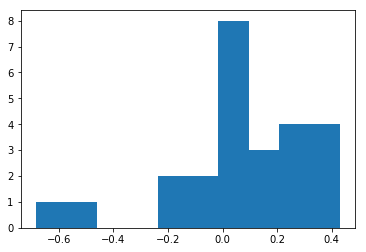

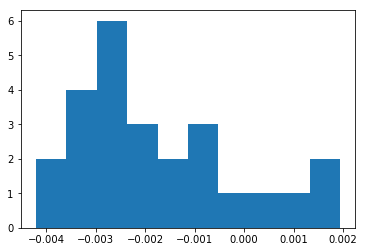

[ 0.30250021  0.05558439 -0.00177361  0.30215677 -0.37434792  0.00154061]
Training epoch 31300
Iter: 31300
D loss: 2.609e-05
G_loss: 0.001902
()
Training epoch 31400
Iter: 31400
D loss: 2.453e-05
G_loss: 0.001818
()
Training epoch 31500
Iter: 31500
D loss: 2.729e-05
G_loss: 0.001896
()


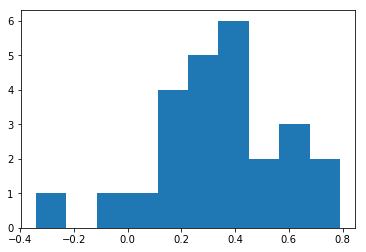

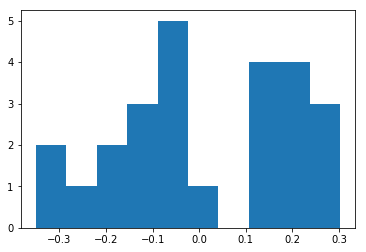

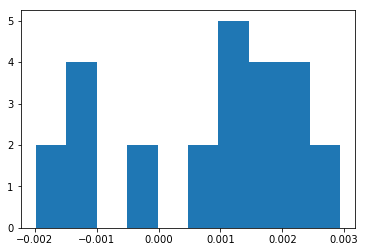

[ 0.33362888  0.00623959  0.00075889  0.33292459 -0.38729241 -0.00259042]
Training epoch 31600
Iter: 31600
D loss: 2.509e-05
G_loss: 0.001854
()
Training epoch 31700
Iter: 31700
D loss: 2.55e-05
G_loss: 0.001862
()


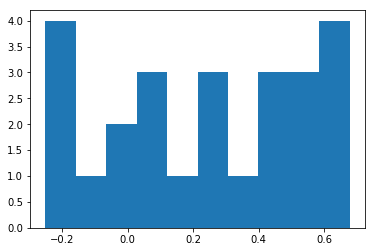

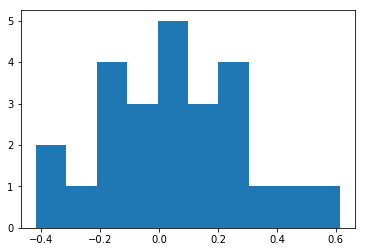

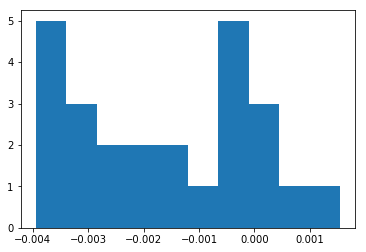

[ 0.24251148  0.04952003 -0.00163121  0.24170386 -0.32690248  0.00384801]
Training epoch 31800
Iter: 31800
D loss: 2.522e-05
G_loss: 0.001867
()
Training epoch 31900
Iter: 31900
D loss: 2.734e-05
G_loss: 0.001865
()
Training epoch 32000
Iter: 32000
D loss: 2.565e-05
G_loss: 0.001861
()


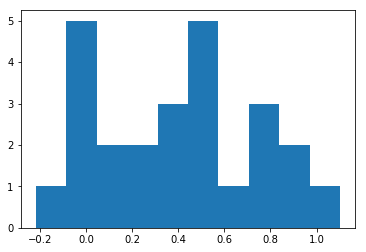

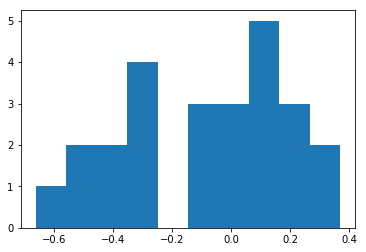

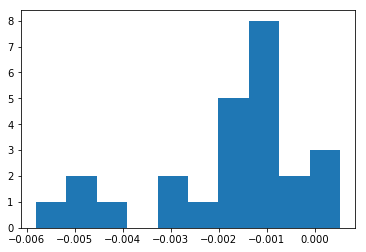

[  3.88554047e-01  -7.96588913e-02  -1.83528964e-03   3.88292105e-01
  -4.04267677e-01   1.67637597e-04]
Training epoch 32100
Iter: 32100
D loss: 2.707e-05
G_loss: 0.00185
()
Training epoch 32200
Iter: 32200
D loss: 2.59e-05
G_loss: 0.001818
()


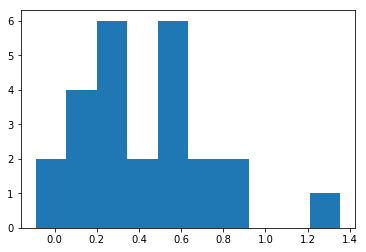

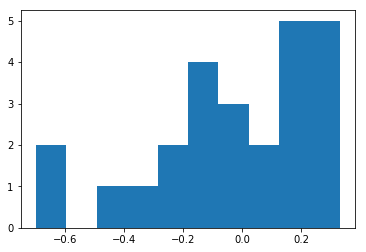

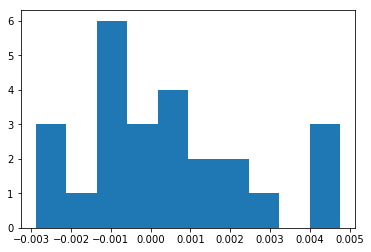

[ 0.41696571 -0.02577121  0.00042095  0.41773854 -0.41913458 -0.00079808]
Training epoch 32300
Iter: 32300
D loss: 2.623e-05
G_loss: 0.001869
()
Training epoch 32400
Iter: 32400
D loss: 2.592e-05
G_loss: 0.001826
()
Training epoch 32500
Iter: 32500
D loss: 2.639e-05
G_loss: 0.001897
()


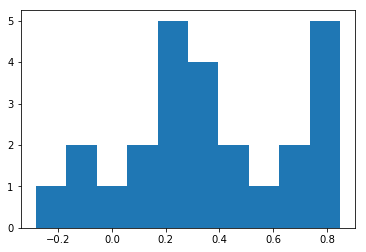

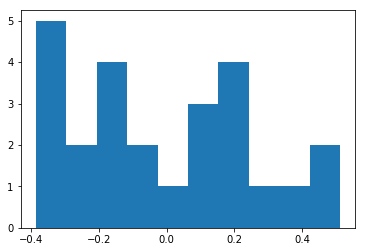

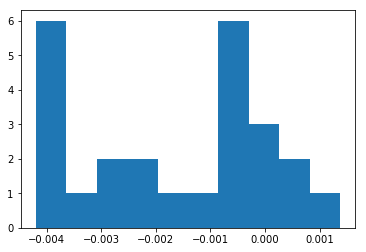

[ 0.35751934 -0.01454489 -0.00167892  0.3573803  -0.40047753 -0.00090819]
Training epoch 32600
Iter: 32600
D loss: 2.645e-05
G_loss: 0.001872
()
Training epoch 32700
Iter: 32700
D loss: 2.58e-05
G_loss: 0.001909
()


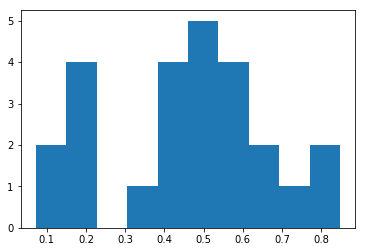

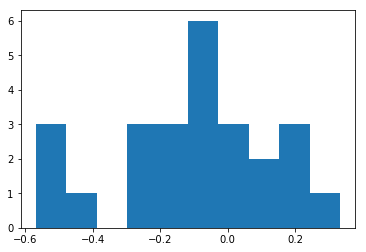

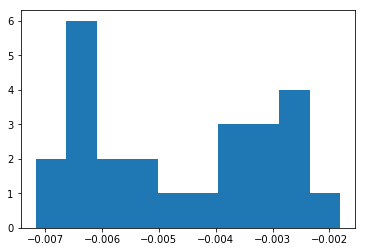

[ 0.45589014 -0.09739799 -0.00460557  0.45611533 -0.4597422   0.00120186]
Training epoch 32800
Iter: 32800
D loss: 2.658e-05
G_loss: 0.001914
()
Training epoch 32900
Iter: 32900
D loss: 2.624e-05
G_loss: 0.001882
()
Training epoch 33000
Iter: 33000
D loss: 2.621e-05
G_loss: 0.001894
()


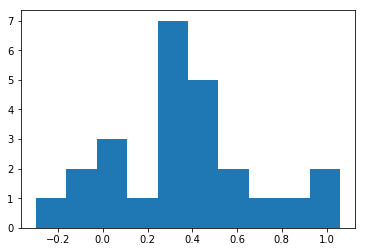

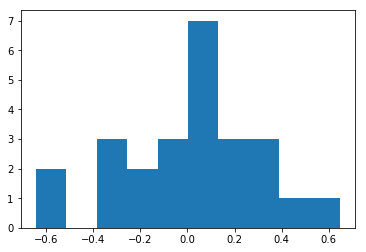

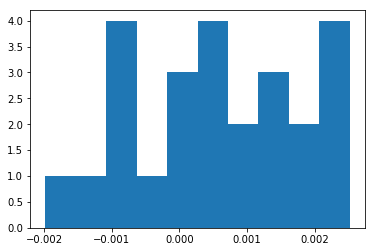

[ 0.3636195   0.01101091  0.0005436   0.3645757  -0.40678273  0.00300557]
Training epoch 33100
Iter: 33100
D loss: 2.52e-05
G_loss: 0.001848
()
Training epoch 33200
Iter: 33200
D loss: 2.55e-05
G_loss: 0.001882
()


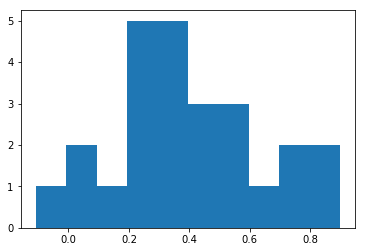

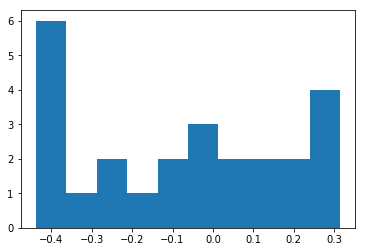

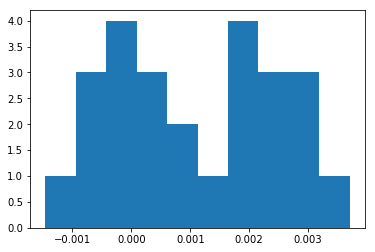

[ 0.39851234 -0.07362136  0.00113002  0.39976978 -0.39759695 -0.00156437]
Training epoch 33300
Iter: 33300
D loss: 2.556e-05
G_loss: 0.001878
()
Training epoch 33400
Iter: 33400
D loss: 2.63e-05
G_loss: 0.001872
()
Training epoch 33500
Iter: 33500
D loss: 2.701e-05
G_loss: 0.001858
()


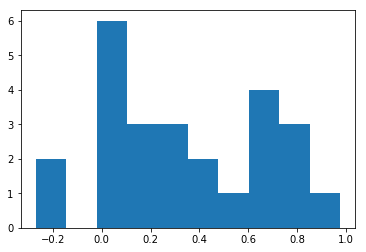

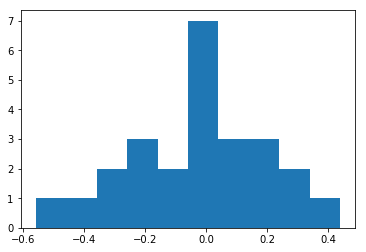

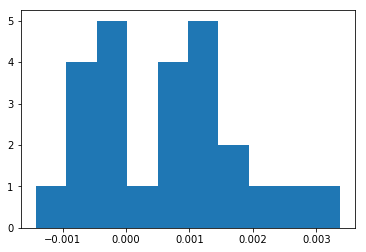

[ 0.33178365 -0.02598039  0.00060354  0.33175998 -0.36730596 -0.00083159]
Training epoch 33600
Iter: 33600
D loss: 2.546e-05
G_loss: 0.001813
()
Training epoch 33700
Iter: 33700
D loss: 2.589e-05
G_loss: 0.001809
()


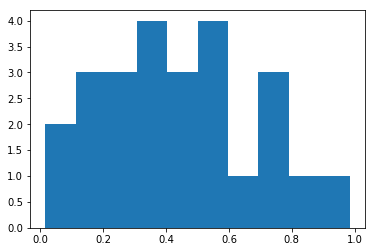

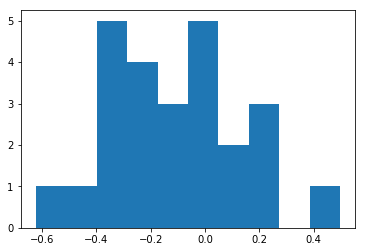

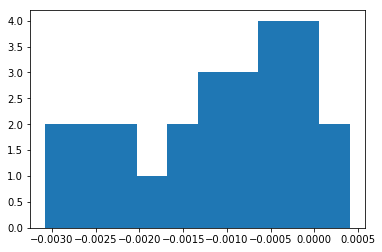

[ 0.44323494 -0.11056393 -0.00112822  0.44418129 -0.43894976 -0.00087277]
Training epoch 33800
Iter: 33800
D loss: 2.564e-05
G_loss: 0.001844
()
Training epoch 33900
Iter: 33900
D loss: 2.53e-05
G_loss: 0.001829
()
Training epoch 34000
Iter: 34000
D loss: 2.524e-05
G_loss: 0.001812
()


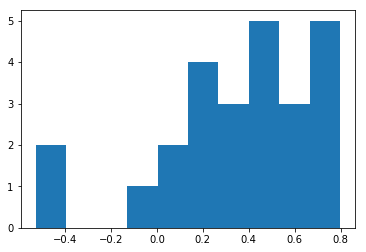

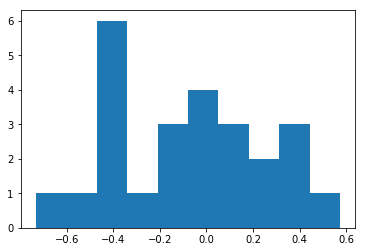

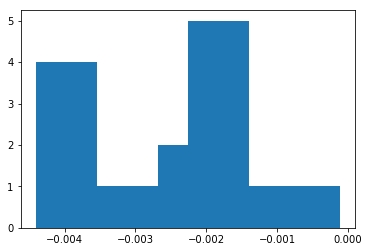

[ 0.3571453  -0.08459733 -0.00251323  0.35633514 -0.42061642 -0.0032018 ]
Training epoch 34100
Iter: 34100
D loss: 2.509e-05
G_loss: 0.001839
()
Training epoch 34200
Iter: 34200
D loss: 2.502e-05
G_loss: 0.001851
()


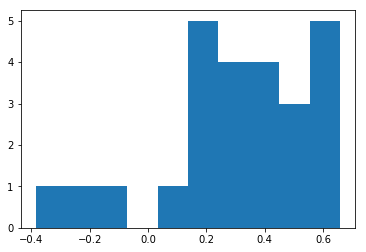

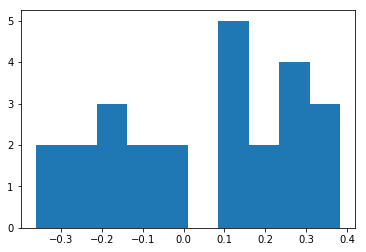

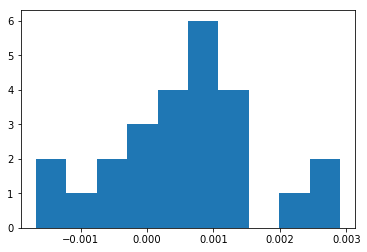

[ 0.31179705  0.04536533  0.0005954   0.3106246  -0.39006091  0.00157408]
Training epoch 34300
Iter: 34300
D loss: 2.477e-05
G_loss: 0.001825
()
Training epoch 34400
Iter: 34400
D loss: 2.599e-05
G_loss: 0.001889
()
Training epoch 34500
Iter: 34500
D loss: 2.521e-05
G_loss: 0.001881
()


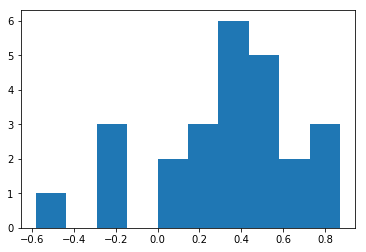

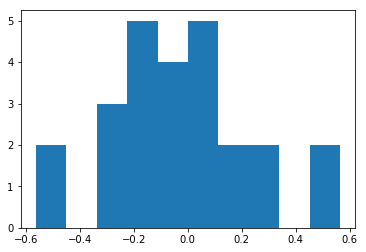

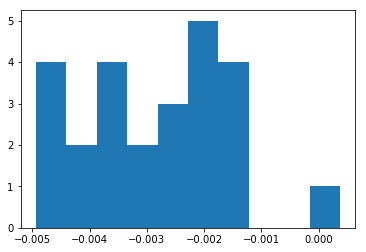

[ 0.33702838 -0.01817982 -0.00282623  0.33710408 -0.39510547 -0.00051174]
Training epoch 34600
Iter: 34600
D loss: 2.457e-05
G_loss: 0.001793
()
Training epoch 34700
Iter: 34700
D loss: 2.608e-05
G_loss: 0.001848
()


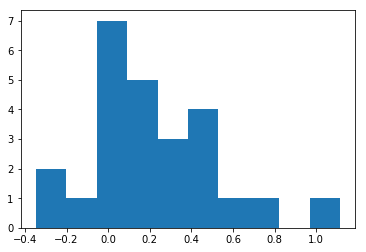

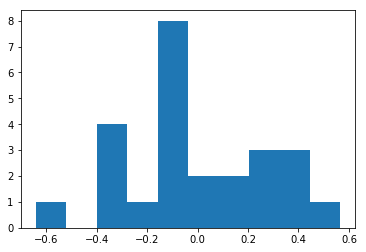

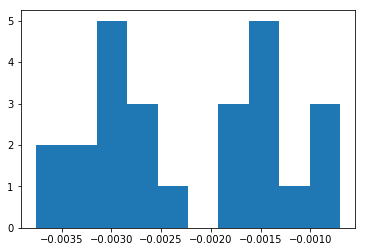

[  2.18568197e-01  -3.88982058e-03  -2.23077592e-03   2.18668366e-01
  -3.69075325e-01  -3.98842129e-05]
Training epoch 34800
Iter: 34800
D loss: 2.527e-05
G_loss: 0.00179
()
Training epoch 34900
Iter: 34900
D loss: 2.551e-05
G_loss: 0.001898
()
Training epoch 35000
Iter: 35000
D loss: 2.427e-05
G_loss: 0.001791
()


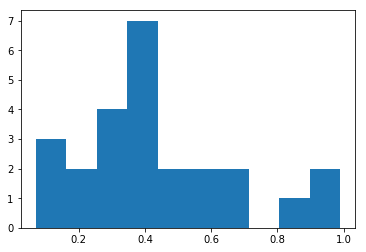

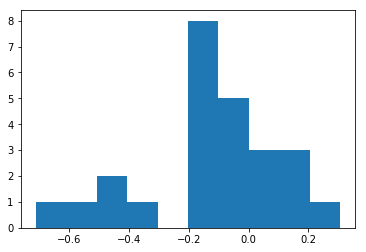

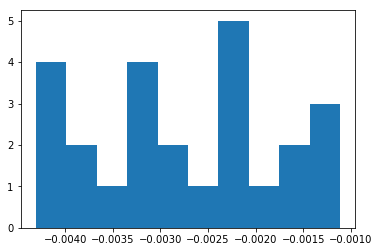

[ 0.43598805 -0.12631521 -0.0027694   0.43509048 -0.45630688 -0.00153422]
Training epoch 35100
Iter: 35100
D loss: 2.501e-05
G_loss: 0.001824
()
Training epoch 35200
Iter: 35200
D loss: 2.476e-05
G_loss: 0.00187
()


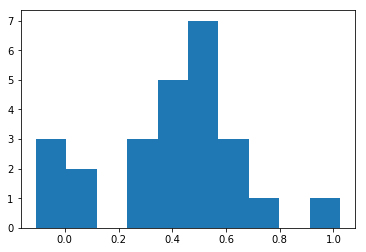

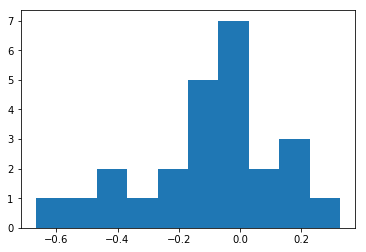

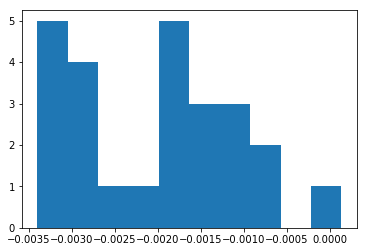

[ 0.39497804 -0.10144608 -0.00206037  0.39412567 -0.39189463  0.00049956]
Training epoch 35300
Iter: 35300
D loss: 2.487e-05
G_loss: 0.001745
()
Training epoch 35400
Iter: 35400
D loss: 2.532e-05
G_loss: 0.001787
()
Training epoch 35500
Iter: 35500
D loss: 2.481e-05
G_loss: 0.001819
()


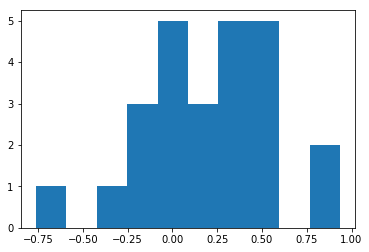

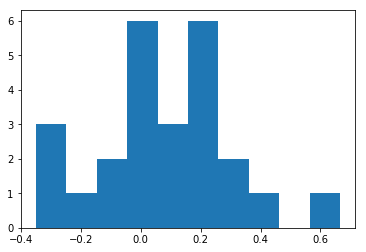

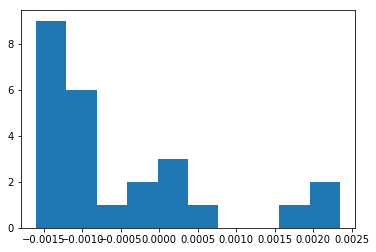

[  2.13531061e-01   8.59929121e-02  -5.29018113e-04   2.12844192e-01
  -3.60029338e-01   1.54426684e-04]
Training epoch 35600
Iter: 35600
D loss: 2.559e-05
G_loss: 0.001801
()
Training epoch 35700
Iter: 35700
D loss: 2.4e-05
G_loss: 0.001789
()


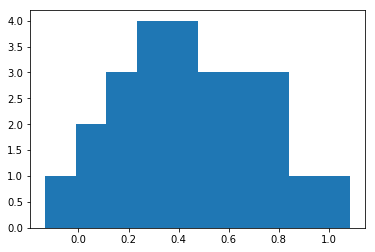

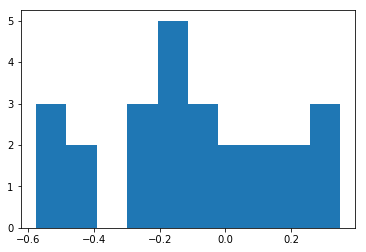

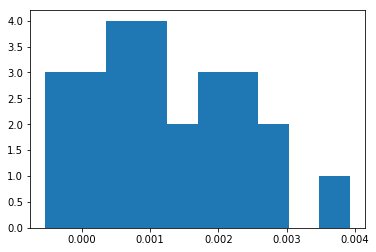

[ 0.44617029 -0.10231027  0.00124694  0.44528233 -0.42749989 -0.00278363]
Training epoch 35800
Iter: 35800
D loss: 2.572e-05
G_loss: 0.001878
()
Training epoch 35900
Iter: 35900
D loss: 2.542e-05
G_loss: 0.00189
()
Training epoch 36000
Iter: 36000
D loss: 2.627e-05
G_loss: 0.001806
()


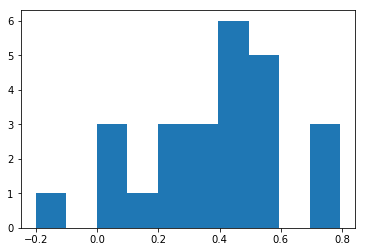

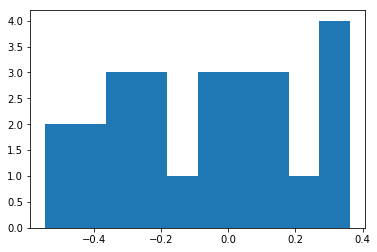

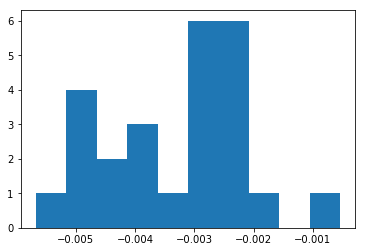

[  3.86925118e-01  -6.37240851e-02  -3.32997517e-03   3.85725335e-01
  -4.38716187e-01  -7.69681500e-05]
Training epoch 36100
Iter: 36100
D loss: 2.555e-05
G_loss: 0.001859
()
Training epoch 36200
Iter: 36200
D loss: 2.54e-05
G_loss: 0.001805
()


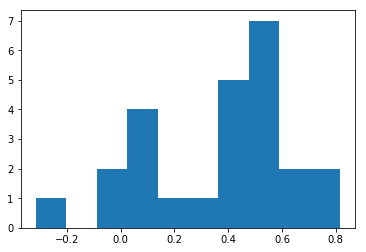

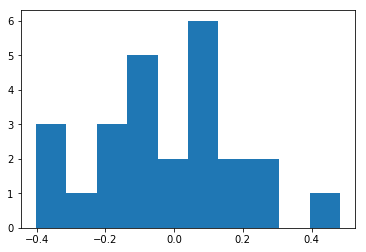

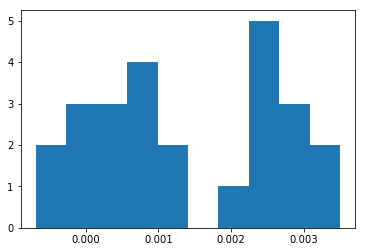

[  3.62091609e-01  -1.69478798e-02   1.39364506e-03   3.63278393e-01
  -4.05764923e-01  -2.63726065e-04]
Training epoch 36300
Iter: 36300
D loss: 2.494e-05
G_loss: 0.001792
()
Training epoch 36400
Iter: 36400
D loss: 2.557e-05
G_loss: 0.001831
()
Training epoch 36500
Iter: 36500
D loss: 2.494e-05
G_loss: 0.001799
()


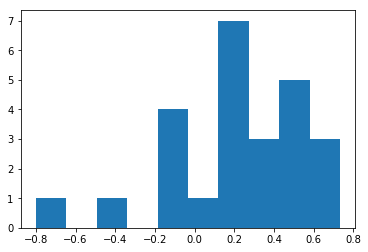

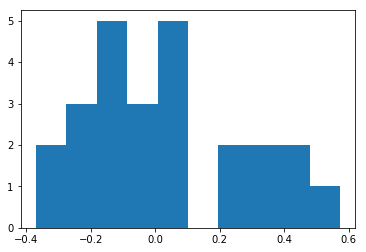

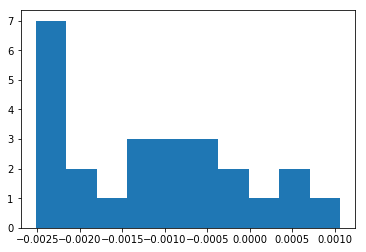

[ 0.22000615  0.0258462  -0.00113223  0.22018481 -0.35497352  0.00067336]
Training epoch 36600
Iter: 36600
D loss: 2.438e-05
G_loss: 0.001835
()
Training epoch 36700
Iter: 36700
D loss: 2.541e-05
G_loss: 0.00183
()


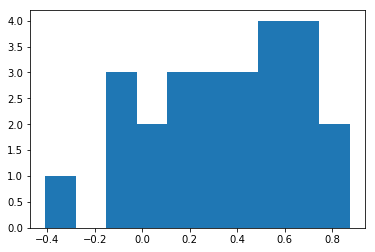

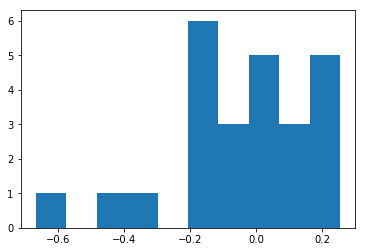

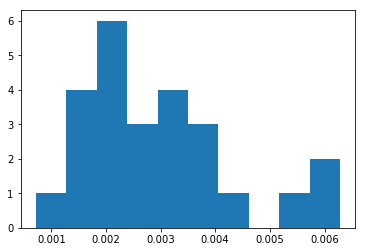

[ 0.35191676 -0.03738426  0.00292326  0.3501835  -0.3995029   0.00243509]
Training epoch 36800
Iter: 36800
D loss: 2.441e-05
G_loss: 0.001879
()
Training epoch 36900
Iter: 36900
D loss: 2.472e-05
G_loss: 0.001797
()
Training epoch 37000
Iter: 37000
D loss: 2.393e-05
G_loss: 0.001859
()


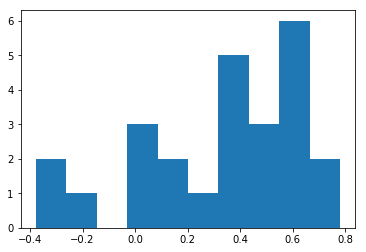

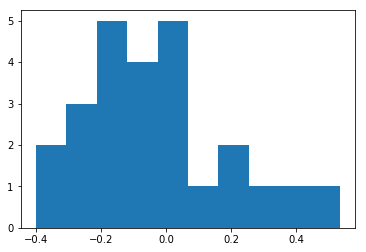

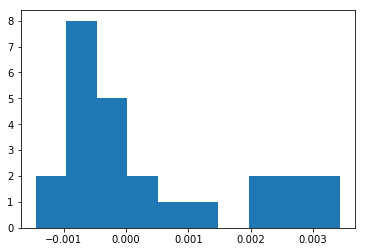

[  3.19032341e-01  -3.00181487e-02   3.82295689e-04   3.18564981e-01
  -4.29375436e-01   1.20532969e-03]
Training epoch 37100
Iter: 37100
D loss: 2.371e-05
G_loss: 0.001824
()
Training epoch 37200
Iter: 37200
D loss: 2.372e-05
G_loss: 0.001781
()


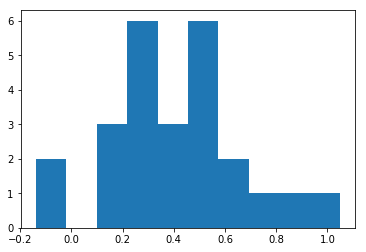

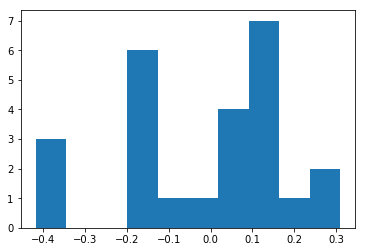

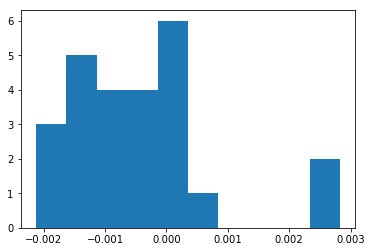

[  3.99920519e-01  -9.46748704e-03  -4.74018082e-04   3.99058946e-01
  -4.90589160e-01  -2.46393708e-03]
Training epoch 37300
Iter: 37300
D loss: 2.52e-05
G_loss: 0.001856
()
Training epoch 37400
Iter: 37400
D loss: 2.455e-05
G_loss: 0.001863
()
Training epoch 37500
Iter: 37500
D loss: 2.414e-05
G_loss: 0.001852
()


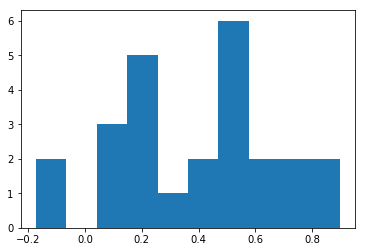

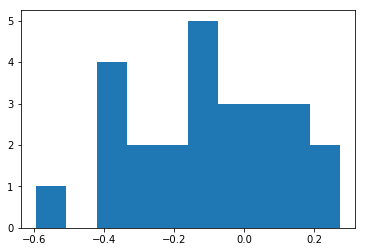

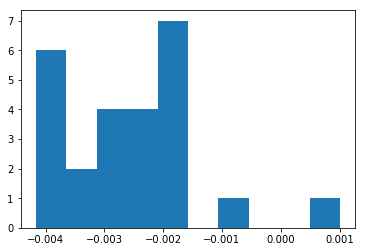

[ 0.40485922 -0.1024093  -0.00253891  0.40519306 -0.43911273 -0.00259493]
Training epoch 37600
Iter: 37600
D loss: 2.481e-05
G_loss: 0.001743
()
Training epoch 37700
Iter: 37700
D loss: 2.452e-05
G_loss: 0.001777
()


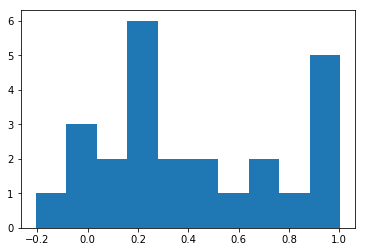

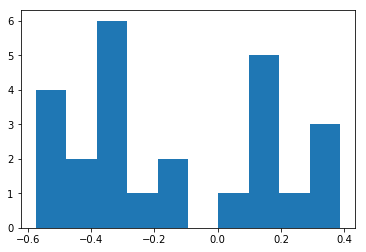

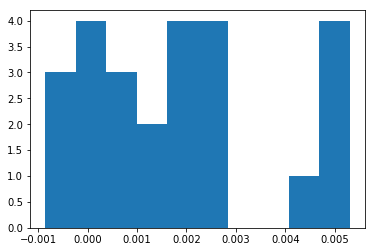

[ 0.4272754  -0.14119731  0.00179334  0.42773674 -0.43923615  0.00456142]
Training epoch 37800
Iter: 37800
D loss: 2.442e-05
G_loss: 0.001801
()
Training epoch 37900
Iter: 37900
D loss: 2.457e-05
G_loss: 0.001778
()
Training epoch 38000
Iter: 38000
D loss: 2.46e-05
G_loss: 0.001819
()


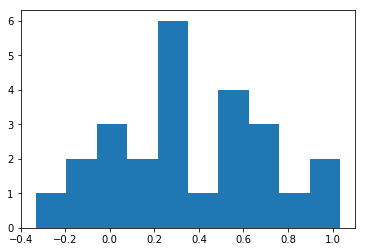

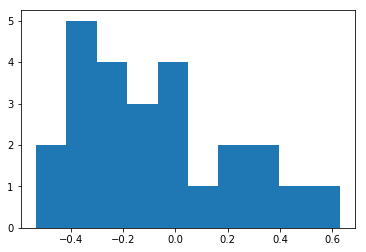

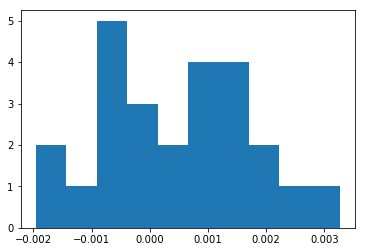

[  3.44551042e-01  -6.69220540e-02   4.63190071e-04   3.43705809e-01
  -3.49265480e-01  -1.93203605e-04]
Training epoch 38100
Iter: 38100
D loss: 2.396e-05
G_loss: 0.001811
()
Training epoch 38200
Iter: 38200
D loss: 2.461e-05
G_loss: 0.001758
()


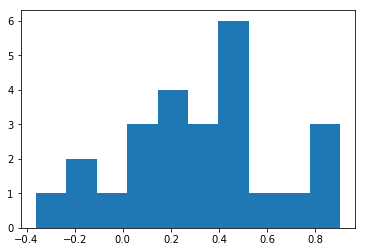

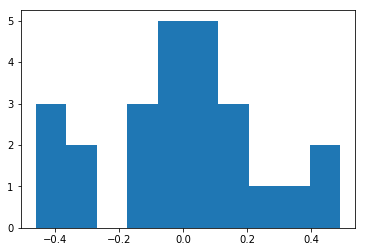

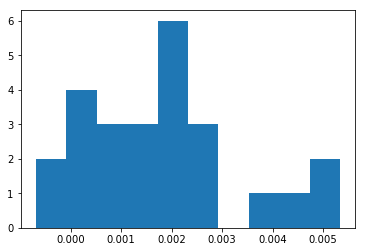

[ 0.30703291 -0.01388047  0.00186518  0.30770296 -0.377363   -0.00324074]
Training epoch 38300
Iter: 38300
D loss: 2.421e-05
G_loss: 0.00186
()
Training epoch 38400
Iter: 38400
D loss: 2.559e-05
G_loss: 0.001857
()
Training epoch 38500
Iter: 38500
D loss: 2.41e-05
G_loss: 0.001845
()


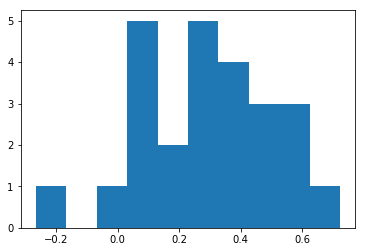

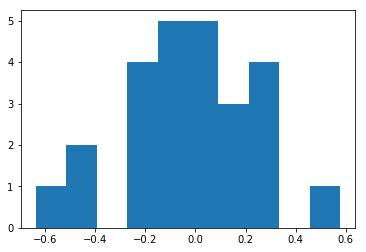

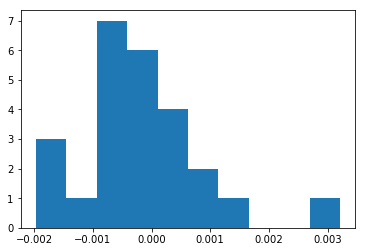

[  2.93967020e-01  -1.89418060e-02  -2.14789764e-04   2.93331532e-01
  -3.82325280e-01  -1.77344307e-03]
Training epoch 38600
Iter: 38600
D loss: 2.39e-05
G_loss: 0.001853
()
Training epoch 38700
Iter: 38700
D loss: 2.448e-05
G_loss: 0.001796
()


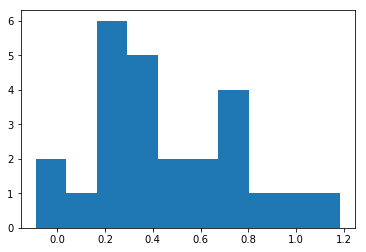

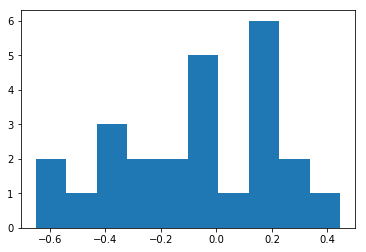

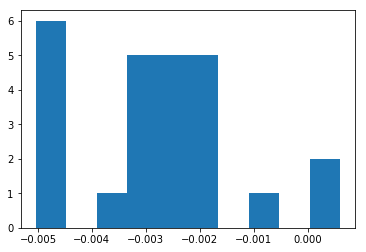

[ 0.45867799 -0.08391305 -0.00279101  0.45948546 -0.42394743  0.0016624 ]
Training epoch 38800
Iter: 38800
D loss: 2.406e-05
G_loss: 0.001916
()
Training epoch 38900
Iter: 38900
D loss: 2.395e-05
G_loss: 0.001818
()
Training epoch 39000
Iter: 39000
D loss: 2.486e-05
G_loss: 0.00181
()


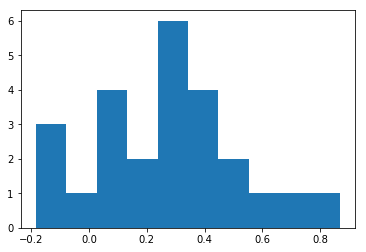

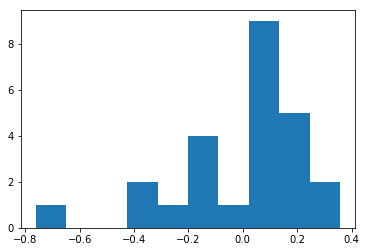

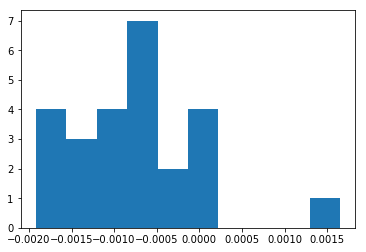

[ 0.26434842 -0.0061106  -0.00074296  0.26592215 -0.34219441 -0.00665468]
Training epoch 39100
Iter: 39100
D loss: 2.497e-05
G_loss: 0.001786
()
Training epoch 39200
Iter: 39200
D loss: 2.555e-05
G_loss: 0.001781
()


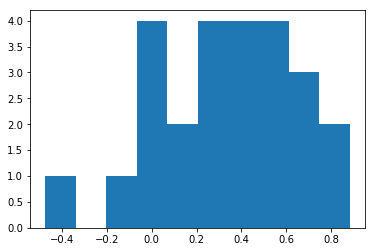

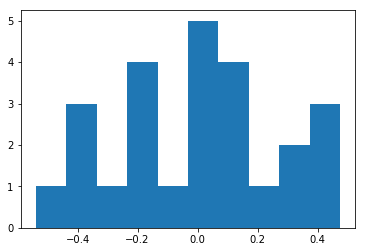

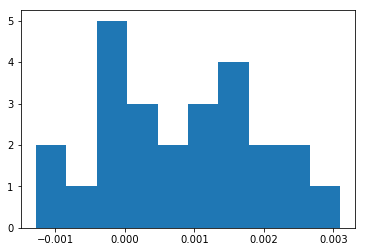

[  3.33687239e-01  -6.29543066e-04   7.68213390e-04   3.34991339e-01
  -4.23390302e-01   6.61380240e-06]
Training epoch 39300
Iter: 39300
D loss: 2.278e-05
G_loss: 0.001699
()
Training epoch 39400
Iter: 39400
D loss: 2.308e-05
G_loss: 0.00187
()
Training epoch 39500
Iter: 39500
D loss: 2.3e-05
G_loss: 0.001828
()


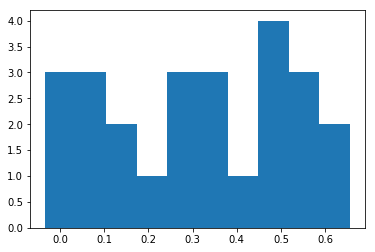

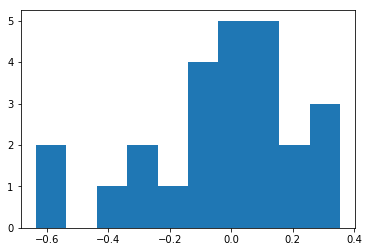

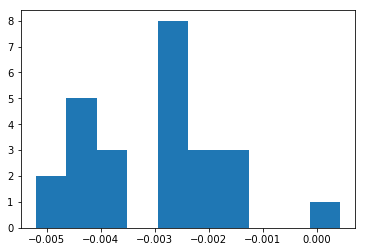

[ 0.31365054 -0.02753318 -0.00304931  0.31449184 -0.4284958  -0.00050124]
Training epoch 39600
Iter: 39600
D loss: 2.269e-05
G_loss: 0.001837
()
Training epoch 39700
Iter: 39700
D loss: 2.396e-05
G_loss: 0.001795
()


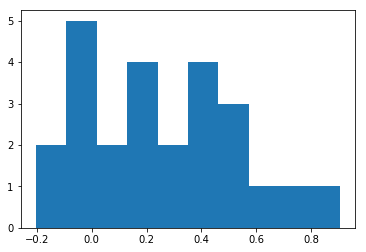

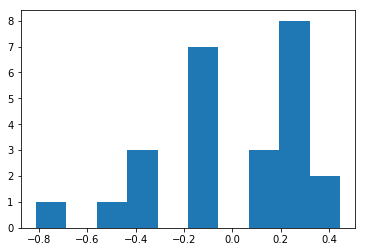

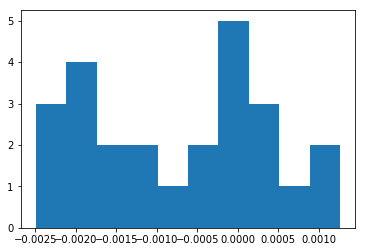

[ 0.24813607  0.00625322 -0.00070548  0.24819168 -0.37326026 -0.00256006]
Training epoch 39800
Iter: 39800
D loss: 2.471e-05
G_loss: 0.001806
()
Training epoch 39900
Iter: 39900
D loss: 2.402e-05
G_loss: 0.001769
()
Training epoch 40000
Iter: 40000
D loss: 2.277e-05
G_loss: 0.001745
()


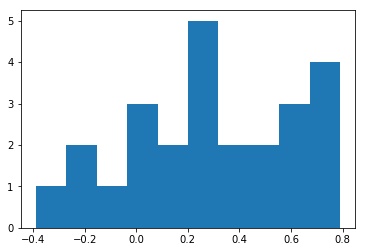

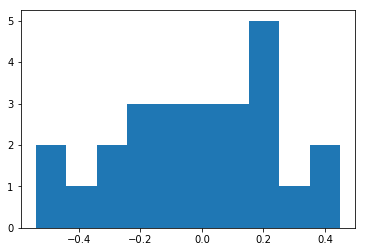

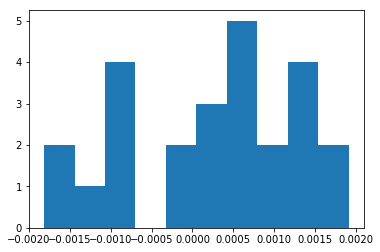

[  2.98814454e-01  -1.99306566e-02   2.39676500e-04   2.98664871e-01
  -4.03745449e-01   2.01575757e-03]
Training epoch 40100
Iter: 40100
D loss: 2.513e-05
G_loss: 0.001725
()
Training epoch 40200
Iter: 40200
D loss: 2.307e-05
G_loss: 0.00176
()


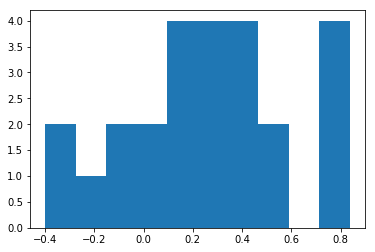

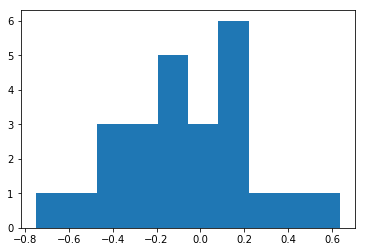

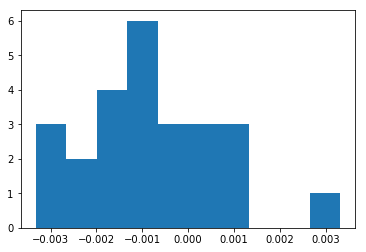

[ 0.26196145 -0.05885864 -0.00079837  0.26297785 -0.38134041 -0.0032605 ]
Training epoch 40300
Iter: 40300
D loss: 2.294e-05
G_loss: 0.001673
()
Training epoch 40400
Iter: 40400
D loss: 2.381e-05
G_loss: 0.001761
()
Training epoch 40500
Iter: 40500
D loss: 2.405e-05
G_loss: 0.001768
()


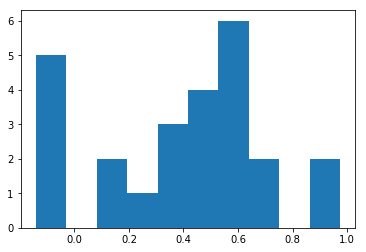

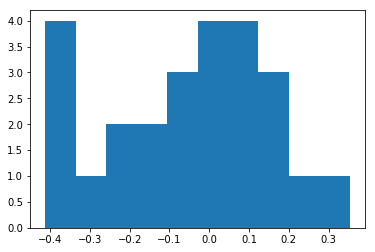

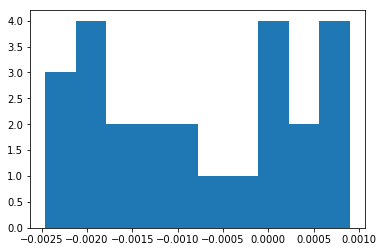

[ 0.38740381 -0.05616207 -0.00076642  0.38795542 -0.4677632  -0.00160282]
Training epoch 40600
Iter: 40600
D loss: 2.4e-05
G_loss: 0.001762
()
Training epoch 40700
Iter: 40700
D loss: 2.405e-05
G_loss: 0.001817
()


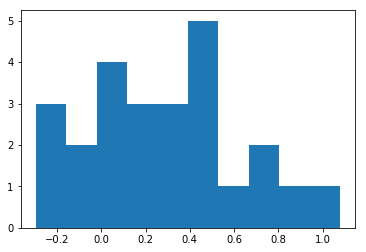

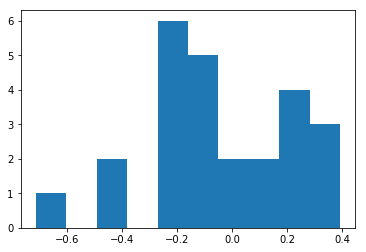

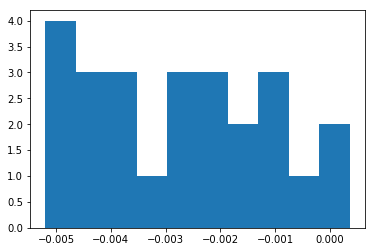

[ 0.27918548 -0.04500721 -0.00278738  0.27769191 -0.4194504   0.00065734]
Training epoch 40800
Iter: 40800
D loss: 2.384e-05
G_loss: 0.001803
()
Training epoch 40900
Iter: 40900
D loss: 2.338e-05
G_loss: 0.001769
()
Training epoch 41000
Iter: 41000
D loss: 2.287e-05
G_loss: 0.001781
()


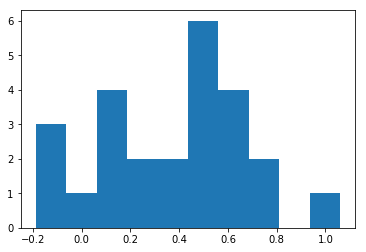

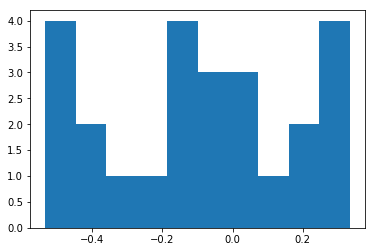

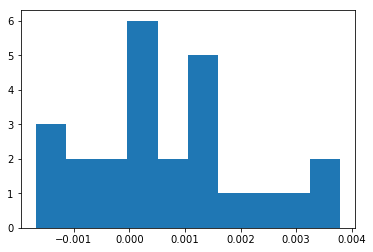

[ 0.37618104 -0.09062079  0.00068508  0.37570273 -0.41958122 -0.00133317]
Training epoch 41100
Iter: 41100
D loss: 2.326e-05
G_loss: 0.001764
()
Training epoch 41200
Iter: 41200
D loss: 2.351e-05
G_loss: 0.001743
()


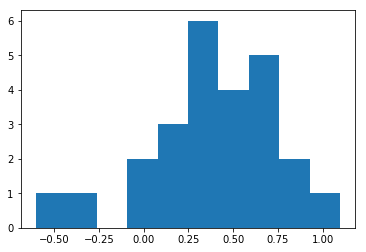

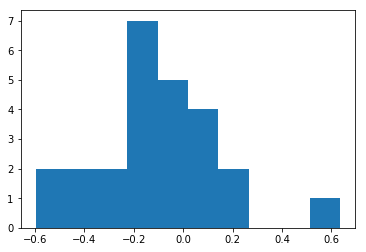

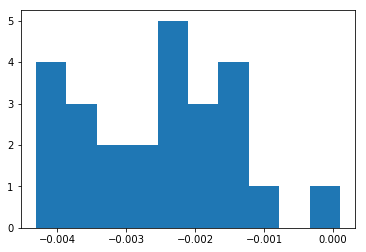

[ 0.38858369 -0.10863369 -0.0026122   0.38838623 -0.47808369 -0.00201186]
Training epoch 41300
Iter: 41300
D loss: 2.313e-05
G_loss: 0.001786
()
Training epoch 41400
Iter: 41400
D loss: 2.2e-05
G_loss: 0.001784
()
Training epoch 41500
Iter: 41500
D loss: 2.381e-05
G_loss: 0.001808
()


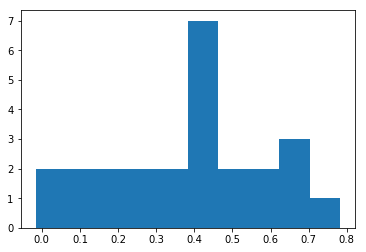

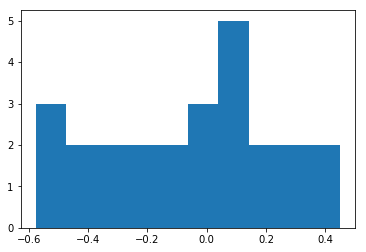

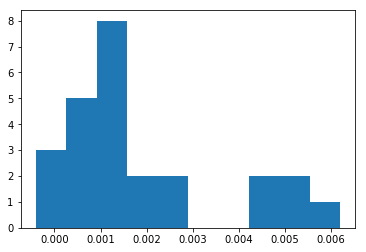

[ 0.38317582 -0.06592881  0.00185114  0.38305462 -0.41575359 -0.0005487 ]
Training epoch 41600
Iter: 41600
D loss: 2.32e-05
G_loss: 0.001721
()
Training epoch 41700
Iter: 41700
D loss: 2.256e-05
G_loss: 0.001732
()


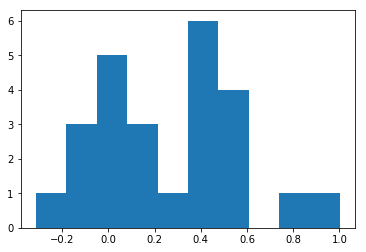

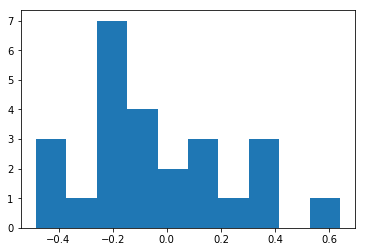

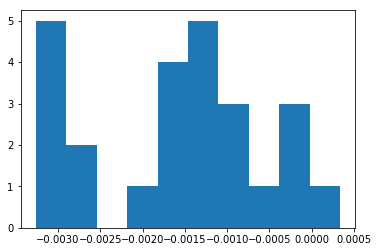

[ 0.2603897  -0.05368591 -0.00160281  0.26098403 -0.43036829 -0.00238661]
Training epoch 41800
Iter: 41800
D loss: 2.37e-05
G_loss: 0.001762
()
Training epoch 41900
Iter: 41900
D loss: 2.237e-05
G_loss: 0.001792
()
Training epoch 42000
Iter: 42000
D loss: 2.414e-05
G_loss: 0.00177
()


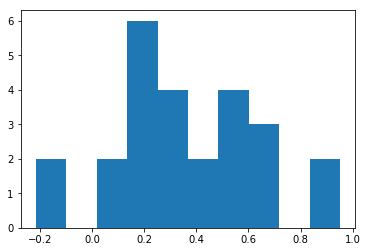

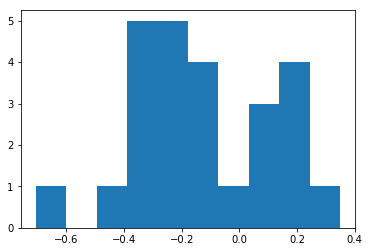

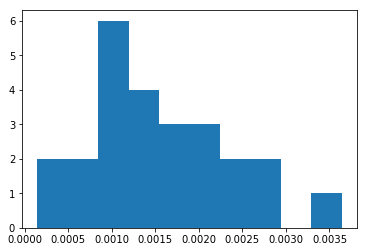

[ 0.36181303 -0.13670674  0.00157493  0.35847835 -0.44995113  0.00245708]
Training epoch 42100
Iter: 42100
D loss: 2.346e-05
G_loss: 0.001851
()
Training epoch 42200
Iter: 42200
D loss: 2.278e-05
G_loss: 0.001781
()


In [ ]:
G_pred = generator(z, is_training=False)
G_sample = generator(z, is_training=True)

D_real = discriminator(label_placeholder)
D_fake = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------

#D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=ones_like))
#D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=zeros_like))
#D_loss = D_loss_real + D_loss_fake
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=ones_like))

#D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
#D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
#D_loss = D_loss_real + D_loss_fake
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

#WGAN:
D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]

#D_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(D_loss, var_list=theta_D)
#G_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(G_loss, var_list=theta_G)

D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
            .minimize(-D_loss, var_list=theta_D))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
            .minimize(G_loss, var_list=theta_G))

mb_size = S

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_dataset = [features[0] for i in range(0,32)]
#train_dataset = []
#for i in range(0,16):
#    train_dataset += features[:16]
n_train = len(train_dataset)
preds = []

d_losses = []
g_losses = []

for it in range(100000):
    if it % 100 == 0:
        print("Training epoch %d" %it)
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
        
        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D],
                feed_dict=feed_dict)
            
        
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)

        
    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    if it % 250 == 0:
        samples = np.zeros((25,6))
        for i in range(0, 25):
            feed_dict = construct_feed_dict(train_dataset, start, stop, False)
            samples[i] = sess.run(G_sample, feed_dict=feed_dict)[0]
        plt.hist(samples[:,0], bins=10)
        plt.show()
        plt.hist(samples[:,1], bins=10)
        plt.show()
        plt.hist(samples[:,2], bins=10)
        plt.show()
        print(np.mean(samples, axis=0))
        #print(samples[:10])
        #plt.hist(samples, bins=50)
        #plt.show()

In [ ]:
 [ 0.9370852 , -0.2220445 ,  0.        ,  0.9370852 , -0.93765054,
         0.        ],

In [43]:
train_dataset[0][1][1].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.61143659, -0.99900387,  0.48252666,  0.61143659,  0.        ,
         0.        ],
       [-0.97974276,  0.46090066,  0.58913924, -0.97974276,  0.97948206,
         0.        ],
       [ 0.0092509 ,  0.        ,  0.        ,  0.0092509 , -0.87576691,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.

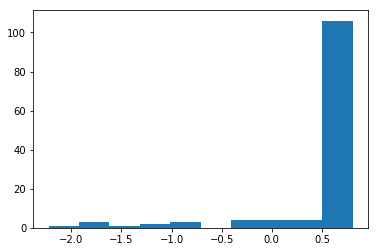

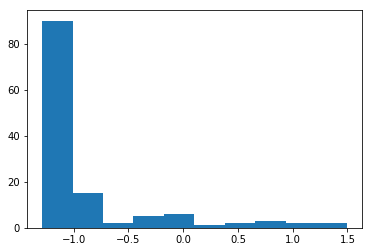

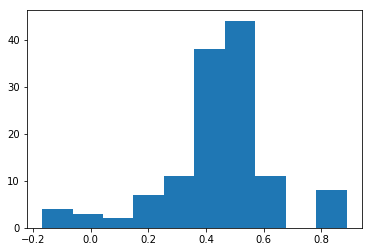

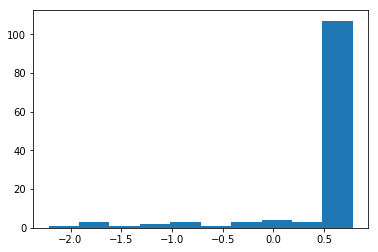

[  4.46803689e-01  -8.61598611e-01   4.45582092e-01   4.48124558e-01
   4.36727889e-02  -4.82748932e-04]


In [71]:
feed_dict = construct_feed_dict(train_dataset, start, stop, False)
inds = range(0,128*4,4)
samples = sess.run(G_sample, feed_dict=feed_dict)
samples = samples[inds]
plt.hist(samples[:,0], bins=10)
plt.show()
plt.hist(samples[:,1], bins=10)
plt.show()
plt.hist(samples[:,2], bins=10)
plt.show()
plt.hist(samples[:,3], bins=10)
plt.show()
print(np.mean(samples, axis=0))
#print(samples[:10])
#plt.hist(samples, bins=50)
#plt.show()

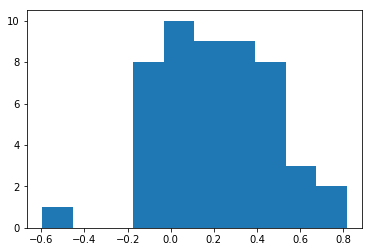

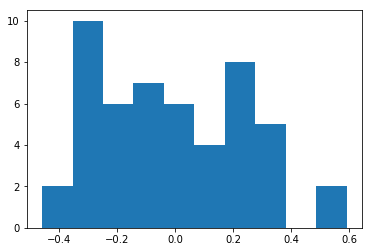

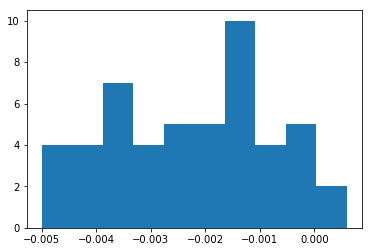

[  2.07347427e-01  -1.05754736e-02  -2.22802757e-03   2.06277720e-01
  -3.84236209e-01   2.61375877e-04]


In [18]:
samples = np.zeros((50,6))
for i in range(0, 50):
    feed_dict = construct_feed_dict(train_dataset, start, stop, False)
    samples[i] = sess.run(G_sample, feed_dict=feed_dict)[0]
plt.hist(samples[:,0], bins=10)
plt.show()
plt.hist(samples[:,1], bins=10)
plt.show()
plt.hist(samples[:,2], bins=10)
plt.show()
print(np.mean(samples, axis=0))
#print(samples[:10])
#plt.hist(samples, bins=50)
#plt.show()

In [68]:
samples

array([[  6.84835672e-01,  -1.08573687e+00,   4.22323346e-01,
          6.82211578e-01,  -4.60422635e-02,  -3.83595703e-04],
       [ -1.16148663e+00,   4.57557321e-01,   7.74113953e-01,
         -1.16413200e+00,   1.35043240e+00,  -1.09859398e-02],
       [  2.50741839e-02,  -8.41215253e-03,   3.28766704e-02,
          2.97103524e-02,  -9.41532671e-01,  -1.17874378e-02],
       [  7.66777635e-01,  -9.76679802e-01,   2.04086065e-01,
          7.34566987e-01,  -3.41211140e-01,  -1.09715213e-03],
       [  6.33780718e-01,  -1.08032167e+00,   4.62026298e-01,
          6.40313804e-01,   8.02031755e-02,   2.44973227e-04],
       [ -1.64962935e+00,   8.39063168e-01,   9.42281187e-01,
         -1.66608095e+00,   1.82514763e+00,  -1.20780291e-02],
       [  5.93720675e-02,  -5.27790189e-03,  -9.82954502e-02,
          4.30758595e-02,  -8.59469235e-01,   3.24005191e-03],
       [  6.26198530e-01,  -6.41943932e-01,   5.95412850e-02,
          6.21082127e-01,  -5.85359752e-01,  -9.47615132e-04],


In [ ]:
  [ 0.61143659, -0.99900387,  0.48252666,  0.61143659,  0.      

In [7]:
np.where(feed_dict[dihed_indices][0] != 0)

NameError: name 'np' is not defined

In [8]:
feed_dict[label_placeholder]

NameError: name 'feed_dict' is not defined

In [ ]:
feed_dict[non_zero_inds]

In [113]:
features[0][1][1].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.61143659, -0.99900387,  0.48252666,  0.61143659,  0.        ,
         0.        ],
       [-0.97974276,  0.46090066,  0.58913924, -0.97974276,  0.97948206,
         0.        ],
       [ 0.0092509 ,  0.        ,  0.        ,  0.0092509 , -0.87576691,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.

In [ ]:
sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
array([[ 0.91292151],
       [ 3.09695411],
       [ 1.06725919],

In [ ]:
plt.hist(sess.run(G_sample, feed_dict=feed_dict))

In [ ]:
batch_sched

In [ ]:
for it in range(20001):
    if it % 100 == 0:
        print("Training epoch %d" %it)
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict=feed_dict)
        plt.hist(samples, bins=50)
        plt.show()


In [ ]:
preds = []
for k in range(0,100):
    feed_dict = construct_feed_dict(train_dataset, 0, 1)
    samples = sess.run(G_sample, feed_dict=feed_dict)[2]
    preds.append(samples)

In [ ]:
plt.hist(np.concatenate(preds))

In [ ]:
preds[4]

In [ ]:
train_dataset[0][1][1].toarray()

In [ ]:
res = gan.predict()

In [ ]:
res

In [ ]:
plt.hist(res, bins=50)
plt.show()

In [ ]:
features[0][1][1].toarray()

In [ ]:
features[0][1][1].toarray()

In [ ]:
preds = []
for i in range(0,100):
    preds.append(gan.predict(features)[0][2])

In [ ]:
np.mean(preds)

In [ ]:
features[0][2].atom_features